<a href="https://colab.research.google.com/github/fabridella/Crypto-Volatility-Model/blob/main/Crypto_Volatility_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# SECTION 0A — Install Dependencies
# ============================================================
# Note: This is typically only needed once per environment.

!pip install --quiet numpy pandas yfinance scikit-learn
!pip install --quiet matplotlib seaborn plotly statsmodels xgboost lightgbm shap
!pip install --quiet arch catboost dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 80.5 MB/s eta 0:00:00


In [ ]:
# ============================================================
# SECTION 0B — Imports and Global Configuration
# ============================================================

# ---- General / Utilities ----
import os
import sys
import math
import time
import pickle
import warnings
from datetime import datetime, timedelta
from collections import defaultdict
from tqdm import tqdm
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ---- Data Manipulation ----
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.6f}".format

# ---- Financial Data ----
import yfinance as yf

# ---- Statistics / Scientific Computing ----
from scipy.stats import spearmanr, skew, kurtosis
from scipy.optimize import minimize
from scipy.interpolate import PchipInterpolator
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller


# ---- Visualization ----
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px

plt.rcParams["figure.figsize"] = (12, 5)
sns.set_style("whitegrid")

# ---- Machine Learning ----
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from arch import arch_model
import shap
from joblib import Parallel, delayed

# ---- Deep Learning ----
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ---- Dash (optional for dashboard visualization) ----
try:
    from dash import Dash, dcc, html, Input, Output
    dash_available = True
except ImportError:
    dash_available = False

In [ ]:
# ============================================================
# SECTION 1 — Global Settings
#
# This section defines the global configuration used
# throughout the entire analysis. All parameters here
# control scope, time span, and reproducibility.
# ============================================================

# Scope choice: top 5 Cryptos
CRYPTO_SYMBOLS = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD"]

# Timeframe selection
START_DATE = "2022-04-10"  # Post-COVID period
END_DATE   = "2025-10-31"
USE_UTC_DATES = True # All timestamps are converted to UTC to ensure consistency

# Reproducibility settings
RANDOM_SEED = 42 #Convention in ML
np.random.seed(RANDOM_SEED) # A fixed random seed is used across NumPy
tf.random.set_seed(RANDOM_SEED) # and TensorFlow

# Logging
print(f"Using random seed = {RANDOM_SEED}")
print(f"Fetching data for: {', '.join(CRYPTO_SYMBOLS)}")

Using random seed = 42
Fetching data for: BTC-USD, ETH-USD, BNB-USD, SOL-USD, XRP-USD


In [ ]:
# ============================================================
# SECTION 2 — Download OHLCV Data (Yahoo Finance)
#
# This section retrieves daily OHLCV data for the selected
# cryptocurrencies and performs basic structural checks
# before any cleaning or feature engineering.
# ============================================================

def download_cryptos(symbols, start, end, interval="1d", max_retries=2):
    """
    Download daily OHLCV data for multiple cryptocurrency tickers
    using Yahoo Finance.

    Parameters:
    - symbols: list of ticker symbols
    - start, end: date range
    - interval: data frequency (daily)
    - max_retries: number of retry attempts in case of network/API issues

    Returns:
    - DataFrame with MultiIndex columns [ticker, field]
      when multiple symbols are requested.
    """
    for attempt in range(max_retries):
        try:
            data = yf.download(
                symbols,
                start=start,
                end=end,
                interval=interval,
                group_by="ticker",
                progress=False,
                threads=True, # parallel downloads for efficiency
            )
            return data
        except Exception as e:
            # Retry logic improves robustness against transient API failures
            print(f"Download attempt {attempt+1} failed: {e}")
            time.sleep(2)
    # Fail explicitly if all retry attempts are exhausted
    raise RuntimeError("Failed to download data after multiple attempts.")

print("\nDownloading OHLCV data from Yahoo Finance...")
# Raw download (may contain MultiIndex columns if multiple symbols)
raw = download_cryptos(CRYPTO_SYMBOLS, START_DATE, END_DATE)

# RESHAPE AND STANDARDIZE DATA
# Reshaping
frames = []
for sym in CRYPTO_SYMBOLS:
    # Convert Yahoo Finance ticker to internal symbol naming
    short_sym = sym.replace("-USD", "")

    # Handle MultiIndex output when downloading multiple symbol
    if isinstance(raw.columns, pd.MultiIndex):
        if sym not in raw.columns.levels[0]:
            # Defensive check: symbol missing from download
            print(f"Warning: {sym} not found in Yahoo Finance output.")
            continue
        df_temp = raw[sym].copy()
    else:
        # Single-symbol fallback
        df_temp = raw.copy()

    # Standardization
    # Ensure timezone-aware UTC and consistent column set
    df_temp = df_temp.reset_index()
    df_temp["Date"] = pd.to_datetime(df_temp["Date"], utc=True)
    df_temp = df_temp[["Date", "Open", "High", "Low", "Close", "Volume"]].dropna(how="any")
    df_temp["Symbol"] = short_sym
    frames.append(df_temp)

df_raw = pd.concat(frames, ignore_index=True)
df_raw = df_raw.sort_values(["Symbol", "Date"]).reset_index(drop=True)
df_raw["Symbol"] = df_raw["Symbol"].astype("category")

print("\nDownload complete.")
print("Rows per symbol:")
print(df_raw.groupby("Symbol").size())

# Preview of first rows (per symbol)
print("\nFirst 3 rows per symbol:")
print(
    df_raw.groupby("Symbol", group_keys=True)
          .head(3)
          .sort_values(["Symbol", "Date"])
          .to_string(index=False)
)

# Quick missing-day audit (before cleaning)
def missing_day_report(df):
    rpt = {}
    for s in df["Symbol"].cat.categories:
        d = df.loc[df["Symbol"] == s, "Date"].sort_values().dt.normalize()
        gaps = (d.diff().dt.days.dropna())
        rpt[s] = {
            "n_days": len(d),
            "min_gap_days": gaps.min() if not gaps.empty else 0,
            "max_gap_days": gaps.max() if not gaps.empty else 0,
            "n_gaps>1d": int((gaps > 1).sum())
        }
    return pd.DataFrame(rpt).T

# VISUALIZATION
print("\n=== Missing-day report (pre-clean) ===")
print(missing_day_report(df_raw))

print("\nRaw dataset summary BEFORE cleaning:")
print(df_raw.groupby("Symbol")[["Open","High","Low","Close","Volume"]].describe().round(2))




Download complete.
Rows per symbol:
Symbol
BNB    1300
BTC    1300
ETH    1300
SOL    1300
XRP    1300
dtype: int64

First 3 rows per symbol:
                     Date         Open         High          Low        Close      Volume Symbol
2022-04-10 00:00:00+00:00   427.149750   429.364105   418.590668   418.590668  1410282903    BNB
2022-04-11 00:00:00+00:00   418.658447   419.490784   392.109924   394.086884  2192782724    BNB
2022-04-12 00:00:00+00:00   394.288788   416.635803   393.166809   413.873932  2140526232    BNB
2022-04-10 00:00:00+00:00 42781.089844 43376.378906 42021.207031 42207.671875 17654475582    BTC
2022-04-11 00:00:00+00:00 42201.039062 42424.589844 39373.058594 39521.902344 33949912166    BTC
2022-04-12 00:00:00+00:00 39533.714844 40617.585938 39388.328125 40127.183594 30991500854    BTC
2022-04-10 00:00:00+00:00  3261.291504  3303.003174  3211.866943  3211.866943 10427054790    ETH
2022-04-11 00:00:00+00:00  3209.576904  3214.461914  2962.756592  2981.052246 21

In [ ]:
# ============================================================
# SECTION 2B — Daily Realized Variance (RV) Summary Table
#
# This section computes daily realized variance (RV) based on
# squared daily log returns and reports descriptive statistics
# and standard diagnostic tests for each cryptocurrency.
# ============================================================

print("\nComputing daily realized variances (RV = daily log-return^2)...")

# Sort raw data by symbol and date to ensure correct return computation
df_rv = df_raw.sort_values(["Symbol", "Date"]).copy()

# COMPUTE DAILY LOG RETURNS
# Log returns are preferred over simple returns because they
# are time-additive and standard in volatility modeling.
df_rv["logret"] = (
    df_rv.groupby("Symbol")["Close"]
         .transform(lambda s: np.log(s).diff())
)

# REALIZED VARIANCE (RV)
# Realized variance is defined as the squared daily log return.
# At daily frequency, RV serves as a noisy but unbiased proxy
# for the latent integrated variance.
df_rv["RV"] = df_rv["logret"] ** 2

# Drop the first NA per symbol only
df_rv = df_rv.dropna(subset=["RV"]).copy()

# SUMMARY
# Statistics per asset
summary_rows = []

for sym, d in df_rv.groupby("Symbol"):
    rv = d["RV"].dropna()

    n_obs   = len(rv)
    mean_   = rv.mean()
    median_ = rv.median()
    min_    = rv.min()
    max_    = rv.max()
    std_    = rv.std()
    skew_   = rv.skew()

    # Normality test: Jarque–Bera
    # Tests whether RV follows a normal distribution based on
    # skewness and kurtosis.
    jb_stat, jb_p = jarque_bera(rv)


    # Stationarity test: Augmented Dickey–Fuller (ADF)
    # Tests the null hypothesis of a unit root.
    # Stationarity is expected for squared returns.
    try:
        adf_stat, adf_p, _, _, _, _ = adfuller(rv, autolag="AIC")
    except Exception:
        # In rare cases the test may fail due to numerical issues
        adf_stat, adf_p = np.nan, np.nan

    # SUMMARY
    # Store results for the current asset
    summary_rows.append({
        "Symbol": sym,
        "# Obs": n_obs,
        "Mean": mean_,
        "Median": median_,
        "Minimum": min_,
        "Maximum": max_,
        "Std. Dev.": std_,
        "Skewness": skew_,
        "JB stat": jb_stat,
        "JB p-value": jb_p,
        "ADF stat": adf_stat,
        "ADF p-value": adf_p
    })

# Combine all asset-level summaries into a single table
df_rv_summary = pd.DataFrame(summary_rows).set_index("Symbol")

print("\n=== Realized Variance Summary Table ===")
display(df_rv_summary.round(6))



Computing daily realized variances (RV = daily log-return^2)...

=== Realized Variance Summary Table ===


# Obs     Mean   Median  Minimum  Maximum  Std. Dev.  Skewness  \
Symbol                                                                   
BNB      1299 0.000898 0.000186 0.000000 0.042177   0.002512  8.191877   
BTC      1299 0.000707 0.000151 0.000000 0.030294   0.001802  7.438704   
ETH      1299 0.001321 0.000285 0.000000 0.038888   0.003350  6.020052   
SOL      1299 0.002681 0.000755 0.000000 0.302040   0.010053 21.646873   
XRP      1299 0.001873 0.000294 0.000000 0.300912   0.009734 23.499919   

               JB stat  JB p-value   ADF stat  ADF p-value  
Symbol                                                      
BNB      496231.467398    0.000000 -10.230778     0.000000  
BTC      415334.829194    0.000000 -11.952689     0.000000  
ETH      124990.262018    0.000000 -11.228478     0.000000  
SOL    20304676.863421    0.000000 -27.581470     0.000000  
XRP    25926326.909815    0.000000 -32.438882     0.000000

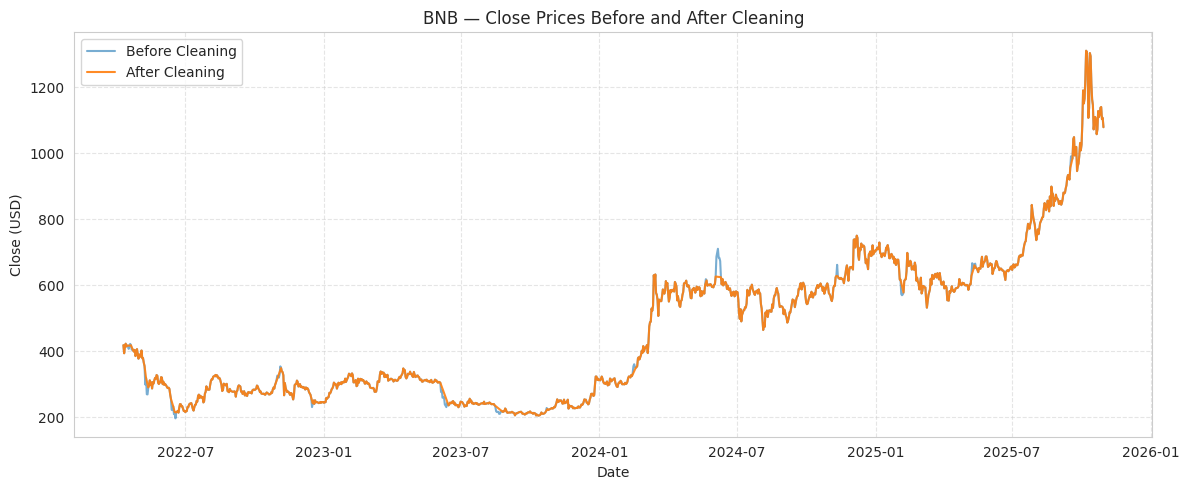

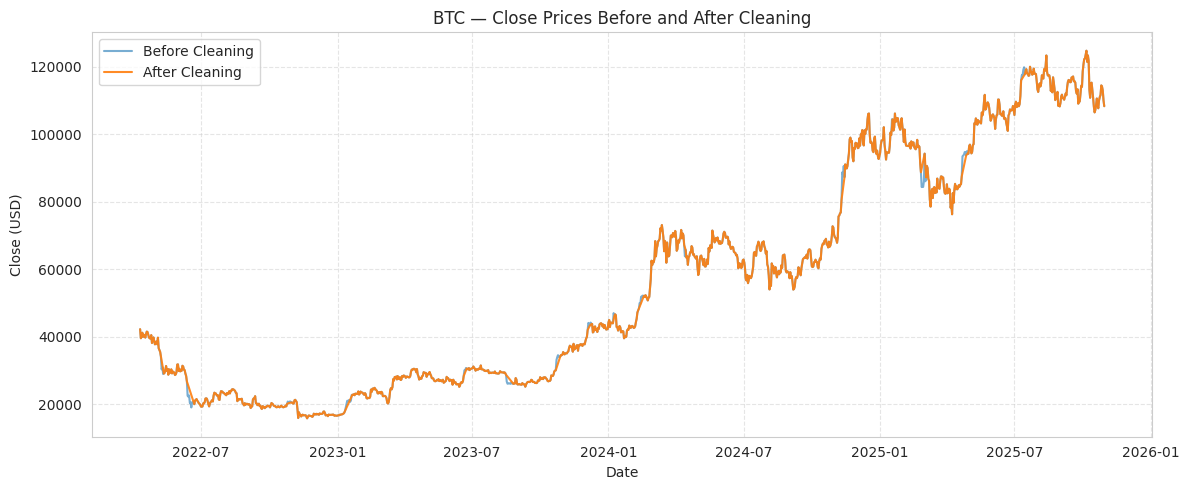

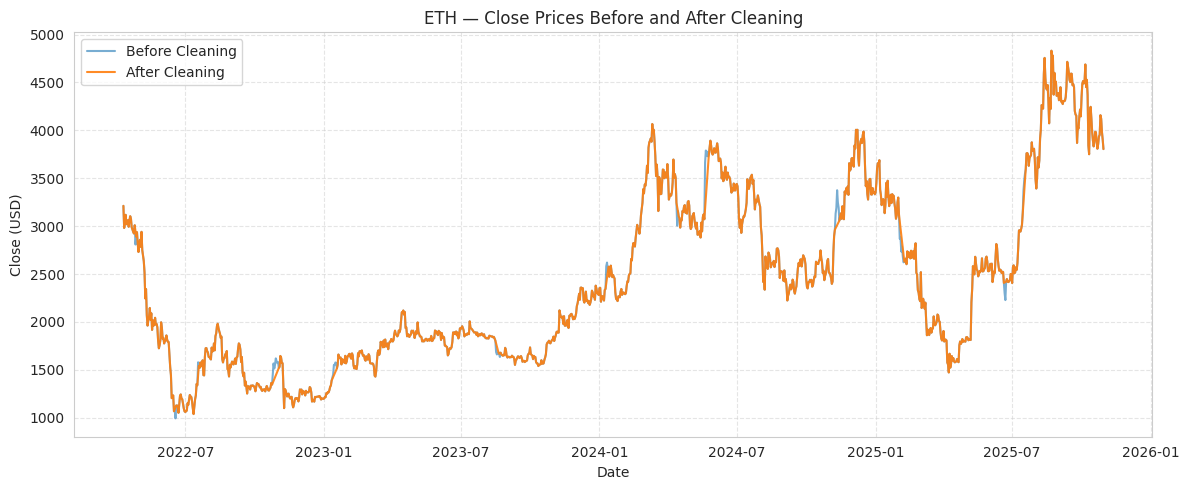

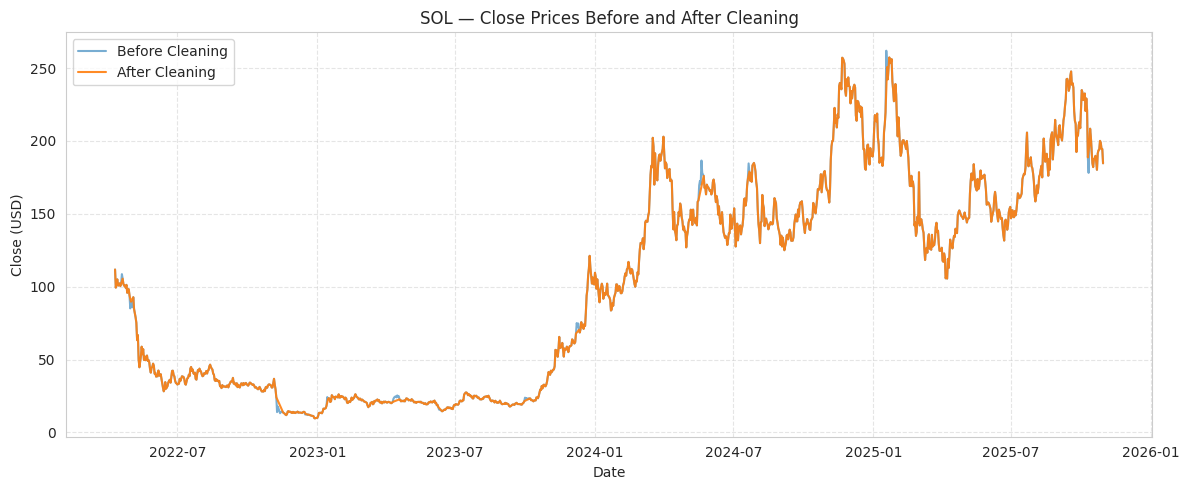

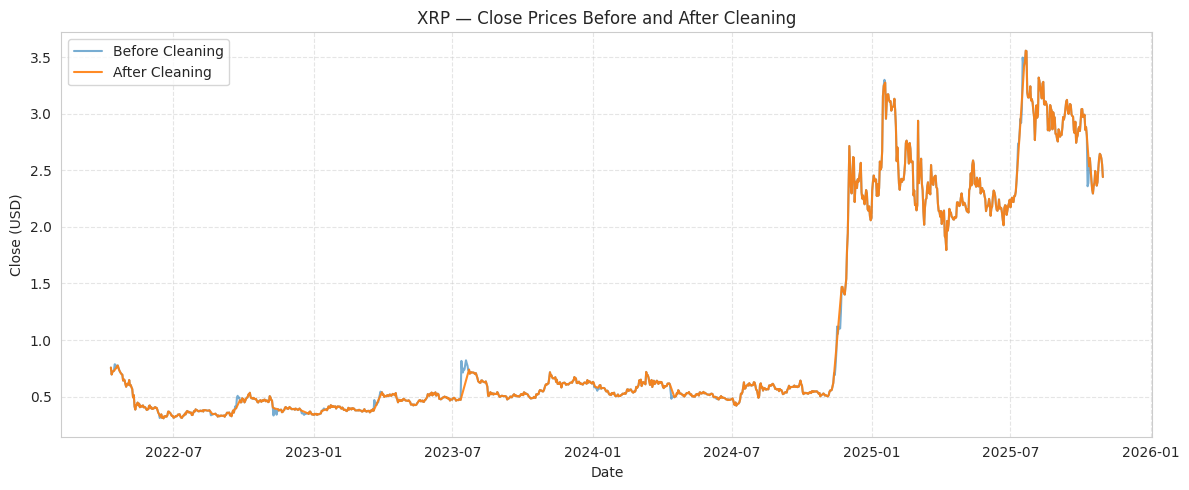


=== Cleaning Summary: Outlier Replacements per Column ===


Open  High  Low  Close  Volume
BNB    57    61   64     58      14
BTC    73    84   80     72      14
ETH    46    57   69     46      14
SOL    46    47   48     46      14
XRP    78    72   93     78      14

In [ ]:
# ============================================================
# SECTION 3 — Data Cleaning (Outlier Detection & Interpolation)
#
# This section performs robust data cleaning at the symbol level.
# The goal is to remove extreme price and volume outliers while
# preserving the underlying time-series structure and avoiding
# any look-ahead bias.
# ============================================================

# PREPARING CLEANING
def clean_symbol_prices(df_sym, price_cols, window=21, threshold=5.0):
    """
    Cleans OHLC price series using a rolling Median Absolute
    Deviation (MAD) filter and linear interpolation.

    Methodology:
    - Rolling median captures the local price level
    - Rolling MAD provides a robust dispersion estimate
    - Observations exceeding the MAD-based threshold are
      treated as outliers and replaced via interpolation

    IMPORTANT:
    - All rolling statistics are backward-looking only
      (no future information is used)
    """
    # Ensure Date is an explicit column
    df = df_sym.copy()
    if "Date" not in df.columns:
        df = df.reset_index()

    # Convert to datetime UTC, then sort rows by Date (do not sort the single column values)
    df["Date"] = pd.to_datetime(df["Date"], utc=True)
    df = df.sort_values("Date").reset_index(drop=True)
    # Ensure numeric type for price columns
    df[price_cols] = df[price_cols].astype(float)
    # Track number of outliers replaced per column
    counts = {col: 0 for col in price_cols}

    for col in price_cols:
        series = df[col]
        # Rolling median (local price level)
        rolling_median = series.rolling(window=window, min_periods=1).median()
        # Rolling MAD (robust scale estimator)
        # Using only past data avoids look-ahead bias
        mad = (series - rolling_median).abs().rolling(window=window, min_periods=1).median() # Avoiding MAD looking ahead
        # Robust z-score based on MAD
        zscore = (series - rolling_median).abs() / (mad + 1e-8)
        # Identify extreme deviations
        outliers = zscore > threshold
        counts[col] = int(outliers.sum())
        # Replace outliers with NaN and interpolate (linear), then forward/backward fill
        df[col] = series.mask(outliers).interpolate(method="linear").ffill().bfill()

    return df, counts

def clean_symbol_volume(df_sym, lower_pct=0.005, upper_pct=0.995):
    """
    Cleans trading volume using a quantile-based filter.

    Methodology:
    - Extreme low/high volume observations are identified
      using empirical quantiles
    - Outliers are replaced via interpolation rather than
      hard winsorization to preserve continuity

    This approach reduces the impact of data errors or
    exchange-specific glitches while avoiding artificial caps.
    """
    df = df_sym.copy()
    # Ensure Date is an explicit column
    if "Date" not in df.columns:
        df = df.reset_index()
    # Enforce UTC datetime and chronological order
    df["Date"] = pd.to_datetime(df["Date"], utc=True)
    df = df.sort_values("Date").reset_index(drop=True)
    # Compute lower and upper quantile thresholds
    low, high = df["Volume"].quantile([lower_pct, upper_pct])
    # Identify volume outliers
    outliers = (df["Volume"] < low) | (df["Volume"] > high)
    count = int(outliers.sum())
    # Replace extreme values via interpolation and fill edges
    df["Volume"] = df["Volume"].mask(outliers).interpolate(method="linear").ffill().bfill()

    return df, count

# APPLY CLEANING
# Apply cleaning per symbol with a continuous daily UTC index to ensure aligned calendar
price_cols = ["Open", "High", "Low", "Close"]
cleaned_frames, cleaning_summary = [], {}

# Ensure global Date column is UTC and sorted
df_raw["Date"] = pd.to_datetime(df_raw["Date"], utc=True)
df_raw = df_raw.sort_values(["Symbol", "Date"])
symbols = df_raw["Symbol"].unique()

for sym in symbols:
    df_sym = df_raw[df_raw["Symbol"] == sym].copy()

    # Build a full daily UTC calendar for the symbol
    # This ensures:
    # - aligned calendars across assets
    # - no implicit gaps in rolling-window calculations
    full_index = pd.date_range(
        start=df_sym["Date"].min().normalize(),
        end=df_sym["Date"].max().normalize(),
        freq="D",
        tz="UTC"
    )

    # Reindex to full calendar
    df_sym = df_sym.set_index("Date").reindex(full_index).rename_axis("Date").reset_index()

    # Restore symbol identifier after reindexing
    df_sym["Symbol"] = sym

    # Interpolate small gaps before outlier masking to avoid cascade NaNs
    # This prevents cascades of NaNs when computing rolling
    # statistics and ensures stable MAD estimates
    df_sym[price_cols + ["Volume"]] = df_sym[price_cols + ["Volume"]].interpolate("linear").ffill().bfill()

    # Apply robust price cleaning
    cleaned_prices, price_counts = clean_symbol_prices(df_sym, price_cols)
    # Apply volume cleaning
    cleaned_vol, vol_count = clean_symbol_volume(cleaned_prices)

    # Drop rows where core price information is missing
    cleaned_vol = cleaned_vol.dropna(subset=["Close"]).copy()

    # Store cleaned data
    cleaned_frames.append(cleaned_vol)
    # Store per-symbol cleaning diagnostics
    cleaning_summary[sym] = {**price_counts, "Volume": vol_count}

    # PLOTTING
    # Visual inspection plot
    plt.figure(figsize=(12, 5))
    # original (pre-full-index) for comparison
    orig = df_raw[df_raw["Symbol"] == sym].set_index("Date").sort_index()
    plt.plot(orig.index, orig["Close"], label="Before Cleaning", alpha=0.6)
    plt.plot(cleaned_vol["Date"], cleaned_vol["Close"], label="After Cleaning", alpha=0.9)
    plt.title(f"{sym} — Close Prices Before and After Cleaning")
    plt.xlabel("Date"); plt.ylabel("Close (USD)"); plt.legend(); plt.grid(True, ls="--", alpha=0.5)
    plt.tight_layout(); plt.show()

# FINAL CLEANED DATASET
df_cleaned = (
    pd.concat(cleaned_frames, ignore_index=True)
      .sort_values(["Symbol", "Date"])
      .reset_index(drop=True)
)
df_cleaned["Symbol"] = df_cleaned["Symbol"].astype("category")

# SUMMARY
print("\n=== Cleaning Summary: Outlier Replacements per Column ===")
summary_df = pd.DataFrame(cleaning_summary).T.fillna(0).astype(int)
try:
    display(summary_df)
except NameError:
    print(summary_df.to_string())



In [ ]:
# ============================================================
# SECTION 4 — Construct Target Variable (Yang–Zhang Log-Variance)
#
# This section constructs the target variable used throughout
# the forecasting exercise: next-day Yang–Zhang log-variance.
# The Yang–Zhang estimator combines overnight, intraday,
# and range-based volatility components in a robust way.
# ============================================================

def compute_yang_zhang_logvar_per_symbol(df_sym, k=0.34, eps=1e-12):
    """
    Computes a daily Yang–Zhang-like realized variance and
    the corresponding log-variance target.

    Components:
    - Overnight return volatility
    - Open-to-close return volatility
    - Rogers–Satchell range-based volatility

    The log-variance target is shifted by one day to define
    next-day volatility forecasting (t → t+1).
    """
    # Work on a copy and ensure strict chronological ordering
    df = df_sym.copy().sort_values("Date").reset_index(drop=True)

    # RETURN DECOMPOSITION
    # Overnight return: close_(t-1) → open_t
    df["r_overnight"]  = np.log(df["Open"] / df["Close"].shift(1))
    # Intraday open-to-close return: open_t → close_t

    # ROGERS-SATCHELL RANGE-BASE COMPONENTS
    # Uses high, low, open, and close prices to capture
    # intraday volatility without assuming zero drift
    df["r_openclose"]  = np.log(df["Close"] / df["Open"])
    log_h = np.log(df["High"] / df["Open"])
    log_l = np.log(df["Low"]  / df["Open"])
    # Rogers–Satchell term
    rs = log_h * np.log(df["High"] / df["Close"]) + log_l * np.log(df["Low"] / df["Close"])

    # YANG-ZHANG REALIZED VOLATILITY
    # Combines overnight variance, open–close variance,
    # and range-based variance using weighting parameter k
    df["rv_yz"]  = (df["r_overnight"]**2) + k*(df["r_openclose"]**2) + (1 - k)*rs
    # Numerical safeguard: prevent zero or negative variance
    df["rv_yz"]  = df["rv_yz"].clip(lower=eps)
    # Derived volatility and log-variance
    df["vol_yz"] = np.sqrt(df["rv_yz"])
    df["logvar"] = np.log(df["rv_yz"] + eps)
    # Target alignment
    # The forecasting target is next-day log-variance.
    # logvar_next at time t corresponds to volatility realized at t+1.
    df["logvar_next"] = df["logvar"].shift(-1)
    return df

# APPLY YANG-ZHANG TO ALL ASSETS
dfs_yz = []
for sym in df_cleaned["Symbol"].unique():
    mask = df_cleaned["Symbol"] == sym
    # Select required OHLCV fields
    cols = ["Date","Open","High","Low","Close","Volume","Symbol"]
    # Compute Yang–Zhang realized variance and target
    df_sym = df_cleaned.loc[mask, cols].copy()
    df_yz_sym = compute_yang_zhang_logvar_per_symbol(df_sym)
    dfs_yz.append(df_yz_sym)

# Combine all symbols into a single panel
df_yz = pd.concat(dfs_yz, ignore_index=True).sort_values(["Symbol","Date"]).reset_index(drop=True)

In [ ]:
# ============================================================
# SECTION 5 — Feature Engineering per Symbol
#
# This section constructs the full set of explanatory variables
# used to predict next-day log-variance.
#
# IMPORTANT:
# - All features are strictly lagged or backward-looking
# - No information from t+1 is used when predicting y_(t+1)
# - This guarantees a leakage-free forecasting setup
# ============================================================

def build_features_for_symbol(df_sym, eps=1e-12):
    """
    Construct explanatory variables for next-day log-variance prediction.

    Design principles:
    - Volatility persistence and long memory
    - Asymmetric return effects
    - Volume and liquidity effects
    - Calendar seasonality
    - Strict temporal causality (t → t+1)
    """
    # Work on a copy and enforce chronological order
    df = df_sym.copy().sort_values("Date").reset_index(drop=True)

    # TARGET CONSTRUCTION (YANG-ZHANG LOG-VARIANCE)
    # Computes realized volatility components and log-variance
    # using only information available up to time t
    df = compute_yang_zhang_logvar_per_symbol(df, eps=eps)
    # Forecasting target: next-day log-variance
    df["y_logvar"] = df["logvar"].shift(-1)  # target is next day's log-variance

    # LAGGED VOLATILITY FEATURES (PERSISTANCE + LONG MEMORY)
    # One-day lagged log-variance (core predictor)
    df["logvar_lag1"] = df["logvar"].shift(1)
    # Short-term volatility regime (≈ weekly)
    df["logvar_w5"]  = df["logvar"].rolling(5, min_periods=3).mean().shift(1)
    # Medium-term volatility regime (≈ monthly)
    df["logvar_w22"] = df["logvar"].rolling(22, min_periods=5).mean().shift(1)

    # RETURN BASED FEATURES
    #Daily log return
    df["r"] = np.log(df["Close"]).diff()
    #lagged return
    df["r_lag1"] = df["r"].shift(1)
    # Positive and negative return components
    # Capture asymmetric volatility response
    df["r_pos1"] = df["r_lag1"].clip(lower=0)
    df["r_neg1"] = (-df["r_lag1"]).clip(lower=0)

    # JUMP INDICATOR (EXTREME RETURN EVENTS)
    # Rolling volatility estimate of returns
    df["r_roll_std_21"] = df["r"].rolling(21, min_periods=10).std()
    # Jump flag: identifies unusually large absolute returns
    # Threshold set at 3 standard deviations
    df["jump_flag"] = (df["r"].abs() > 3 * (df["r_roll_std_21"] + eps)).astype(int)
    # Lag jump indicator to prevent contemporaneous leakage
    df["jump_flag"] = df["jump_flag"].shift(1).fillna(0)

    # VOLUME BASED FEATURES (LIQUIDITY AND TRADING ACTIVITY)
    # Lagged log trading volume
    df["log_volume_lag1"] = np.log(df["Volume"].shift(1) + 1)
    # Lagged log dollar volume (volume × price)
    df["dollar_vol_lag1"] = np.log((df["Volume"] * df["Close"]).shift(1) + 1)

    # VOLATILITY OF VOLATILITY
    # Measures instability in the volatility process itself
    df["volofvol_21"] = df["logvar"].rolling(21, min_periods=10).std()

    # CALENDAR EFFECTS (DAY-OF-WEEK SEASONALITY)
    # # Day of week: Monday=0, ..., Sunday=6
    df["dow"] = pd.to_datetime(df["Date"]).dt.dayofweek
    # One-hot encode day-of-week dummies
    # Drop first dummy to avoid multicollinearity
    dow_dummies = pd.get_dummies(df["dow"], prefix="dow", drop_first=True)
    df = pd.concat([df, dow_dummies], axis=1)

    # FINAL CLEANUP
    # Remove rows with missing core predictors or target
    required_cols = ["y_logvar", "logvar_lag1", "logvar_w5", "logvar_w22"]
    df = df.dropna(subset=required_cols).reset_index(drop=True)
    return df


In [ ]:
# ============================================================
# SECTION 6 — Build Panel Dataset and Train/Test Split 80/20
#
# This section constructs the final panel dataset used for
# model estimation and evaluation. Feature engineering is
# performed per symbol, after which all assets are stacked
# into a single panel. A strict time-based train/test split
# is then applied independently for each cryptocurrency.
# ============================================================

# Containers for per-symbol and pooled feature datasets
panel_dfs, per_symbol_dfs = [], {}

print("\n=== Building per-symbol feature sets ===")

# FEATURE CONSTRUCTION PER ASSET
# Extract cleaned OHLCV data for a single asset
for sym in sorted(df_cleaned["Symbol"].unique()):
    df_sym = df_cleaned[df_cleaned["Symbol"] == sym].copy()
    # Ensure UTC datetime format and chronological order
    df_sym["Date"] = pd.to_datetime(df_sym["Date"], utc=True)
    df_sym = df_sym.sort_values("Date").reset_index(drop=True)

    try:
        # Build lagged features and target variable
        df_features = build_features_for_symbol(df_sym)
        # Basic data sufficiency check after feature construction
        if df_features.empty or len(df_features) < 50:
            print(f"Warning: {sym} — insufficient data after feature engineering, skipping.")
            continue
        # Store per-symbol dataset (useful for diagnostics)
        per_symbol_dfs[sym] = df_features
        # Append to pooled panel list
        panel_dfs.append(df_features)
        print(f"{sym}: {df_features.shape[0]} rows, {df_features.shape[1]} columns.")
    except Exception as e:
        # Defensive programming: isolate failures by symbol
        print(f"Error in {sym}: feature construction failed — {e}")
# Abort if no valid datasets were produced
if not panel_dfs:
    raise RuntimeError("No valid feature datasets produced — check earlier cleaning steps.")

# CONSTRUCT POOLED PANEL DATASET
# Panel dataset
panel_df = (
    pd.concat(panel_dfs, ignore_index=True)
      .sort_values(["Symbol", "Date"])
      .reset_index(drop=True)
)
print("\nPanel dataset shape:", panel_df.shape)
print("Symbols included:", sorted(panel_df["Symbol"].unique()))

# TIME-BASED 80/20 TRAIN/TEST SPLIT PER SYMBOL
# Initialize split indicator
panel_df["Split"] = np.nan
for sym in sorted(panel_df["Symbol"].unique()):
    mask = panel_df["Symbol"] == sym
    df_sym = panel_df.loc[mask].sort_values("Date")
    n_total = len(df_sym)
    # If too few observations, assign all data to training
    if n_total < 50:
        panel_df.loc[mask, "Split"] = "Train"
        continue
    # Determine time-based cutoff (80% of observations)
    cutoff_idx = int(0.8 * n_total)
    cutoff_date = df_sym.iloc[cutoff_idx]["Date"]
    # Assign observations strictly before cutoff to Train
    # Using '<' (not '<=') avoids panel data leakage at the boundary
    panel_df.loc[mask, "Split"] = np.where(df_sym["Date"] < cutoff_date, "Train", "Test") # changed from <= to avoid panel data leakage

# SPLIT DATASET
# Train / Test dataset
train_df = panel_df[panel_df["Split"] == "Train"].copy()
test_df  = panel_df[panel_df["Split"] == "Test"].copy()
print(f"\nTrain size: {len(train_df)} rows  |  Test size: {len(test_df)} rows")
print("Train period:", train_df["Date"].min().strftime("%Y-%m-%d"), "→", train_df["Date"].max().strftime("%Y-%m-%d"))
print("Test period: ", test_df["Date"].min().strftime("%Y-%m-%d"),  "→", test_df["Date"].max().strftime("%Y-%m-%d"))

# FINAL LEAKEAGE SANITY CHECK
# Quick sanity check: no symbol/date overlap between Train and Test
chk_overlap = (
    train_df.merge(test_df, on=["Symbol","Date"], how="inner")
)
assert chk_overlap.empty, "Train/Test date overlap detected!"



=== Building per-symbol feature sets ===
BNB: 1293 rows, 33 columns.
BTC: 1293 rows, 33 columns.
ETH: 1293 rows, 33 columns.
SOL: 1293 rows, 33 columns.
XRP: 1293 rows, 33 columns.

Panel dataset shape: (6465, 33)
Symbols included: ['BNB', 'BTC', 'ETH', 'SOL', 'XRP']

Train size: 5170 rows  |  Test size: 1295 rows
Train period: 2022-04-16 → 2025-02-12
Test period:  2025-02-13 → 2025-10-29


In [ ]:
# ============================================================
# SECTION 7 — Feature Selection for Modeling
#
# This section defines the final set of explanatory variables
# used by all baseline and machine learning models.
#
# The goal is to:
# - Exclude raw price variables and intermediate helpers
# - Avoid any form of target leakage
# - Ensure consistency across baseline and ML models
# ============================================================

# COLUMNS TO EXCLUDE FROM MODELING
# These includes:
# - Identifiers (Date, Symbol)
# - Raw OHLCV prices (already embedded in engineered features)
# - Intermediate variables used only during feature construction
# - The target variable and any future-looking helpers
ignore_cols = [
    "Date", "Symbol", "Open", "High", "Low", "Close", "Volume",
    "vol_yz", "logvar", "r", "r_lag1", "r_pos1", "r_neg1",
    "r_roll_std_21", "jump_flag", "log_volume_lag1", "dollar_vol_lag1",
    "volofvol_21", "dow",
    # Explicitly exclude target and any future-looking helpers
    "y_logvar", "logvar_next"
]

# DAY-OF-WEEK DUMMY VARIABLES
# Ensure day-of-week indicators are treated as numeric
# (0/1 integers) rather than boolean or categorical types.
dow_cols = [c for c in panel_df.columns if c.startswith("dow_")]
panel_df[dow_cols] = panel_df[dow_cols].astype(int)

# CANDIDATE FEATURE SELECTION
# Keep only numeric columns:
# - b: boolean
# - i: integer
# - u: unsigned integer
# - f: float
# - c: complex (not expected but included defensively)
candidate_features = [c for c in panel_df.columns if panel_df[c].dtype.kind in "biufc"]

# FINAL FEATURE SET
# Remove ignored columns from numeric candidates.
# The resulting list is used consistently across:
# - Linear regression
# - Elastic Net
# - Tree-based ML models
# - Neural networks
features = sorted([c for c in candidate_features if c not in ignore_cols])

# LOGGING
# Results for transparency
print(f"\nSelected {len(features)} modeling features:")
print(features[:10], "..." if len(features) > 10 else "")
print(features)


Selected 12 modeling features:
['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'logvar_lag1', 'logvar_w22', 'logvar_w5', 'r_openclose'] ...
['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'logvar_lag1', 'logvar_w22', 'logvar_w5', 'r_openclose', 'r_overnight', 'rv_yz']



=== Baseline evaluation for BNB ===


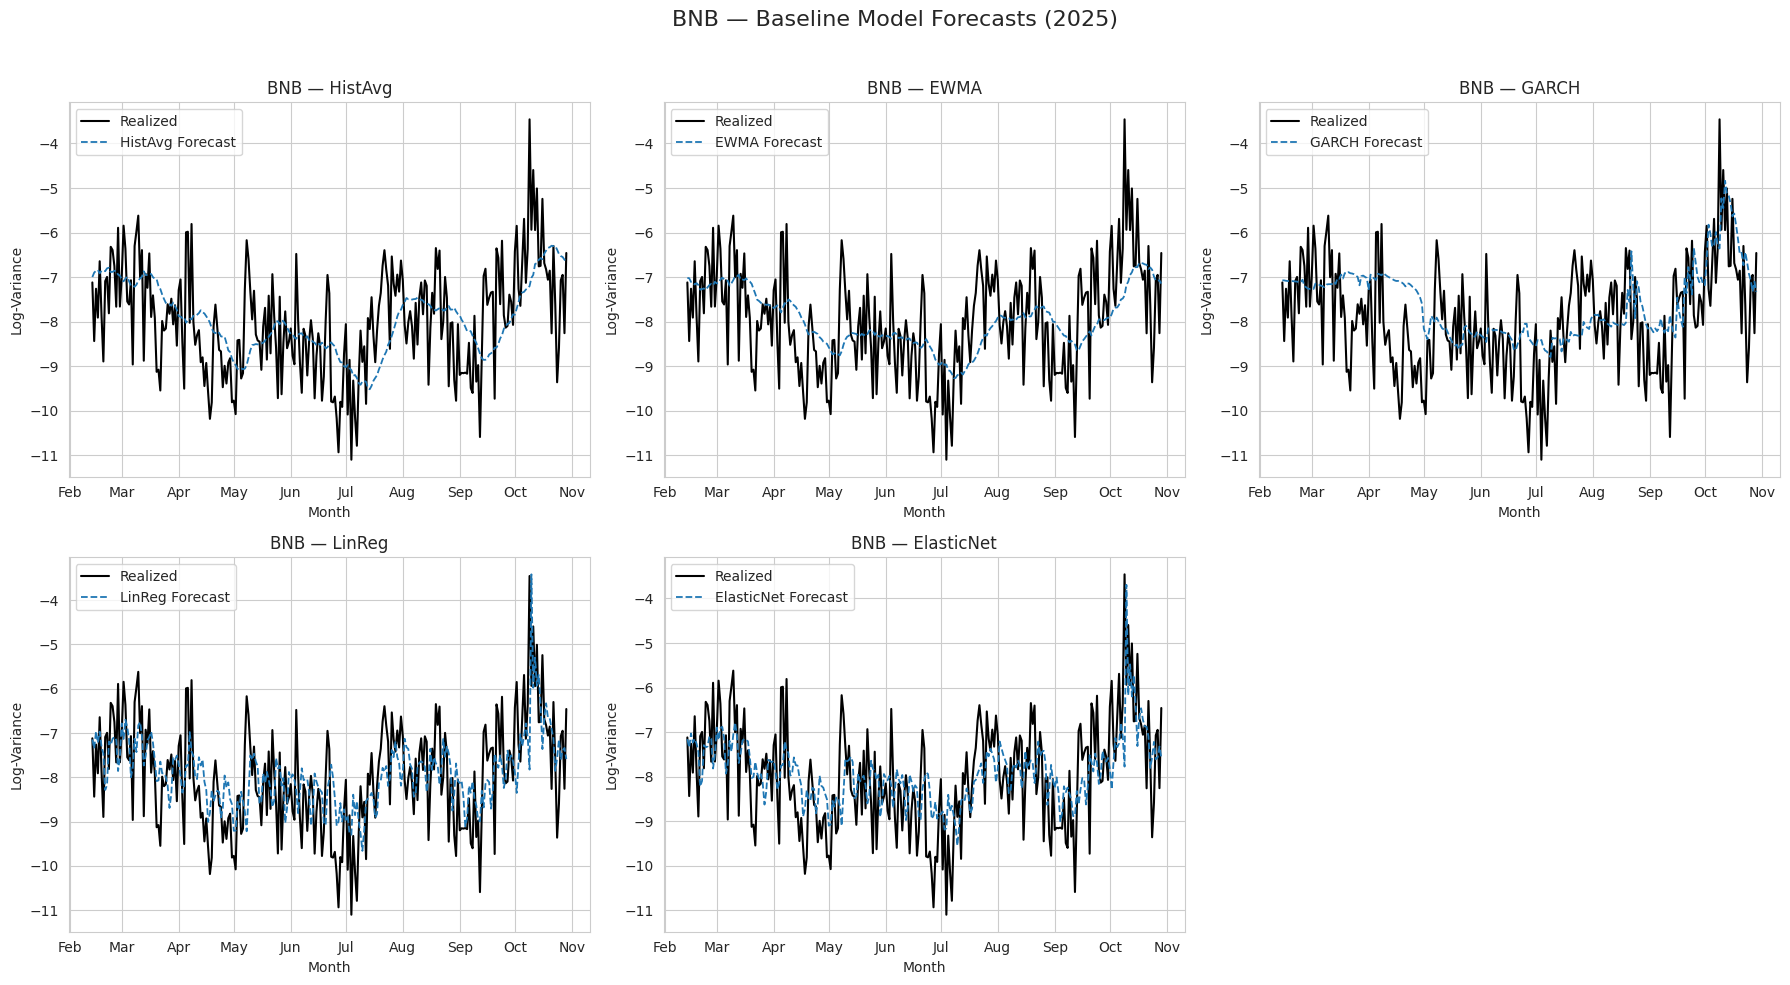


=== Baseline evaluation for BTC ===


/tmp/ipython-input-2557935370.py:77: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp="off", update_freq=0)


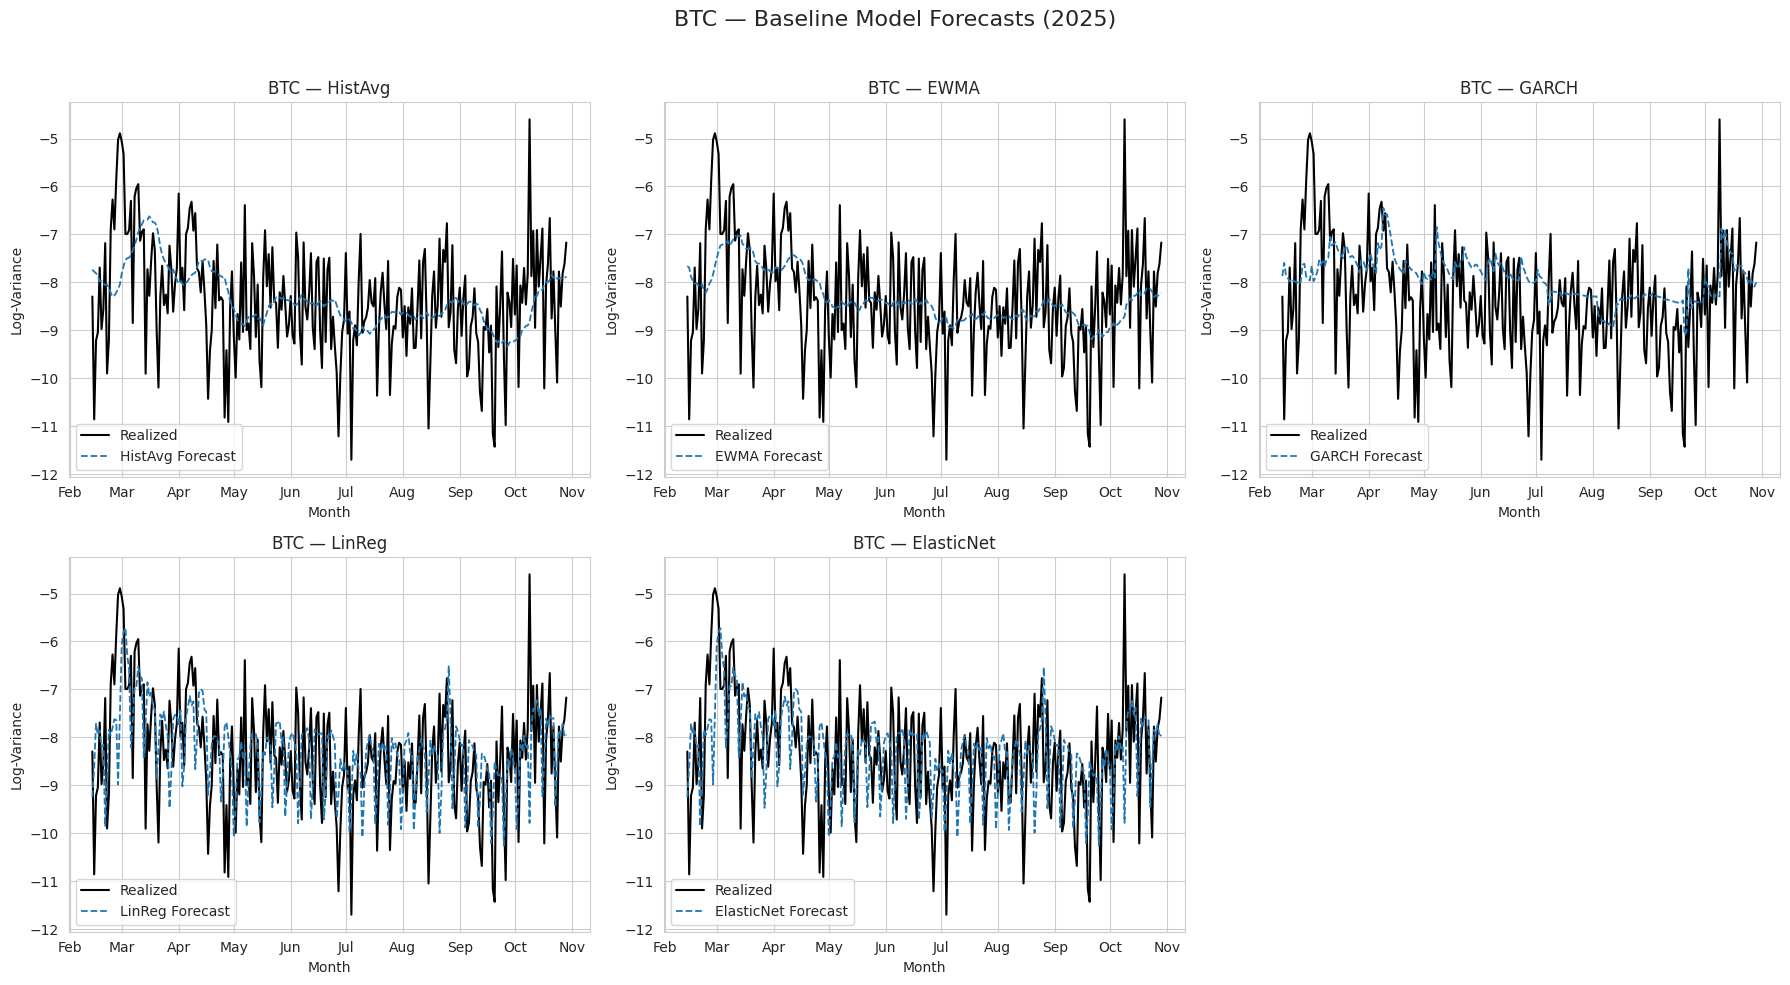


=== Baseline evaluation for ETH ===


/tmp/ipython-input-2557935370.py:77: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp="off", update_freq=0)


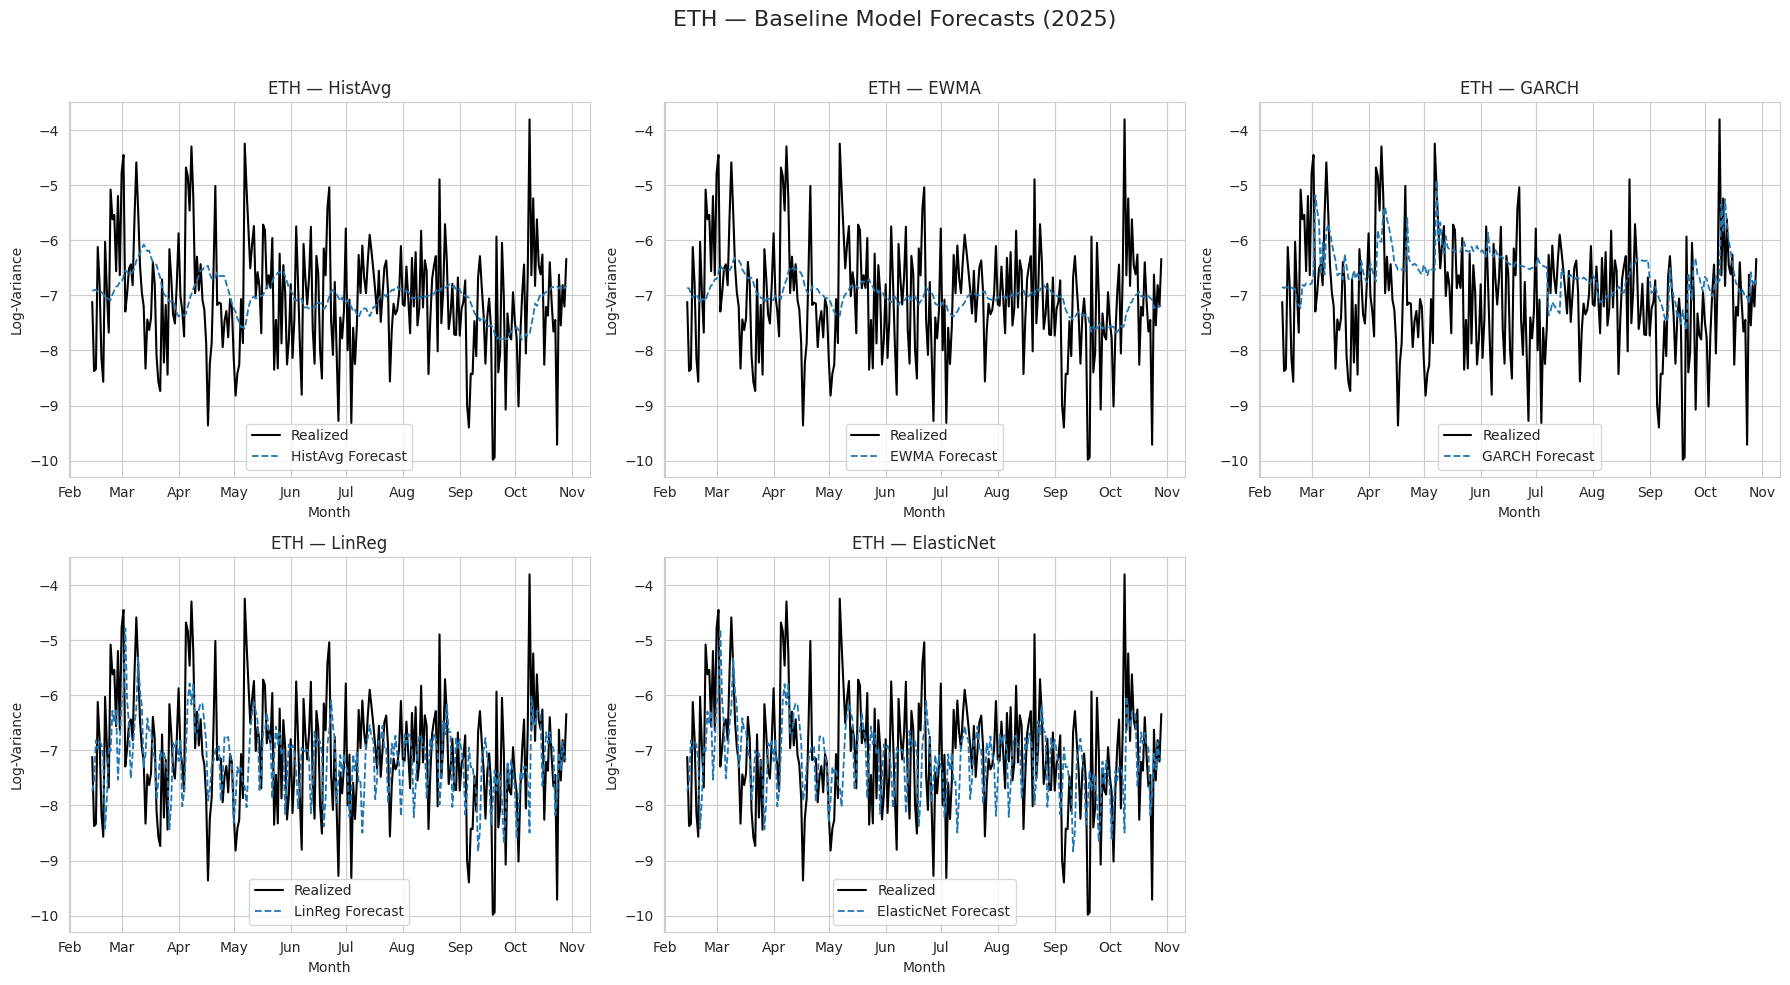


=== Baseline evaluation for SOL ===


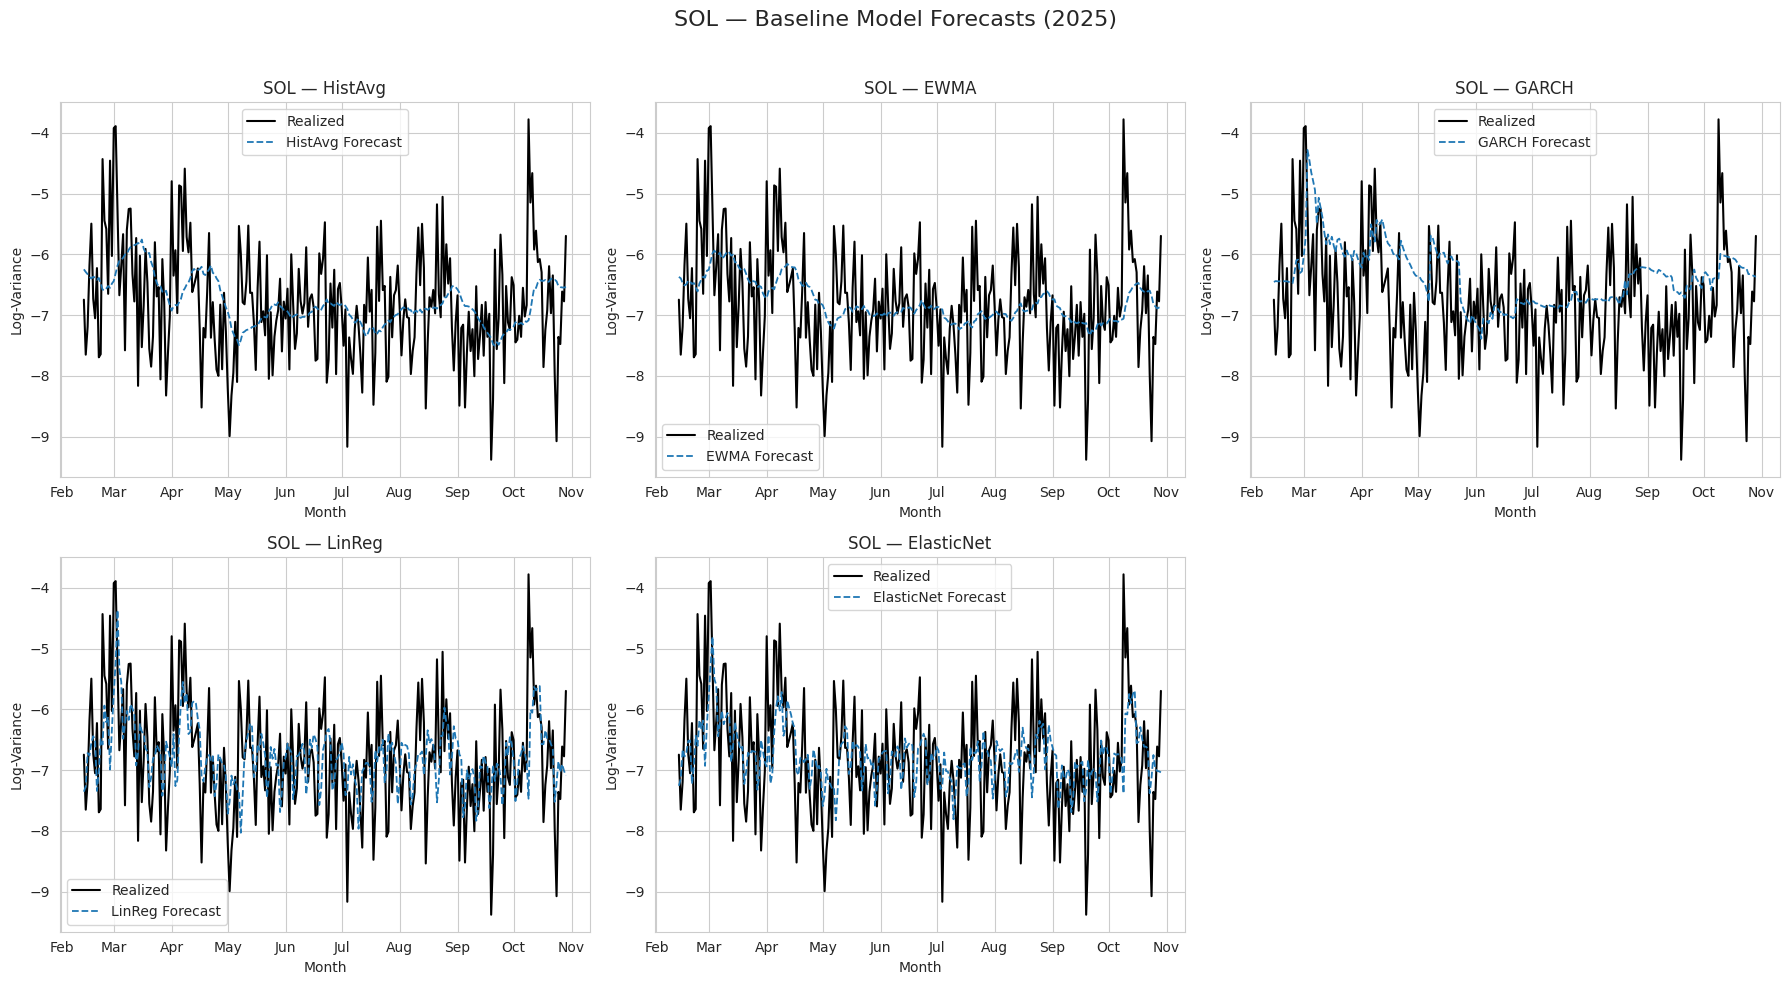


=== Baseline evaluation for XRP ===


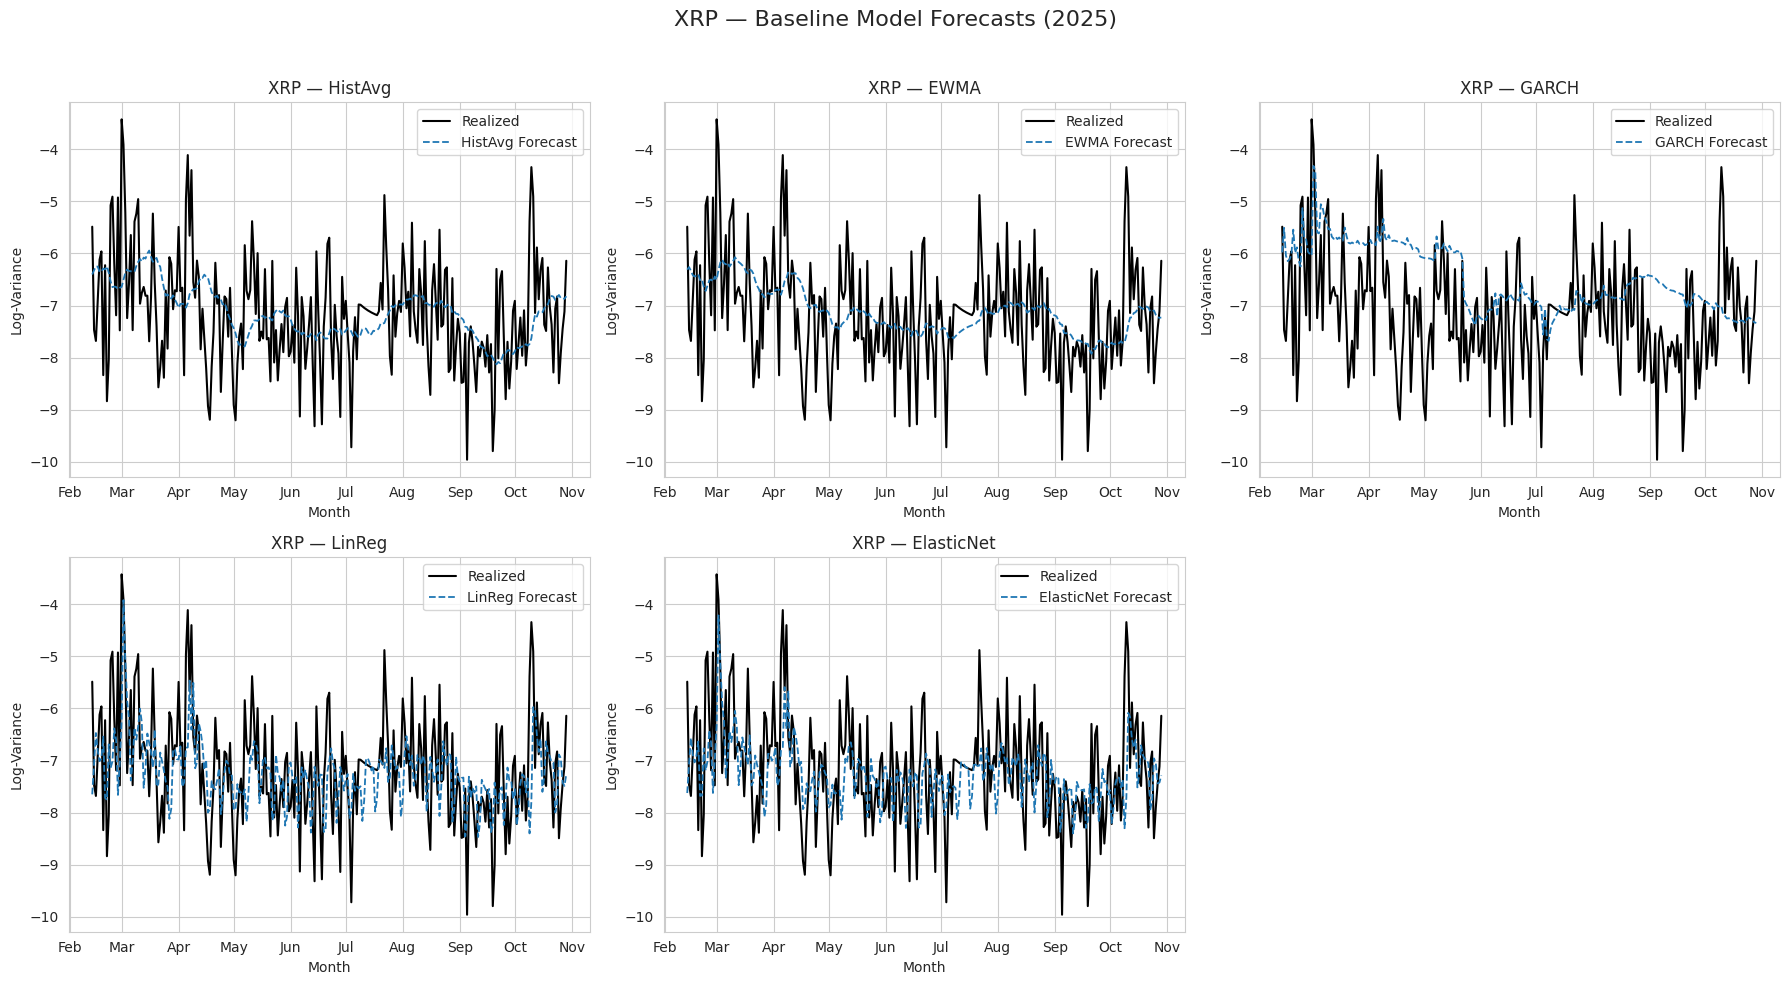


=== Baseline Summary ===


Symbol       Model      MAE     RMSE  LogRMSE     QLIKE  Forecast_Bias
0     BNB     HistAvg 0.009652 0.015862 1.116971 -6.040846  Underforecast
1     BNB        EWMA 0.009306 0.015681 1.072829 -6.103367  Underforecast
2     BNB       GARCH 0.010851 0.015509 1.182377 -6.346516   Overforecast
3     BNB      LinReg 0.009490 0.017087 1.034020 -6.074143  Underforecast
4     BNB  ElasticNet 0.009362 0.016499 1.026820 -6.108167  Underforecast
5     BTC     HistAvg 0.008154 0.013135 1.172583 -6.268246  Underforecast
6     BTC        EWMA 0.007703 0.012439 1.117535 -6.452555  Underforecast
7     BTC       GARCH 0.008788 0.013096 1.242062 -6.514057   Overforecast
8     BTC      LinReg 0.007829 0.012377 1.182862 -5.671426  Underforecast
9     BTC  ElasticNet 0.007827 0.012371 1.182359 -5.675852  Underforecast
10    ETH     HistAvg 0.014047 0.021338 1.091565 -5.085268  Underforecast
11    ETH        EWMA 0.013429 0.020594 1.043845 -5.223084  Underforecast
12    ETH       GARCH 0.015919 0.021133 1.159411 -5.429010   Overforecast
13    ETH      LinReg 0.013673 0.020837 1.093128 -4.712941  Underforecast
14    ETH  ElasticNet 0.013667 0.020825 1.092427 -4.715648  Underforecast
15    SOL     HistAvg 0.013921 0.021263 0.965436 -5.156655  Underforecast
16    SOL        EWMA 0.013246 0.020388 0.920223 -5.236794  Underforecast
17    SOL       GARCH 0.016203 0.022263 1.057657 -5.317695   Overforecast
18    SOL      LinReg 0.013005 0.019624 0.894634 -5.197102  Underforecast
19    SOL  ElasticNet 0.012896 0.019519 0.892207 -5.224438  Underforecast
20    XRP     HistAvg 0.013615 0.021695 1.061021 -5.322753  Underforecast
21    XRP        EWMA 0.013167 0.021020 1.027581 -5.414754  Underforecast
22    XRP       GARCH 0.017671 0.023274 1.294510 -5.520517   Overforecast
23    XRP      LinReg 0.012825 0.020323 1.030905 -5.259967  Underforecast
24    XRP  ElasticNet 0.012734 0.020307 1.019480 -5.287796  Underforecast


Baseline prediction series stored in BASELINE_PREDS:
 BNB: ['HistAvg', 'EWMA', 'GARCH', 'LinReg', 'ElasticNet']
 BTC: ['HistAvg', 'EWMA', 'GARCH', 'LinReg', 'ElasticNet']
 ETH: ['HistAvg', 'EWMA', 'GARCH', 'LinReg', 'ElasticNet']
 SOL: ['HistAvg', 'EWMA', 'GARCH', 'LinReg', 'ElasticNet']
 XRP: ['HistAvg', 'EWMA', 'GARCH', 'LinReg', 'ElasticNet']


In [ ]:
# ============================================================
# SECTION 8 — Baseline Volatility Models
# Target: next-day Yang–Zhang log-variance (y_logvar)
# Baselines: HistAvg, EWMA, GARCH(1,1), Linear Regression, ElasticNet
#
# This section evaluates standard benchmark volatility models
# and stores their out-of-sample forecasts for later
# economic value and portfolio analysis.
# ============================================================

# List of crypto assets to be evaluated (panel structure)
CRYPTO_SYMBOLS = sorted(panel_df["Symbol"].unique())

# Small constant used to ensure numerical stability
# (avoids log(0) or division by zero)
EPS = 1e-10

# ROLLING BASELINES MODELS (logvar-based)
def baseline_historical_avg_logvar_next(series, window=21):
    """
    Historical Average (HA) baseline.

    Computes a rolling mean of past log-variance values
    using a fixed lookback window.

    IMPORTANT:
    - The value at index t is interpreted as the forecast
      for day t+1 (no explicit shift is applied).
    - This aligns with the target y_logvar defined as
      next-day log-variance.
    """
    out = series.rolling(window, min_periods=1).mean()
    return out.bfill()  # no explicit shift here

def baseline_ewma_logvar_next(series, alpha=0.06):
    """
    Exponentially Weighted Moving Average (EWMA) baseline.

    Applies exponential decay to past log-variance observations.
    Recent observations receive higher weight.

    alpha = 0.06 corresponds to RiskMetrics-style decay.

    As with HA:
    - The value at index t is interpreted as the forecast
      for day t+1.
    """
    out = series.ewm(alpha=alpha, adjust=False).mean()
    return out.bfill()  # no explicit shift here

# GARCH(1,1) baseline on returns
def compute_garch_logvar_forecast_next(logret_series, window=100, min_obs=50):
    """
    Rolling GARCH(1,1) volatility forecast.

    - The model is estimated on rolling windows of past returns.
    - At each time t, the fitted GARCH model produces a
      one-step-ahead variance forecast (t+1).
    - Forecasts are converted to log-variance and aligned
      with index t.

    Parameters:
    - window: length of rolling estimation window
    - min_obs: minimum observations required to fit GARCH
               (prevents unstable estimation)
    """
    out = pd.Series(np.nan, index=logret_series.index)
    N = len(logret_series)
    # Use only past returns up to time t
    for t in range(window - 1, N):
        sample = logret_series.iloc[t-window+1:t+1].dropna()
        if len(sample) < min_obs:
            continue
        try:
            # Scale returns to percentage points for numerical stability
            am = arch_model(sample * 100, mean="Zero", p=1, q=1, vol="GARCH")
            res = am.fit(disp="off", update_freq=0)
            # One-step-ahead variance forecast
            f = res.forecast(horizon=1, reindex=False)
            var_next = f.variance.values[-1, 0] / (100**2)
            # Store log-variance forecast
            out.iloc[t] = np.log(max(var_next, EPS))
        except Exception:
            # In case of convergence or numerical issues
            out.iloc[t] = np.nan
    return out

# FORECAST EVALUATION METRICS
def qlike(y_true_logvar, y_pred_logvar):
    """
    QLIKE loss function.

    - Robust to measurement error in realized volatility
    - Penalizes under-forecasting more heavily
    - Standard metric in volatility forecasting literature
    """
    true_var = np.exp(y_true_logvar)
    pred_var = np.exp(y_pred_logvar).clip(EPS)
    return np.mean(np.log(pred_var) + true_var / pred_var)

def log_mse(y_true, y_pred):
    """Mean squared error in log-variance space."""
    return np.mean((y_true - y_pred)**2)

def vol_mae(y_true_logvar, y_pred_logvar):
    """
    Mean Absolute Error computed in volatility space.
    Converts log-variance forecasts to volatility.
    """
    y_true_vol = np.sqrt(np.exp(y_true_logvar))
    y_pred_vol = np.sqrt(np.exp(y_pred_logvar))
    return np.mean(np.abs(y_true_vol - y_pred_vol))

def vol_rmse(y_true_logvar, y_pred_logvar):
    """
    Root Mean Squared Error in volatility space.
    """
    y_true_vol = np.sqrt(np.exp(y_true_logvar))
    y_pred_vol = np.sqrt(np.exp(y_pred_logvar))
    return np.sqrt(np.mean((y_true_vol - y_pred_vol)**2))

# MAIN EVALUATION LOOP + GLOBAL STORAGE
# Stores summary metrics across all symbols and models
summary_list = []

# Stores full out-of-sample forecast series
# Used later for portfolio construction and economic value analysis
BASELINE_PREDS = {}   # <- this will be used later in Section 16D

for sym in CRYPTO_SYMBOLS:
    print(f"\n=== Baseline evaluation for {sym} ===")

    # Per-symbol data from the main panel
    df_sym = (
        panel_df[panel_df["Symbol"] == sym]
        .copy()
        .sort_values("Date")
        .reset_index(drop=True)
    )

     # Ensure Date is timezone-naive for plotting and alignment
    df_sym["Date"] = pd.to_datetime(df_sym["Date"], errors="coerce")
    if hasattr(df_sym["Date"].dt, "tz_localize"):
        try:
            df_sym["Date"] = df_sym["Date"].dt.tz_localize(None)
        except TypeError:
            # already naive
            pass

    # Train / Test split from the Split column
    train_sym = df_sym[df_sym["Split"] == "Train"].copy()
    test_sym  = df_sym[df_sym["Split"] == "Test"].copy()

    # We only evaluate where target is available
    test_sym = test_sym[test_sym["y_logvar"].notna()].copy()

    if len(test_sym) < 30:
        print(f"Insufficient test data for {sym}, skipping.")
        BASELINE_PREDS[sym] = {}
        continue

    # Build combined series for rolling hist / EWMA / GARCH
    # (Train + Test concatenated)
    combined_logvar = pd.concat(
        [train_sym["logvar"], test_sym["logvar"]],
        ignore_index=True
    )
    combined_r = pd.concat(
        [train_sym["r"], test_sym["r"]],
        ignore_index=True
    )
    # Index where test period begins
    test_start_idx = len(train_sym)

    # Baseline forecasts in logvar space
    hist_series  = baseline_historical_avg_logvar_next(combined_logvar)
    ewma_series  = baseline_ewma_logvar_next(combined_logvar)
    garch_series = compute_garch_logvar_forecast_next(combined_r)

    # Align forecasts with test period
    test_sym["HistAvg"] = hist_series.iloc[test_start_idx:].values
    test_sym["EWMA"]    = ewma_series.iloc[test_start_idx:].values
    test_sym["GARCH"]   = garch_series.iloc[test_start_idx:].values

    # LINEAR REGRESSION & ELASTIC NET BASELINES
    # One-step-ahead alignment:
    # X_t predicts y_(t+1)
    X_train_lr = train_sym[features].iloc[:-1].values
    y_train_lr = train_sym["y_logvar"].iloc[1:].values
    X_test_lr  = test_sym[features].values

    # Standardization is required for linear models
    scaler_lr = StandardScaler()
    X_train_lr_scaled = scaler_lr.fit_transform(X_train_lr)
    X_test_lr_scaled  = scaler_lr.transform(X_test_lr)

    # Ordinary Least Squares (OLS)
    lr = LinearRegression()
    lr.fit(X_train_lr_scaled, y_train_lr)
    test_sym["LinReg"] = lr.predict(X_test_lr_scaled)

    # Elastic Net with 5-fold cross-validation
    enet = ElasticNetCV(l1_ratio=0.5, cv=5, random_state=42)
    enet.fit(X_train_lr_scaled, y_train_lr)
    test_sym["ElasticNet"] = enet.predict(X_test_lr_scaled)

    # EVALUATION METRICS
    # Evaluate + store metrics
    baseline_models = ["HistAvg", "EWMA", "GARCH", "LinReg", "ElasticNet"]

    for model in baseline_models:
        mask = test_sym[model].notna()
        if mask.sum() == 0:
            continue

        y_true_log = test_sym.loc[mask, "y_logvar"]
        y_pred_log = test_sym.loc[mask, model]

        summary_list.append({
            "Symbol": sym,
            "Model": model,
            "MAE": vol_mae(y_true_log, y_pred_log),
            "RMSE": vol_rmse(y_true_log, y_pred_log),
            "LogRMSE": np.sqrt(log_mse(y_true_log, y_pred_log)),
            "QLIKE": qlike(y_true_log, y_pred_log),
            "Forecast_Bias":
                "Overforecast"
                if (np.sqrt(np.exp(y_pred_log)) - np.sqrt(np.exp(y_true_log))).mean() > 0
                else "Underforecast"
        })

    # Store per-model time series for economic value analysis
    BASELINE_PREDS[sym] = {}
    for model in baseline_models:
        if model not in test_sym.columns:
            continue
        ser = test_sym[["Date", model]].dropna()
        BASELINE_PREDS[sym][model] = pd.Series(
            ser[model].values,
            index=ser["Date"]
        )

    # PLOTTING
    # Visualization per symbol
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    models = baseline_models
    month_locator = mdates.MonthLocator()              # show months
    month_fmt = mdates.DateFormatter("%b")             # month number (01–12)

    for i, model in enumerate(models):
        ax = axes[i]
        ax.plot(test_sym["Date"], test_sym["y_logvar"],
                label="Realized", color="black", lw=1.5)
        ax.plot(test_sym["Date"], test_sym[model],
                label=f"{model} Forecast", lw=1.3, linestyle="--")

        ax.set_title(f"{sym} — {model}")
        ax.set_xlabel("Month")
        ax.set_ylabel("Log-Variance")
        ax.legend()
        ax.xaxis.set_major_locator(month_locator)
        ax.xaxis.set_major_formatter(month_fmt)

    for j in range(len(models), 6):
        axes[j].axis("off")

    plt.suptitle(f"{sym} — Baseline Model Forecasts (2025)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# RESULTS
# Final summary table (ALL symbols, ALL baselines)
df_baseline_summary = pd.DataFrame(summary_list)

print("\n=== Baseline Summary ===")
display(df_baseline_summary.round(6))

print("\nBaseline prediction series stored in BASELINE_PREDS:")
for sym in CRYPTO_SYMBOLS:
    print(f" {sym}: {list(BASELINE_PREDS[sym].keys())}")



=== ML Forecasting for BTC ===


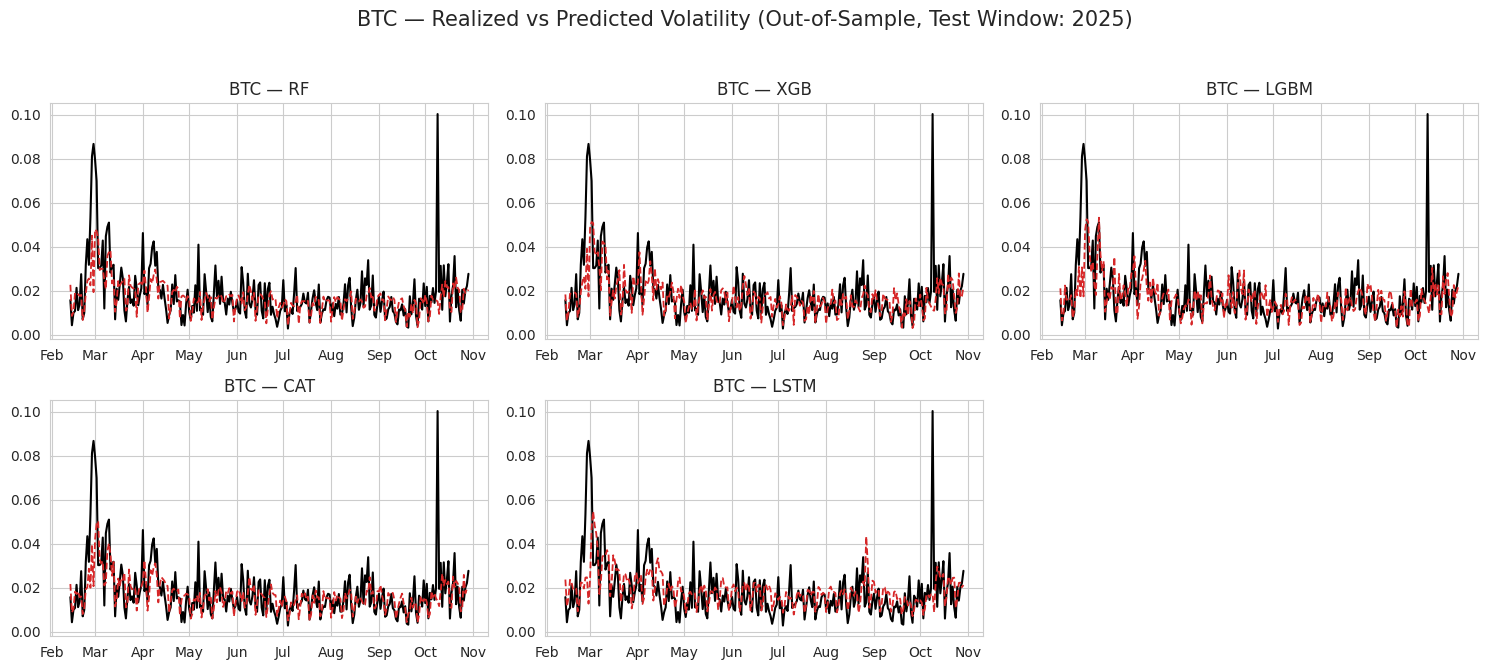


=== ML Forecasting for ETH ===


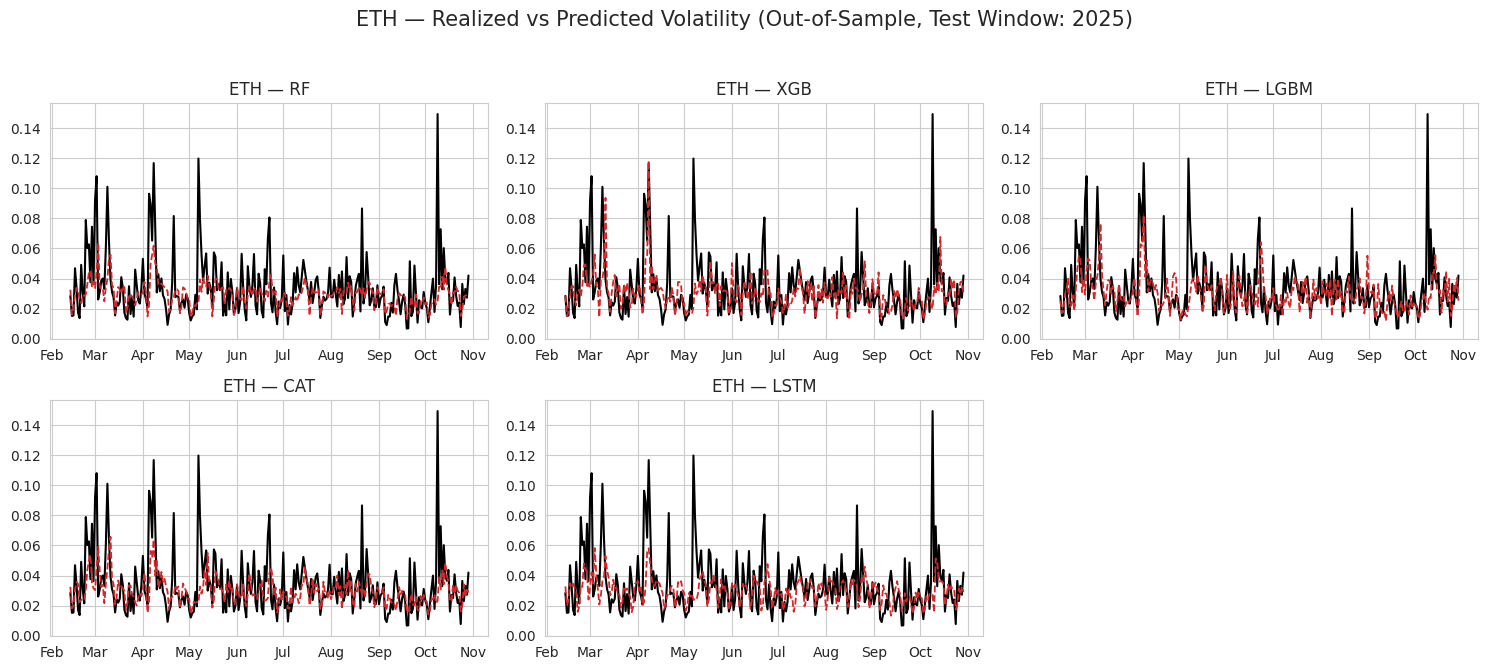


=== ML Forecasting for BNB ===


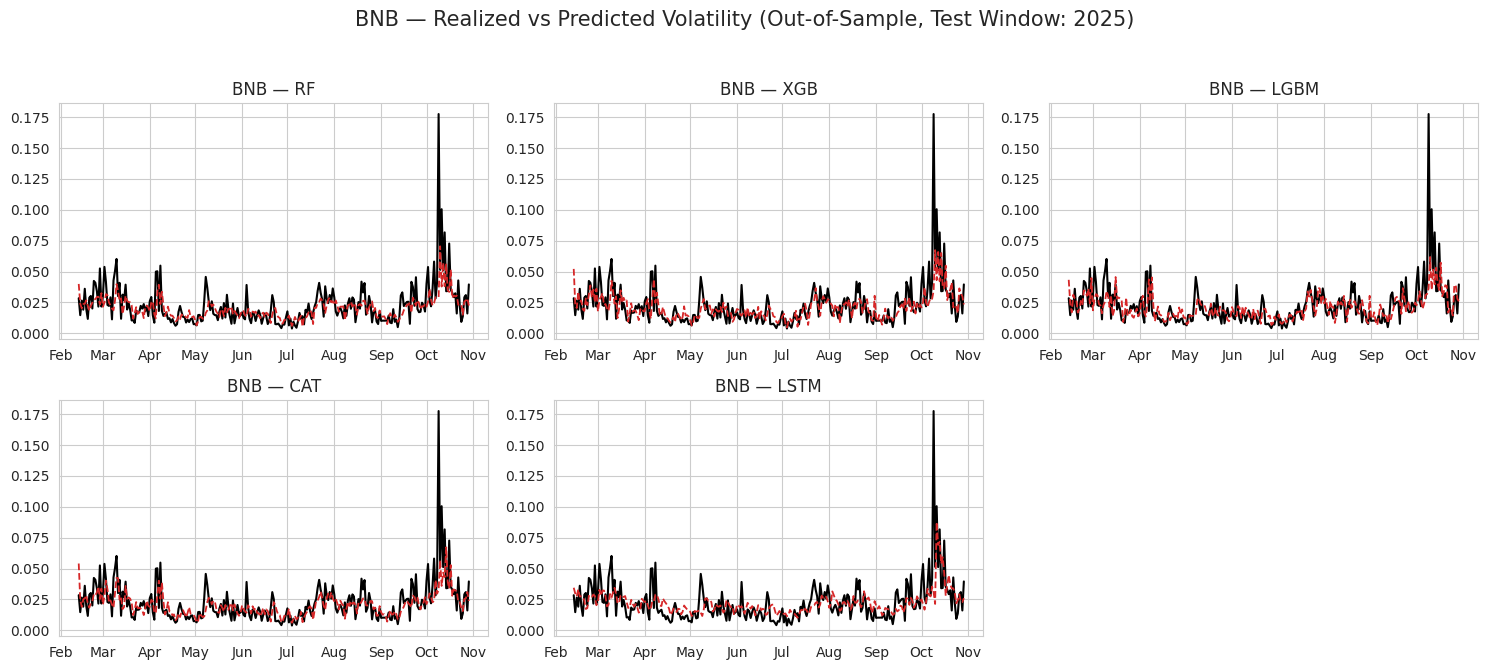


=== ML Forecasting for SOL ===


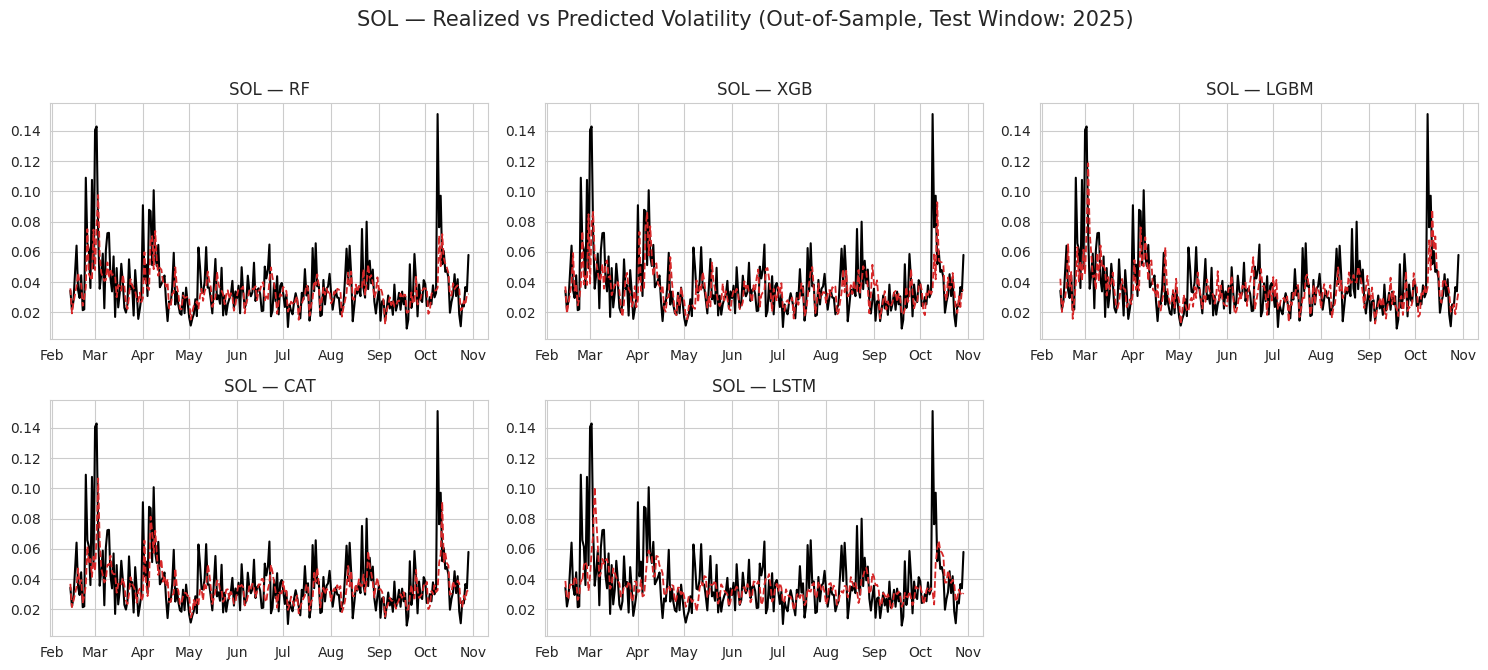


=== ML Forecasting for XRP ===


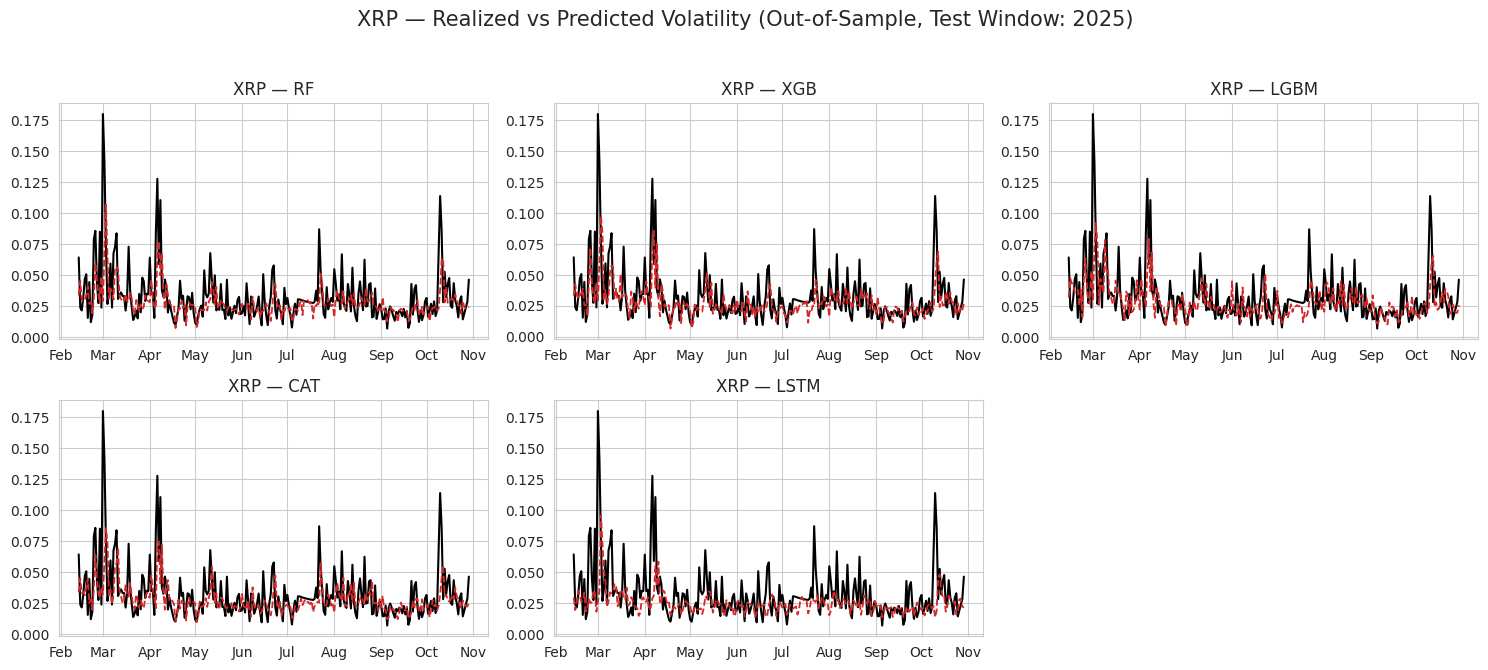


=== ML Model Performance Summary ===


Symbol Model      MAE     RMSE  LogRMSE     QLIKE  Forecast_Bias Best_ML
14    BNB  LSTM 0.008741 0.013958 1.007139 -6.372305  Underforecast     Yes
13    BNB   CAT 0.008422 0.014477 0.929245 -6.371331  Underforecast        
10    BNB    RF 0.008460 0.014627 0.951960 -6.306327  Underforecast        
11    BNB   XGB 0.008775 0.014657 0.984859 -6.305965  Underforecast        
12    BNB  LGBM 0.008983 0.014817 0.994198 -6.308463  Underforecast        
0     BTC    RF 0.006807 0.010700 0.943815 -6.711402  Underforecast     Yes
3     BTC   CAT 0.006799 0.010846 0.932186 -6.694367  Underforecast        
1     BTC   XGB 0.007249 0.011280 1.001766 -6.485058  Underforecast        
2     BTC  LGBM 0.007190 0.011406 1.014922 -6.492252  Underforecast        
4     BTC  LSTM 0.007580 0.011963 1.033152 -6.643511   Overforecast        
5     ETH    RF 0.011790 0.019140 0.906603 -5.312599  Underforecast     Yes
8     ETH   CAT 0.012363 0.019539 0.939918 -5.244404  Underforecast        
9     ETH  LSTM 0.012532 0.019622 0.967253 -5.255509  Underforecast        
6     ETH   XGB 0.012605 0.019872 0.969048 -5.163236  Underforecast        
7     ETH  LGBM 0.012873 0.020000 0.986545 -5.098755  Underforecast        
15    SOL    RF 0.011843 0.018497 0.800367 -5.370287  Underforecast     Yes
18    SOL   CAT 0.012021 0.018935 0.810133 -5.349199  Underforecast        
17    SOL  LGBM 0.012842 0.019517 0.855334 -5.323709  Underforecast        
19    SOL  LSTM 0.012355 0.019580 0.842600 -5.309978  Underforecast        
16    SOL   XGB 0.012870 0.019662 0.856582 -5.296477  Underforecast        
20    XRP    RF 0.012436 0.019940 0.959554 -5.407013  Underforecast     Yes
23    XRP   CAT 0.012586 0.020331 0.965855 -5.407499  Underforecast        
21    XRP   XGB 0.012835 0.020406 0.990369 -5.371895  Underforecast        
22    XRP  LGBM 0.013464 0.020709 1.035842 -5.316550  Underforecast        
24    XRP  LSTM 0.012983 0.022337 1.048077 -4.849430  Underforecast


Stored ML models per symbol:
BTC → ['Date', 'ActualLogVar', 'RF_logvar', 'XGB_logvar', 'LGBM_logvar', 'CAT_logvar', 'LSTM_logvar', 'RF_vol', 'XGB_vol', 'LGBM_vol', 'CAT_vol', 'LSTM_vol', 'Symbol']
ETH → ['Date', 'ActualLogVar', 'RF_logvar', 'XGB_logvar', 'LGBM_logvar', 'CAT_logvar', 'LSTM_logvar', 'RF_vol', 'XGB_vol', 'LGBM_vol', 'CAT_vol', 'LSTM_vol', 'Symbol']
BNB → ['Date', 'ActualLogVar', 'RF_logvar', 'XGB_logvar', 'LGBM_logvar', 'CAT_logvar', 'LSTM_logvar', 'RF_vol', 'XGB_vol', 'LGBM_vol', 'CAT_vol', 'LSTM_vol', 'Symbol']
SOL → ['Date', 'ActualLogVar', 'RF_logvar', 'XGB_logvar', 'LGBM_logvar', 'CAT_logvar', 'LSTM_logvar', 'RF_vol', 'XGB_vol', 'LGBM_vol', 'CAT_vol', 'LSTM_vol', 'Symbol']
XRP → ['Date', 'ActualLogVar', 'RF_logvar', 'XGB_logvar', 'LGBM_logvar', 'CAT_logvar', 'LSTM_logvar', 'RF_vol', 'XGB_vol', 'LGBM_vol', 'CAT_vol', 'LSTM_vol', 'Symbol']


In [ ]:
# ============================================================
# SECTION 9 — ML Models (Out-of-sample test window, no refitting)
# Target: Next-day log-variance
# Models: RF, XGB, LGBM, CatBoost, LSTM
#
# IMPORTANT:
# - All ML models are trained ONCE on the training set
# - No refitting or rolling updates are performed
# - All forecasts are strictly out-of-sample
# ============================================================

# Fixed list of crypto assets analyzed
CRYPTO_SYMBOLS = ["BTC", "ETH", "BNB", "SOL", "XRP"]

# Global random seed for reproducibility across:
# - NumPy
# - TensorFlow
# - Tree-based ML models
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# LSTM
# LSTM hyperparameters
LSTM_SEQ_LEN = 21      # length of rolling input sequence (≈ 1 month)
LSTM_EPOCHS = 15       # maximum number of training epochs
LSTM_UNITS = 48        # number of hidden units in LSTM cell
# Numerical stability constant
EPS = 1e-12

# LSTM builder
def create_lstm(seq_len, n_features, units=LSTM_UNITS):
    """
    Builds a simple LSTM architecture for volatility forecasting.

    Architecture:
    - Single LSTM layer (memory over past sequence)
    - Dropout for regularization
    - Dense layers to map hidden state to log-variance forecast

    Output:
    - Single scalar: next-day log-variance
    """
    model = Sequential([
        LSTM(units, input_shape=(seq_len, n_features)),
        Dropout(0.15),
        Dense(24, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# EVALUATION METRICS
def qlike_from_vars(y_true_var, y_pred_var):
    """
    QLIKE loss computed directly in variance space.

    - Robust to measurement error in realized volatility
    - Penalizes under-forecasting more heavily
    """
    y_true = np.array(y_true_var) + EPS
    y_pred = np.array(y_pred_var) + EPS
    return np.mean(np.log(y_pred) + y_true / y_pred)

def logvar_rmse(y_true_log, y_pred_log):
    """
    Root Mean Squared Error in log-variance space.
    """
    mask = np.isfinite(y_true_log) & np.isfinite(y_pred_log)
    return np.sqrt(np.mean((y_true_log[mask] - y_pred_log[mask])**2))

# MODEL FACTORIES (TREE BASED ML)
# Each lambda returns a fresh, untrained model instance.
# This ensures identical hyperparameters across assets
# and avoids accidental state sharing.
MODEL_SPECS = {
    "RF": lambda: RandomForestRegressor(
        n_estimators=300, max_depth=8,
        random_state=RANDOM_SEED, n_jobs=-1
    ),
    "XGB": lambda: XGBRegressor(
        n_estimators=300, learning_rate=0.04, max_depth=6,
        objective="reg:squarederror", random_state=RANDOM_SEED,
        n_jobs=-1, verbosity=0
    ),
    "LGBM": lambda: LGBMRegressor(
        n_estimators=300, learning_rate=0.04,
        random_state=RANDOM_SEED, verbose=-1
    ),
    "CAT": lambda: CatBoostRegressor(
        iterations=300, learning_rate=0.04, depth=7,
        verbose=0, random_state=RANDOM_SEED
    )
}

# Storage objects
results_all = []         # full prediction DataFrames (used later for ensemble)
ml_summary_records = []  # per-symbol, per-model performance metrics
ML_PREDS = {}            # cleaned prediction storage for portfolio analysis

# MAIN LOOP — Train/Test all ML models per asset
for sym in CRYPTO_SYMBOLS:
    print(f"\n=== ML Forecasting for {sym} ===")
    # Extract and sort per-symbol panel data
    df_sym = (
        panel_df[panel_df["Symbol"] == sym]
        .copy()
        .sort_values("Date")
        .reset_index(drop=True)
    )

    # Ensure all required predictors and target are available
    valid_cols = features + ["y_logvar"]
    df_sym = df_sym.dropna(subset=valid_cols).reset_index(drop=True)

    # Predefined train/test split (created earlier in pipeline)
    train_df = df_sym[df_sym["Split"] == "Train"].copy()
    test_df  = df_sym[df_sym["Split"] == "Test"].copy()

    # Basic data sufficiency check
    if len(train_df) < 60 or len(test_df) < 30:
        print(f"Insufficient data for {sym}. Skipping.")
        continue

    # Feature matrices and targets
    X_train = train_df[features].values
    y_train = train_df["y_logvar"].values

    X_test  = test_df[features].values
    y_test  = test_df["y_logvar"].values
    test_dates = test_df["Date"].values

    # Container for predictions
    preds_df = pd.DataFrame({
        "Date": test_dates,
        "ActualLogVar": y_test
    })

    # TREE BASED ML MODELS (STATIC, NO REFITTING)
    for name, factory in MODEL_SPECS.items():
        model = factory()
        try:
            # Fit ONLY on training data
            model.fit(X_train, y_train)
            # Predict entire test window in one pass
            preds_df[f"{name}_logvar"] = model.predict(X_test)

        except Exception as e:
            print(f"{sym} {name} failed: {e}")
            preds_df[f"{name}_logvar"] = np.nan

    # LSTM MODEL (SEQUENCE BASED)
    preds_df["LSTM_logvar"] = np.nan
    # Ensure enough observations to form sequences
    if len(X_train) > LSTM_SEQ_LEN + 30:

        # Scale features for neural network stability
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        # Build rolling sequences of length LSTM_SEQ_LEN
        seq_X = np.array([
            X_train_scaled[i-LSTM_SEQ_LEN:i]
            for i in range(LSTM_SEQ_LEN, len(X_train))
        ])
        seq_y = y_train[LSTM_SEQ_LEN:]

        # Early stopping to avoid overfitting
        es = tf.keras.callbacks.EarlyStopping(
            monitor="loss", patience=3, restore_best_weights=True
        )

        try:
            lstm = create_lstm(LSTM_SEQ_LEN, seq_X.shape[2])
            lstm.fit(seq_X, seq_y, epochs=LSTM_EPOCHS,
                     batch_size=16, verbose=0, callbacks=[es])

            # Build test sequences using last training window
            X_all = np.vstack([X_train[-LSTM_SEQ_LEN:], X_test])
            X_all_scaled = scaler.transform(X_all)
            test_seqs = np.array([
                X_all_scaled[i-LSTM_SEQ_LEN:i]
                for i in range(LSTM_SEQ_LEN, len(X_all_scaled))
            ])

            preds_df["LSTM_logvar"] = lstm.predict(test_seqs, verbose=0).flatten()
        except Exception as e:
            print(f"LSTM failed for {sym}: {e}")

    # Convert predictions to var + vol
    for col in preds_df.columns:
        if col.endswith("_logvar"):
            preds_df[col.replace("_logvar", "_var")] = np.exp(preds_df[col])
            preds_df[col.replace("_logvar", "_vol")] = np.sqrt(np.exp(preds_df[col]))

    preds_df["ActualVar"] = np.exp(preds_df["ActualLogVar"])
    preds_df["ActualVol"] = np.sqrt(preds_df["ActualVar"])

    # Store full df for ensemble section
    results_all.append({"Symbol": sym, "preds_df": preds_df.copy()})

    # BUILD ML_PREDS STORAGE
    # (logvars + vols + date + symbol)
    keep_cols = (
        ["Date", "ActualLogVar"] +
        [c for c in preds_df.columns if c.endswith("_logvar")] +
        [c for c in preds_df.columns if c.endswith("_vol")]
    )

    # Ensure timezone-naive dates for alignment
    df_ml = preds_df[keep_cols].copy()
    df_ml["Symbol"] = sym
    df_ml["Date"] = (
        pd.to_datetime(df_ml["Date"], utc=True)
        .dt.tz_localize(None)
    )

    ML_PREDS[sym] = df_ml.sort_values("Date").reset_index(drop=True)

    #EVALUATION METRICS
    # Compute metrics per ML Model
    for col in preds_df.columns:
        if not col.endswith("_logvar"):
            continue

        name = col.replace("_logvar", "")
        mask = preds_df[col].notna()

        actual_log = preds_df.loc[mask, "ActualLogVar"]
        pred_log   = preds_df.loc[mask, col]

        actual_var = preds_df.loc[mask, "ActualVar"]
        pred_var   = preds_df.loc[mask, col.replace("_logvar", "_var")]

        actual_vol = preds_df.loc[mask, "ActualVol"]
        pred_vol   = preds_df.loc[mask, col.replace("_logvar", "_vol")]

        ml_summary_records.append({
            "Symbol": sym,
            "Model": name,
            "MAE": mean_absolute_error(actual_vol, pred_vol),
            "RMSE": np.sqrt(mean_squared_error(actual_vol, pred_vol)),
            "LogRMSE": logvar_rmse(actual_log, pred_log),
            "QLIKE": qlike_from_vars(actual_var, pred_var),
            "Forecast_Bias":
                "Overforecast" if (pred_vol - actual_vol).mean() > 0 else "Underforecast"
        })

    # PLOTTING
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 7))
    axes = axes.flatten()

    models_to_show = [
        c.replace("_logvar", "")
        for c in preds_df.columns if c.endswith("_logvar")
    ]

    month_locator = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter("%b")

    for i, name in enumerate(models_to_show[:6]):
        ax = axes[i]
        ax.plot(preds_df["Date"], preds_df["ActualVol"], color="black", lw=1.5)
        ax.plot(preds_df["Date"], preds_df[f"{name}_vol"],
                color="tab:red", lw=1.3, linestyle="--")
        ax.set_title(f"{sym} — {name}")
        ax.xaxis.set_major_locator(month_locator)
        ax.xaxis.set_major_formatter(month_fmt)

    while i < 5:
        i += 1
        axes[i].axis("off")

    plt.suptitle(f"{sym} — Realized vs Predicted Volatility (Out-of-Sample, Test Window: 2025)", fontsize=15)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# RESULTS
# Final ML Summary Table
df_ml_summary = pd.DataFrame(ml_summary_records)
df_ml_summary["Best_ML"] = (
    df_ml_summary.groupby("Symbol")["RMSE"]
    .transform(lambda x: x == x.min())
).replace({True: "Yes", False: ""})

print("\n=== ML Model Performance Summary ===")
display(df_ml_summary.sort_values(["Symbol", "RMSE"]).round(6))

print("\nStored ML models per symbol:")
for sym in ML_PREDS:
    print(sym, "→", ML_PREDS[sym].columns.tolist())



=== Baseline vs ML Model Comparison (Aligned Metric: LogRMSE) ===


Symbol                        Model Model_Type      MAE     RMSE  LogRMSE  \
0     BNB                     CatBoost         ML 0.008422 0.014477 0.929245   
1     BNB                 RandomForest         ML 0.008460 0.014627 0.951960   
2     BNB                      XGBoost         ML 0.008775 0.014657 0.984859   
3     BNB                     LightGBM         ML 0.008983 0.014817 0.994198   
4     BNB                         LSTM         ML 0.008741 0.013958 1.007139   
5     BNB        ElasticNet (Baseline)   Baseline 0.009362 0.016499 1.026820   
6     BNB  LinearRegression (Baseline)   Baseline 0.009490 0.017087 1.034020   
7     BNB              EWMA (Baseline)   Baseline 0.009306 0.015681 1.072829   
8     BNB           HistAvg (Baseline)   Baseline 0.009652 0.015862 1.116971   
9     BNB                   GARCH(1,1)   Baseline 0.010851 0.015509 1.182377   
10    BTC                     CatBoost         ML 0.006799 0.010846 0.932186   
11    BTC                 RandomForest         ML 0.006807 0.010700 0.943815   
12    BTC                      XGBoost         ML 0.007249 0.011280 1.001766   
13    BTC                     LightGBM         ML 0.007190 0.011406 1.014922   
14    BTC                         LSTM         ML 0.007580 0.011963 1.033152   
15    BTC              EWMA (Baseline)   Baseline 0.007703 0.012439 1.117535   
16    BTC           HistAvg (Baseline)   Baseline 0.008154 0.013135 1.172583   
17    BTC        ElasticNet (Baseline)   Baseline 0.007827 0.012371 1.182359   
18    BTC  LinearRegression (Baseline)   Baseline 0.007829 0.012377 1.182862   
19    BTC                   GARCH(1,1)   Baseline 0.008788 0.013096 1.242062   
20    ETH                 RandomForest         ML 0.011790 0.019140 0.906603   
21    ETH                     CatBoost         ML 0.012363 0.019539 0.939918   
22    ETH                         LSTM         ML 0.012532 0.019622 0.967253   
23    ETH                      XGBoost         ML 0.012605 0.019872 0.969048   
24    ETH                     LightGBM         ML 0.012873 0.020000 0.986545   
25    ETH              EWMA (Baseline)   Baseline 0.013429 0.020594 1.043845   
26    ETH           HistAvg (Baseline)   Baseline 0.014047 0.021338 1.091565   
27    ETH        ElasticNet (Baseline)   Baseline 0.013667 0.020825 1.092427   
28    ETH  LinearRegression (Baseline)   Baseline 0.013673 0.020837 1.093128   
29    ETH                   GARCH(1,1)   Baseline 0.015919 0.021133 1.159411   
30    SOL                 RandomForest         ML 0.011843 0.018497 0.800367   
31    SOL                     CatBoost         ML 0.012021 0.018935 0.810133   
32    SOL                         LSTM         ML 0.012355 0.019580 0.842600   
33    SOL                     LightGBM         ML 0.012842 0.019517 0.855334   
34    SOL                      XGBoost         ML 0.012870 0.019662 0.856582   
35    SOL        ElasticNet (Baseline)   Baseline 0.012896 0.019519 0.892207   
36    SOL  LinearRegression (Baseline)   Baseline 0.013005 0.019624 0.894634   
37    SOL              EWMA (Baseline)   Baseline 0.013246 0.020388 0.920223   
38    SOL           HistAvg (Baseline)   Baseline 0.013921 0.021263 0.965436   
39    SOL                   GARCH(1,1)   Baseline 0.016203 0.022263 1.057657   
40    XRP                 RandomForest         ML 0.012436 0.019940 0.959554   
41    XRP                     CatBoost         ML 0.012586 0.020331 0.965855   
42    XRP                      XGBoost         ML 0.012835 0.020406 0.990369   
43    XRP        ElasticNet (Baseline)   Baseline 0.012734 0.020307 1.019480   
44    XRP              EWMA (Baseline)   Baseline 0.013167 0.021020 1.027581   
45    XRP  LinearRegression (Baseline)   Baseline 0.012825 0.020323 1.030905   
46    XRP                     LightGBM         ML 0.013464 0.020709 1.035842   
47    XRP                         LSTM         ML 0.012983 0.022337 1.048077   
48    XRP           HistAvg (Baseline)   Baseline 0.013615 0.021695 1.061021   
49 

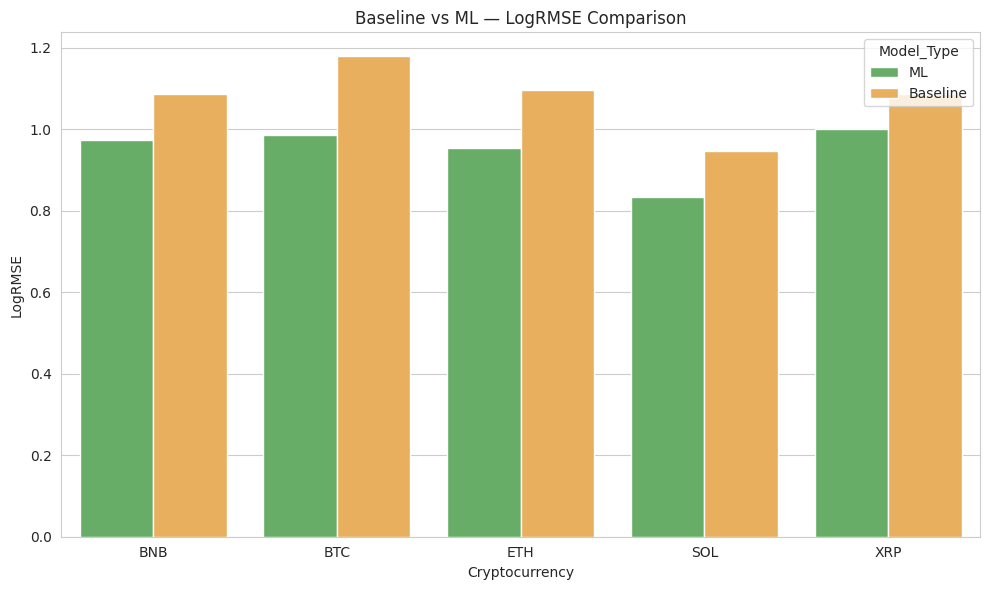


=== Global Best-Model Comparison (Per Symbol) ===
Average LogRMSE, Best Baseline : 1.019978
Average LogRMSE, Best ML       : 0.905591
Global Improvement (Baseline → ML): 11.21%


In [ ]:
# ============================================================
# SECTION 10 — Baseline vs ML Models: Comparative Performance
#
# This section compares baseline econometric models and
# machine learning models using a common evaluation metric.
#
# Target metric: LogRMSE
# Rationale:
# - Ensures comparability across models operating in log-variance space
# - Reduces sensitivity to extreme volatility spikes
# ============================================================
# ============================================================

# PREPARE ML RESULTS
# Copy ML summary table to avoid accidental modification
ml_compare = df_ml_summary.copy()
# Label model category
ml_compare["Model_Type"] = "ML"
# Standardize model naming for presentation
ml_compare["Model"] = ml_compare["Model"].replace({
    "RF": "RandomForest",
    "XGB": "XGBoost",
    "LGBM": "LightGBM",
    "CAT": "CatBoost",
    "LSTM": "LSTM"
})

# PREPARE BASELINE RESULTS
# Copy baseline summary table
baseline_compare = df_baseline_summary.copy()
# Label model category
baseline_compare["Model_Type"] = "Baseline"
# Standardize baseline model naming
baseline_compare["Model"] = baseline_compare["Model"].replace({
    "HistAvg": "HistAvg (Baseline)",
    "EWMA": "EWMA (Baseline)",
    "GARCH": "GARCH(1,1)",
    "ElasticNet": "ElasticNet (Baseline)",
    "LinReg": "LinearRegression (Baseline)"
})
# Remove any legacy flags not needed for cross-model comparison
baseline_compare = baseline_compare.drop(
    columns=[c for c in ["Best_Model"] if c in baseline_compare], errors="ignore"
)

# COMBINE BASELINE AND ML RESULTS
# Combine datasets
df_compare = pd.concat([baseline_compare, ml_compare], ignore_index=True)

# ALIGN EVALUATION METRICS
# Use LogRMSE uniformly
df_compare["RMSE_to_compare"] = df_compare["LogRMSE"]

# IDENTIFY BEST-PERFORMING MODEL PER SYMBOL
# Best model
df_compare["Best_Overall"] = (
    df_compare.groupby("Symbol")["RMSE_to_compare"]
              .transform(lambda x: x == x.min())
).map({True: "Yes", False: ""})
# Sort for interpretability
df_compare = df_compare.sort_values(["Symbol", "RMSE_to_compare"]).reset_index(drop=True)

#VISUALIZATION
# Display table
print("\n=== Baseline vs ML Model Comparison (Aligned Metric: LogRMSE) ===")
display(
    df_compare[[
        "Symbol","Model","Model_Type",
        "MAE","RMSE","LogRMSE","QLIKE",
        "Forecast_Bias","Best_Overall"
    ]].round(6)
)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_compare,
    x="Symbol",
    y="RMSE_to_compare",
    hue="Model_Type",
    ci=None,
    palette={"Baseline": "#ffb347", "ML": "#5cb85c"}
)
plt.title("Baseline vs ML — LogRMSE Comparison")
plt.xlabel("Cryptocurrency")
plt.ylabel("LogRMSE")
plt.tight_layout()
plt.show()

# GLOBAL IMPROVEMENT METRIC
# Compute best baseline and best ML per asset
# Best baseline model
best_baseline = (
    df_compare[df_compare["Model_Type"]=="Baseline"]
    .groupby("Symbol")["RMSE_to_compare"]
    .min()
)
# Best ML model
best_ml = (
    df_compare[df_compare["Model_Type"]=="ML"]
    .groupby("Symbol")["RMSE_to_compare"]
    .min()
)
# Compute average LogRMSE across assets
global_baseline_mean = best_baseline.mean()
global_ml_mean = best_ml.mean()
# Percentage improvement from Baseline to ML
global_improvement = 100 * (global_baseline_mean - global_ml_mean) / global_baseline_mean
# Summary
print("\n=== Global Best-Model Comparison (Per Symbol) ===")
print(f"Average LogRMSE, Best Baseline : {global_baseline_mean:.6f}")
print(f"Average LogRMSE, Best ML       : {global_ml_mean:.6f}")
print(f"Global Improvement (Baseline → ML): {global_improvement:.2f}%")

In [ ]:
# ============================================================
# SECTION 11 — Ensemble Optimization (Rolling, No Leakage)
#
# This section constructs an optimized ensemble of ML forecasts.
# Ensemble weights are re-estimated in a rolling fashion using
# only information available up to time t.
#
# Key properties:
# - Strictly out-of-sample: no future data is used
# - No refitting of individual ML models
# - Only the combination weights are updated over time
# ============================================================

# Use a clean plotting style for any subsequent visualizations
sns.set_style("whitegrid")

# MODEL CREATION
def logvar_rmse_loss(w, y_true_logvar, preds_logvar):
    """
    Objective function for ensemble weight optimization.

    Computes:
    - Root Mean Squared Error in log-variance space (LogRMSE)
    - Plus a small L2 penalty to stabilize the solution

    Parameters:
    - w: vector of ensemble weights (one per model)
    - y_true_logvar: realized log-variance (target)
    - preds_logvar: matrix of model forecasts (T × M)

    The penalty term prevents extreme weights and
    improves numerical stability.
    """
    w = np.array(w)
    # Linear combination of model forecasts
    y_pred = preds_logvar @ w
    # Consider only finite observations
    mask = np.isfinite(y_pred) & np.isfinite(y_true_logvar)
    return np.sqrt(np.mean((y_true_logvar[mask] - y_pred[mask])**2)) + 1e-6 * np.sum(w**2)

# Dictionary to store ensemble results per symbol
ensemble_results = {}

# Outer loop over crypto assets (progress bar for transparency)
for entry in tqdm(results_all, desc="Symbols", unit="symbol"):
    sym = entry["Symbol"]
     # Retrieve per-symbol ML prediction DataFrame
    dfp = entry["preds_df"].copy()
    # Ensure target is available
    dfp = dfp.dropna(subset=["ActualLogVar"]).reset_index(drop=True)

    # Identify available ML model prediction columns
    model_cols = sorted([
        c for c in dfp.columns
        if c.endswith("_logvar") and c != "ActualLogVar"
    ])
    # Require at least two models to form an ensemble
    if len(model_cols) < 2:
        print(f"Skipping {sym} — insufficient models.")
        continue

    # Dimensions:
    # T = number of test observations
    # M = number of ML models
    T = len(dfp)
    M = len(model_cols)

    # Stack model predictions into a matrix P (T × M)
    # Each column corresponds to one ML model
    P = np.vstack([dfp[c].values for c in model_cols]).T   # T × M
    # Realized log-variance series
    y = dfp["ActualLogVar"].values

    # Containers for rolling ensemble results
    # w_optimal[t] stores the optimal weight vector at time t
    w_optimal = np.zeros((T, M))
    # ens_log[t] stores the ensemble log-variance forecast at time t
    ens_log = np.full(T, np.nan)
    # Constraints:
    # - Weights sum to one
    # - All weights are non-negative (convex combination)
    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    bounds = [(0, 1)] * M

    # Inner rolling loop over time
    # Starts after a minimum burn-in period (20 observations)
    for t in tqdm(range(20, T), desc=f"Rolling {sym}", leave=False):
        y_window = y[:t]      # only past truth
        P_window = P[:t]      # only past preds

        # Use ONLY past information up to time t−1
        best_loss = np.inf
        # Initialize with equal weights as a fallback
        best_w = np.ones(M) / M

        # Multiple random initializations to mitigate local minima
        for _ in range(30):
            init = np.random.dirichlet(np.ones(M))
            try:
                res = minimize(
                    logvar_rmse_loss, init,
                    args=(y_window, P_window),
                    method="SLSQP",
                    bounds=bounds,
                    constraints=cons,
                    options={"maxiter": 200, "disp": False}
                )
                if res.success and res.fun < best_loss:
                    best_loss = res.fun
                    best_w = res.x
            except:
                # Ignore failed optimization attempts
                pass

        # Store optimal weights and ensemble forecast at time t
        w_optimal[t] = best_w
        ens_log[t] = P[t] @ best_w

    # Construct ensemble forecasts in variance and volatility space
    dfp["Ensemble_logvar"] = ens_log
    dfp["Ensemble_var"] = np.exp(ens_log)
    dfp["Ensemble_vol"] = np.sqrt(np.exp(ens_log))

    # SUMMARY
    # Compute evaluation metrics
    mask = np.isfinite(ens_log)
    true_vol = np.sqrt(np.exp(y))

    rmse_val = np.sqrt(np.mean((true_vol[mask] - dfp["Ensemble_vol"][mask])**2))
    mae_val  = np.mean(np.abs(true_vol[mask] - dfp["Ensemble_vol"][mask]))
    logrmse_val = np.sqrt(np.mean((y[mask] - ens_log[mask])**2))
    qlike_val = np.mean(np.log(dfp["Ensemble_var"][mask]) + np.exp(y[mask]) / dfp["Ensemble_var"][mask])
    bias_val = "Overforecast" if (dfp["Ensemble_vol"][mask] - true_vol[mask]).mean() > 0 else "Underforecast"

    # Store per-symbol ensemble results
    ensemble_results[sym] = {
        "Symbol": sym,
        "Weights": dict(zip(model_cols, w_optimal[-1])),
        "Preds": dfp.copy(),
        "RMSE": rmse_val,
        "MAE": mae_val,
        "QLIKE": qlike_val,
        "LogRMSE": logrmse_val,
        "Forecast_Bias": bias_val,
        "Model": "Rolling Ensemble",
        "Model_Type": "Ensemble"
    }
# Aggregate ensemble performance summary across assets
df_ensemble_summary = pd.DataFrame(ensemble_results).T.reset_index(drop=True)

# VISUALIZATION
# Table creation
print("\nRolling Ensemble optimization complete (no leakage):")
display(df_ensemble_summary.round(6))



Symbols:   0%|          | 0/5 [00:00<?, ?symbol/s]

Rolling BTC:   0%|          | 0/239 [00:00<?, ?it/s]

Rolling ETH:   0%|          | 0/239 [00:00<?, ?it/s]

Rolling BNB:   0%|          | 0/239 [00:00<?, ?it/s]

Rolling SOL:   0%|          | 0/239 [00:00<?, ?it/s]

Rolling XRP:   0%|          | 0/239 [00:00<?, ?it/s]


Rolling Ensemble optimization complete (no leakage):


Symbol                                            Weights  \
0    BTC  {'CAT_logvar': 0.7537900254158317, 'LGBM_logva...   
1    ETH  {'CAT_logvar': 6.480618494395916e-18, 'LGBM_lo...   
2    BNB  {'CAT_logvar': 0.7483257276119901, 'LGBM_logva...   
3    SOL  {'CAT_logvar': 0.0, 'LGBM_logvar': 0.0, 'LSTM_...   
4    XRP  {'CAT_logvar': 0.19867873797956997, 'LGBM_logv...   

                                               Preds     RMSE      MAE  \
0            Date  ActualLogVar  RF_logvar  XGB_l... 0.009263 0.006219   
1            Date  ActualLogVar  RF_logvar  XGB_l... 0.018327 0.011286   
2            Date  ActualLogVar  RF_logvar  XGB_l... 0.014339 0.008163   
3            Date  ActualLogVar  RF_logvar  XGB_l... 0.016161 0.010635   
4            Date  ActualLogVar  RF_logvar  XGB_l... 0.016725 0.010943   

      QLIKE  LogRMSE  Forecast_Bias             Model Model_Type  
0 -6.821683 0.921415  Underforecast  Rolling Ensemble   Ensemble  
1 -5.360479 0.894727  Underforecast  Rolling Ensemble   Ensemble  
2 -6.450057 0.936353  Underforecast  Rolling Ensemble   Ensemble  
3 -5.480001 0.774746  Underforecast  Rolling Ensemble   Ensemble  
4 -5.594546 0.908001  Underforecast  Rolling Ensemble   Ensemble


=== Baseline vs ML vs Ensemble — Combined Comparison (LogRMSE) ===


Symbol                        Model Model_Type      MAE     RMSE  LogRMSE  \
38    BNB                     CatBoost         ML 0.008422 0.014477 0.929245   
52    BNB             Rolling Ensemble   Ensemble 0.008163 0.014339 0.936353   
35    BNB                 RandomForest         ML 0.008460 0.014627 0.951960   
36    BNB                      XGBoost         ML 0.008775 0.014657 0.984859   
37    BNB                     LightGBM         ML 0.008983 0.014817 0.994198   
39    BNB                         LSTM         ML 0.008741 0.013958 1.007139   
4     BNB        ElasticNet (Baseline)   Baseline 0.009362 0.016499 1.026820   
3     BNB  LinearRegression (Baseline)   Baseline 0.009490 0.017087 1.034020   
1     BNB              EWMA (Baseline)   Baseline 0.009306 0.015681 1.072829   
0     BNB           HistAvg (Baseline)   Baseline 0.009652 0.015862 1.116971   
2     BNB                   GARCH(1,1)   Baseline 0.010851 0.015509 1.182377   
50    BTC             Rolling Ensemble   Ensemble 0.006219 0.009263 0.921415   
28    BTC                     CatBoost         ML 0.006799 0.010846 0.932186   
25    BTC                 RandomForest         ML 0.006807 0.010700 0.943815   
26    BTC                      XGBoost         ML 0.007249 0.011280 1.001766   
27    BTC                     LightGBM         ML 0.007190 0.011406 1.014922   
29    BTC                         LSTM         ML 0.007580 0.011963 1.033152   
6     BTC              EWMA (Baseline)   Baseline 0.007703 0.012439 1.117535   
5     BTC           HistAvg (Baseline)   Baseline 0.008154 0.013135 1.172583   
9     BTC        ElasticNet (Baseline)   Baseline 0.007827 0.012371 1.182359   
8     BTC  LinearRegression (Baseline)   Baseline 0.007829 0.012377 1.182862   
7     BTC                   GARCH(1,1)   Baseline 0.008788 0.013096 1.242062   
51    ETH             Rolling Ensemble   Ensemble 0.011286 0.018327 0.894727   
30    ETH                 RandomForest         ML 0.011790 0.019140 0.906603   
33    ETH                     CatBoost         ML 0.012363 0.019539 0.939918   
34    ETH                         LSTM         ML 0.012532 0.019622 0.967253   
31    ETH                      XGBoost         ML 0.012605 0.019872 0.969048   
32    ETH                     LightGBM         ML 0.012873 0.020000 0.986545   
11    ETH              EWMA (Baseline)   Baseline 0.013429 0.020594 1.043845   
10    ETH           HistAvg (Baseline)   Baseline 0.014047 0.021338 1.091565   
14    ETH        ElasticNet (Baseline)   Baseline 0.013667 0.020825 1.092427   
13    ETH  LinearRegression (Baseline)   Baseline 0.013673 0.020837 1.093128   
12    ETH                   GARCH(1,1)   Baseline 0.015919 0.021133 1.159411   
53    SOL             Rolling Ensemble   Ensemble 0.010635 0.016161 0.774746   
40    SOL                 RandomForest         ML 0.011843 0.018497 0.800367   
43    SOL                     CatBoost         ML 0.012021 0.018935 0.810133   
44    SOL                         LSTM         ML 0.012355 0.019580 0.842600   
42    SOL                     LightGBM         ML 0.012842 0.019517 0.855334   
41    SOL                      XGBoost         ML 0.012870 0.019662 0.856582   
19    SOL        ElasticNet (Baseline)   Baseline 0.012896 0.019519 0.892207   
18    SOL  LinearRegression (Baseline)   Baseline 0.013005 0.019624 0.894634   
16    SOL              EWMA (Baseline)   Baseline 0.013246 0.020388 0.920223   
15    SOL           HistAvg (Baseline)   Baseline 0.013921 0.021263 0.965436   
17    SOL                   GARCH(1,1)   Baseline 0.016203 0.022263 1.057657   
54    XRP             Rolling Ensemble   Ensemble 0.010943 0.016725 0.908001   
45    XRP                 RandomForest         ML 0.012436 0.019940 0.959554   
48    XRP                     CatBoost         ML 0.012586 0.020331 0.965855   
46    XRP                      XGBoost         ML 0.012835 0.020406 0.990369   
24    XRP        ElasticNet (Baseline)   Baseline 0.012734 0.020307 1.019480   
21 

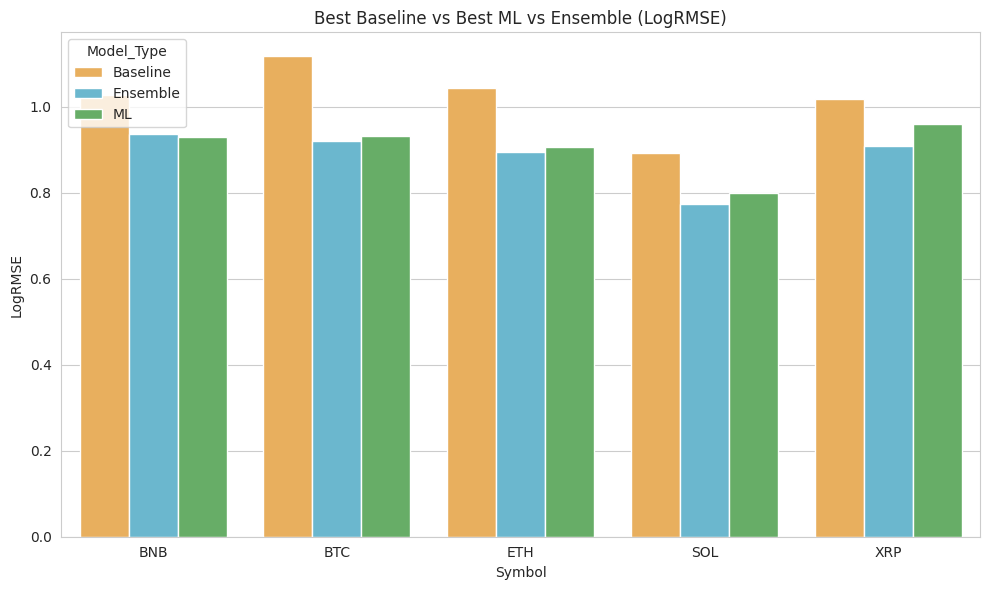


=== Top-3 Models per Symbol (Lowest LogRMSE) ===

--- BNB ---


Model Model_Type  LogRMSE     RMSE      MAE     QLIKE
38          CatBoost         ML 0.929245 0.014477 0.008422 -6.371331
52  Rolling Ensemble   Ensemble 0.936353 0.014339 0.008163 -6.450057
35      RandomForest         ML 0.951960 0.014627 0.008460 -6.306327


--- BTC ---


Model Model_Type  LogRMSE     RMSE      MAE     QLIKE
50  Rolling Ensemble   Ensemble 0.921415 0.009263 0.006219 -6.821683
28          CatBoost         ML 0.932186 0.010846 0.006799 -6.694367
25      RandomForest         ML 0.943815 0.010700 0.006807 -6.711402


--- ETH ---


Model Model_Type  LogRMSE     RMSE      MAE     QLIKE
51  Rolling Ensemble   Ensemble 0.894727 0.018327 0.011286 -5.360479
30      RandomForest         ML 0.906603 0.019140 0.011790 -5.312599
33          CatBoost         ML 0.939918 0.019539 0.012363 -5.244404


--- SOL ---


Model Model_Type  LogRMSE     RMSE      MAE     QLIKE
53  Rolling Ensemble   Ensemble 0.774746 0.016161 0.010635 -5.480001
40      RandomForest         ML 0.800367 0.018497 0.011843 -5.370287
43          CatBoost         ML 0.810133 0.018935 0.012021 -5.349199


--- XRP ---


Model Model_Type  LogRMSE     RMSE      MAE     QLIKE
54  Rolling Ensemble   Ensemble 0.908001 0.016725 0.010943 -5.594546
45      RandomForest         ML 0.959554 0.019940 0.012436 -5.407013
48          CatBoost         ML 0.965855 0.020331 0.012586 -5.407499


=== Improvement Summary (LogRMSE) ===


Symbol  Best_Baseline_LogRMSE  Best_ML_LogRMSE  Best_Ensemble_LogRMSE  \
0    BNB               1.026800         0.929200               0.936400   
1    BTC               1.117500         0.932200               0.921400   
2    ETH               1.043800         0.906600               0.894700   
3    SOL               0.892200         0.800400               0.774700   
4    XRP               1.019500         0.959600               0.908000   

   ML_vs_Baseline_%Improvement  Ensemble_vs_ML_%Improvement  \
0                     9.502600                    -0.764900   
1                    16.585500                     1.155500   
2                    13.147700                     1.310000   
3                    10.293600                     3.201100   
4                     5.878100                     5.372700   

   Ensemble_vs_Baseline_%Improvement  
0                           8.810400  
1                          17.549400  
2                          14.285500  
3                          13.165200  
4                          10.934900

In [ ]:
# ============================================================
# SECTION 12 — Combined Baseline vs ML vs Ensemble Summary
# Comparison Metric: LogRMSE
#
# This section aggregates results from:
# - Baseline models
# - Machine learning models
# - Rolling ensemble
#
# All models are compared using a single, aligned metric
# (LogRMSE in log-variance space) to ensure fairness.
# ============================================================
# ============================================================

sns.set_style("whitegrid")

# NORMALIZE BASELINE RESULTS
# Standardize naming conventions and structure so that
# baseline results can be directly compared to ML and Ensemble
baseline_norm = df_baseline_summary.copy()
baseline_norm["Model_Type"] = "Baseline"
# Harmonize model names for presentation
baseline_norm["Model"] = baseline_norm["Model"].replace({
    "HistAvg": "HistAvg (Baseline)",
    "EWMA": "EWMA (Baseline)",
    "GARCH": "GARCH(1,1)",
    "ElasticNet": "ElasticNet (Baseline)",
    "LinReg": "LinearRegression (Baseline)"
})

# Ensure LogRMSE is numeric
baseline_norm["LogRMSE"] = baseline_norm["LogRMSE"].astype(float)

# Drop any columns not used in cross-model comparison
baseline_norm = baseline_norm.drop(
    columns=[c for c in ["Best_Model", "LogMSE"] if c in baseline_norm],
    errors="ignore"
)

# NORMALIZE ML RESULTS
# Apply consistent formatting and naming for ML models
ml_norm = df_ml_summary.copy()
ml_norm["Model_Type"] = "ML"

ml_norm["Model"] = ml_norm["Model"].replace({
    "RF": "RandomForest",
    "XGB": "XGBoost",
    "LGBM": "LightGBM",
    "CAT": "CatBoost",
    "LSTM": "LSTM"
})
ml_norm["LogRMSE"] = ml_norm["LogRMSE"].astype(float)

# NORMALIZE ENSEMBLE RESULTS
# Ensemble results are already aggregated per symbol
ens_norm = df_ensemble_summary.copy()
ens_norm["Model_Type"] = "Ensemble"

ens_norm["LogRMSE"] = ens_norm["LogRMSE"].astype(float)

# COMBINE ALL RESULTS INTO A SINGLE TABLE
# This unified DataFrame allows:
# - Global ranking
# - Best-model identification
# - Cross-category comparisons
df_combined = pd.concat([baseline_norm, ml_norm, ens_norm], ignore_index=True)

# Identify the best-performing model per symbol
# (lowest LogRMSE)
df_combined["Best_Overall"] = (
    df_combined.groupby("Symbol")["LogRMSE"]
               .transform(lambda x: x == x.min())
)

# SUMMARY
# Table creation
print("\n=== Baseline vs ML vs Ensemble — Combined Comparison (LogRMSE) ===")
display(
    df_combined[
        ["Symbol","Model","Model_Type","MAE","RMSE","LogRMSE","QLIKE","Forecast_Bias","Best_Overall"]
    ].sort_values(["Symbol","LogRMSE"]).round(6)
)

# VISUAL COMPARISON: BEST MODEL BY TYPE
# For each symbol and model category (Baseline / ML / Ensemble),
# select the best-performing model (lowest LogRMSE)
plt.figure(figsize=(10,6))
best_by_type = (
    df_combined.groupby(["Symbol","Model_Type"])["LogRMSE"]
               .min()
               .reset_index()
)
sns.barplot(
    data=best_by_type,
    x="Symbol",
    y="LogRMSE",
    hue="Model_Type",
    ci=None,
    palette={"Baseline":"#ffb347","ML":"#5cb85c","Ensemble":"#5bc0de"}
)
plt.title("Best Baseline vs Best ML vs Ensemble (LogRMSE)")
plt.tight_layout()
plt.show()

# TOP-3 MODELS PER SYMBOL
# Provides a compact ranking of the three best models
# for each asset, regardless of model class
print("\n=== Top-3 Models per Symbol (Lowest LogRMSE) ===")
for sym in df_combined["Symbol"].unique():
    print(f"\n--- {sym} ---")
    subset = df_combined[df_combined["Symbol"] == sym]
    display(
        subset.sort_values("LogRMSE")[["Model","Model_Type","LogRMSE","RMSE","MAE","QLIKE"]].head(3)
    )

# IMPROVEMENT SUMMARY
# Quantifies the relative gains from:
# - Baseline → ML
# - ML → Ensemble
# - Baseline → Ensemble
summary_rows = []
for sym in df_combined["Symbol"].unique():
    sub = df_combined[df_combined["Symbol"] == sym]

    best_baseline = sub[sub["Model_Type"]=="Baseline"]["LogRMSE"].min()
    best_ml       = sub[sub["Model_Type"]=="ML"]["LogRMSE"].min()
    best_ens      = sub[sub["Model_Type"]=="Ensemble"]["LogRMSE"].min()

    summary_rows.append({
        "Symbol": sym,
        "Best_Baseline_LogRMSE": best_baseline,
        "Best_ML_LogRMSE": best_ml,
        "Best_Ensemble_LogRMSE": best_ens,
        "ML_vs_Baseline_%Improvement": 100*(best_baseline - best_ml)/best_baseline,
        "Ensemble_vs_ML_%Improvement": 100*(best_ml - best_ens)/best_ml,
        "Ensemble_vs_Baseline_%Improvement": 100*(best_baseline - best_ens)/best_baseline
    })

df_improvement = pd.DataFrame(summary_rows)

print("\n=== Improvement Summary (LogRMSE) ===")
display(df_improvement.round(4))



Volatility Panel (first 5 rows):


Symbol                         BNB      BTC      ETH      SOL      XRP
Date                                                                  
2022-04-11 00:00:00+00:00 0.039284 0.043389 0.047500 0.072943 0.057510
2022-04-12 00:00:00+00:00 0.070261 0.048041 0.055383 0.098304 0.068909
2022-04-13 00:00:00+00:00 0.018528 0.024558 0.022411 0.031380 0.019188
2022-04-14 00:00:00+00:00 0.020367 0.025053 0.028653 0.045344 0.023425
2022-04-15 00:00:00+00:00 0.009144 0.010829 0.008759 0.015180 0.066835


VAR(1) Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Jan, 2026
Time:                     09:54:55
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -42.8841
Nobs:                     1298.00    HQIC:                  -42.9588
Log likelihood:           18730.4    FPE:                2.10758e-19
AIC:                     -43.0036    Det(Omega_mle):     2.05953e-19
--------------------------------------------------------------------
Results for equation BNB
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.010229         0.000848           12.068           0.000
L1.BNB         0.482903         0.031617           15.274           0.000
L1.BTC        -0.056199         0.041687           -1.348           0.178

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


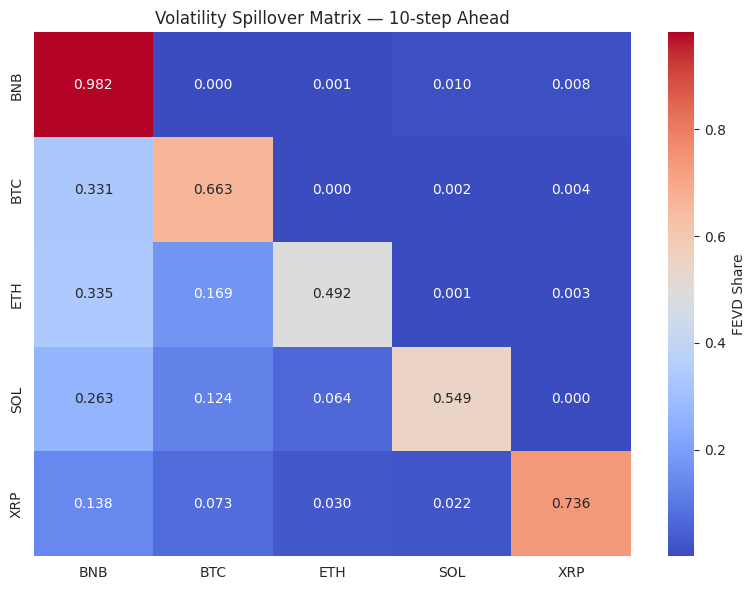


Pairwise Granger Causality Summary (Realized vol_yz):


From   To  p_value  Significant
4   BNB  BTC 0.000068         True
13  BTC  SOL 0.003008         True
3   XRP  BNB 0.005300         True
2   SOL  BNB 0.008358         True
7   XRP  BTC 0.026999         True
6   SOL  BTC 0.028219         True
16  BNB  XRP 0.045258         True
12  BNB  SOL 0.049869         True
9   BTC  ETH 0.050684        False
11  XRP  ETH 0.074204        False
15  XRP  SOL 0.085952        False
19  SOL  XRP 0.092031        False
8   BNB  ETH 0.122523        False
17  BTC  XRP 0.185606        False
5   ETH  BTC 0.310756        False
10  SOL  ETH 0.316000        False
14  ETH  SOL 0.372711        False
18  ETH  XRP 0.440107        False
1   ETH  BNB 0.537521        False
0   BTC  BNB 0.727426        False

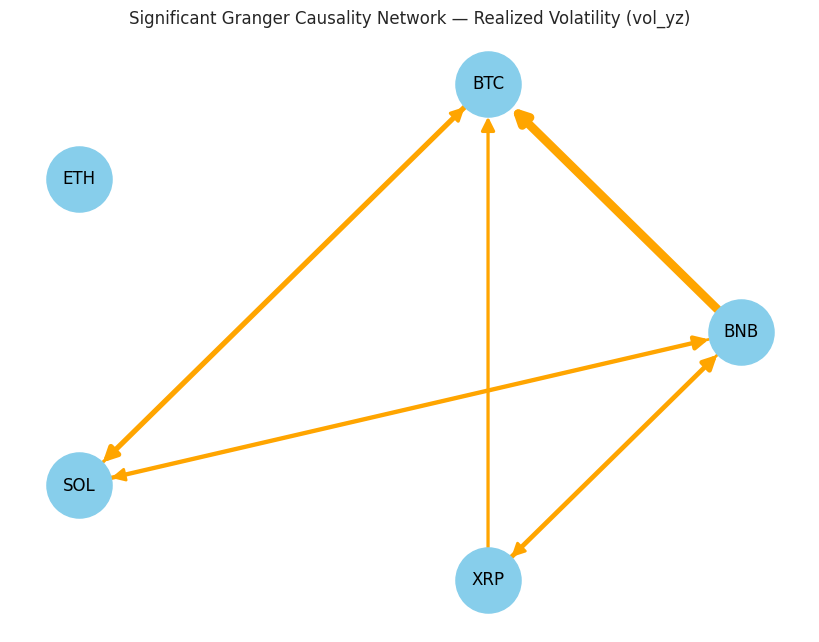


Interpretation:
- The total volatility spillover index is 31.57%, meaning roughly 31.6% of forecast error variance in crypto volatilities is due to cross-asset shocks rather than idiosyncratic movements.
- Larger off-diagonal FEVD elements indicate stronger interdependence among crypto volatilities.
- Granger causality links (arrows) identify directional spillovers — transmitters vs receivers.
- This realized-volatility network serves as a benchmark; in later sections, we'll compare it with ML ensemble-based volatility forecasts to test whether machine learning models produce smoother and less connected volatility structures.


In [ ]:
# ============================================================
# SECTION 13 — Volatility Spillover Analysis (Realized vol_yz)
#
# This section analyzes volatility spillovers across cryptocurrencies
# using realized Yang–Zhang volatility (vol_yz).
#
# The analysis follows the Diebold–Yilmaz (2012, 2014) framework:
# - A VAR model is estimated on volatility levels
# - Forecast Error Variance Decomposition (FEVD) is used
# - Spillover indices and directional linkages are computed
# ============================================================

sns.set_style("whitegrid")

# PREPARE REALIZED VOLATILITY PANEL# Construct a balanced panel of realized Yang–Zhang volatilities
# with:
# - Dates as rows
# - Crypto assets as columns
#
# Forward-filling is used to handle occasional missing values,
# ensuring a complete time series for VAR estimation.
df_vol_panel = (
    df_yz.pivot(index="Date", columns="Symbol", values="vol_yz")
    .sort_index()
    .fillna(method="ffill")
    .dropna()
)

print("Volatility Panel (first 5 rows):")
display(df_vol_panel.head())

symbols = df_vol_panel.columns.tolist()

# VAR MODEL ESTIMATION
# Estimate a Vector Autoregression (VAR) model on volatility levels.
#
# Consistent with Diebold–Yilmaz methodology, volatility levels
# (not returns) are used to capture volatility transmission dynamics.
lag_order = 1  # Can be selected via AIC/BIC; fixed here for simplicity
var_model = VAR(df_vol_panel)
var_results = var_model.fit(lag_order)

print(f"\nVAR({lag_order}) Summary:")
print(var_results.summary())

# DIEBOLD–YILMAZ SPILLOVER INDEX (FEVD-BASED)
# Compute Forecast Error Variance Decomposition (FEVD)
# over a multi-step horizon.
#
# FEVD_HORIZON defines how far ahead forecast errors are evaluated.
FEVD_HORIZON = 10  # steps ahead for forecast error variance decomposition
fevd = var_results.fevd(FEVD_HORIZON)

# Initialize spillover matrix:
# Rows: receiving asset
# Columns: transmitting asset
spillover_matrix = np.zeros((len(symbols), len(symbols)))

for i, sym in enumerate(symbols):
    # fevd.decomp[i] has shape: (horizon × number of variables)
    # Use the final-step decomposition to capture long-run effects
    spillover_matrix[i, :] = fevd.decomp[i][-1, :]  # use final-step shares

spillover_df = pd.DataFrame(spillover_matrix, index=symbols, columns=symbols)

# Compute total spillover index:
# Share of forecast error variance coming from cross-asset shocks
total_spillover = (
    (spillover_df.values.sum() - np.trace(spillover_df.values))
    / spillover_df.values.sum()
    * 100
)

print(f"\nTotal Volatility Spillover Index (Diebold–Yilmaz): {total_spillover:.2f}%")

# VISUALIZATION: SPILLOVER MATRIX
# Heatmap representation of FEVD shares.
# Off-diagonal elements capture cross-asset volatility transmission.
plt.figure(figsize=(8, 6))
sns.heatmap(
    spillover_df, annot=True, fmt=".3f", cmap="coolwarm",
    cbar_kws={"label": "FEVD Share"}
)
plt.title(f"Volatility Spillover Matrix — {FEVD_HORIZON}-step Ahead")
plt.tight_layout()
plt.show()

# PAIRWISE GRANGER CAUSALITY TESTS
# Test directional predictability between volatility series.
#
# If volatility of asset A Granger-causes volatility of asset B,
# past values of A help predict B.
MAX_LAG = 5
granger_records = []

for to_sym in symbols:
    for from_sym in symbols:
        if to_sym == from_sym:
            continue
        try:
            result = grangercausalitytests(
                df_vol_panel[[to_sym, from_sym]],
                maxlag=MAX_LAG,
                verbose=False
            )
            # Extract the minimum p-value across tested lags
            pvals = [result[i + 1][0]["ssr_chi2test"][1] for i in range(MAX_LAG)]
            min_p = np.min(pvals)
            granger_records.append({
                "From": from_sym,
                "To": to_sym,
                "p_value": min_p,
                "Significant": min_p < 0.05
            })
        except Exception as e:
            print(f"Granger test failed for {from_sym} → {to_sym}: {e}")

granger_df = pd.DataFrame(granger_records)
print("\nPairwise Granger Causality Summary (Realized vol_yz):")
display(granger_df.sort_values("p_value"))

# VISUALIZATION: GRANGER CAUSALITY NETWORK
# Construct a directed network where:
# - Nodes are crypto assets
# - Directed edges indicate significant Granger causality
G = nx.DiGraph()
G.add_nodes_from(symbols)

# Add only statistically significant causal links (p < 0.05)
sig_links = granger_df[granger_df["Significant"]]
for _, row in sig_links.iterrows():
    G.add_edge(
        row["From"], row["To"],
        # Edge weight reflects strength of evidence
        weight=-np.log10(row["p_value"] + 1e-12)
    )

plt.figure(figsize=(8, 6))
pos = nx.circular_layout(G)
edge_weights = [G[u][v]["weight"] * 1.5 for u, v in G.edges()]
nx.draw(
    G, pos,
    with_labels=True,
    node_size=2200,
    node_color="skyblue",
    edge_color="orange",
    width=edge_weights,
    arrowsize=20,
    font_size=12
)
plt.title("Significant Granger Causality Network — Realized Volatility (vol_yz)")
plt.tight_layout()
plt.show()

# SUMMARY
# Interpretation
print("\nInterpretation:")
print(f"- The total volatility spillover index is {total_spillover:.2f}%, meaning roughly "
      f"{total_spillover:.1f}% of forecast error variance in crypto volatilities is due to "
      f"cross-asset shocks rather than idiosyncratic movements.")
print("- Larger off-diagonal FEVD elements indicate stronger interdependence among crypto volatilities.")
print("- Granger causality links (arrows) identify directional spillovers — transmitters vs receivers.")
print("- This realized-volatility network serves as a benchmark; in later sections, "
      "we'll compare it with ML ensemble-based volatility forecasts to test whether "
      "machine learning models produce smoother and less connected volatility structures.")




Ensemble Volatility Panel built successfully.
Shape: (239, 5)


BNB      BTC      ETH      SOL      XRP
Date                                                   
2025-03-05 0.027863 0.030069 0.037332 0.050613 0.034276
2025-03-06 0.024848 0.029913 0.032899 0.045900 0.037270
2025-03-07 0.017786 0.025563 0.023253 0.040876 0.023611
2025-03-08 0.021778 0.020794 0.032249 0.041796 0.030757
2025-03-09 0.027125 0.035914 0.039752 0.053029 0.050655


VAR(1) Summary (Ensemble Volatility):
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Jan, 2026
Time:                     09:54:57
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -53.7993
Nobs:                     238.000    HQIC:                  -54.0606
Log likelihood:           4795.66    FPE:                2.78740e-24
AIC:                     -54.2370    Det(Omega_mle):     2.46113e-24
--------------------------------------------------------------------
Results for equation BNB
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.005438         0.001248            4.358           0.000
L1.BNB         0.853056         0.047136           18.098           0.000
L1.BTC        -0.190790         0.080491           

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


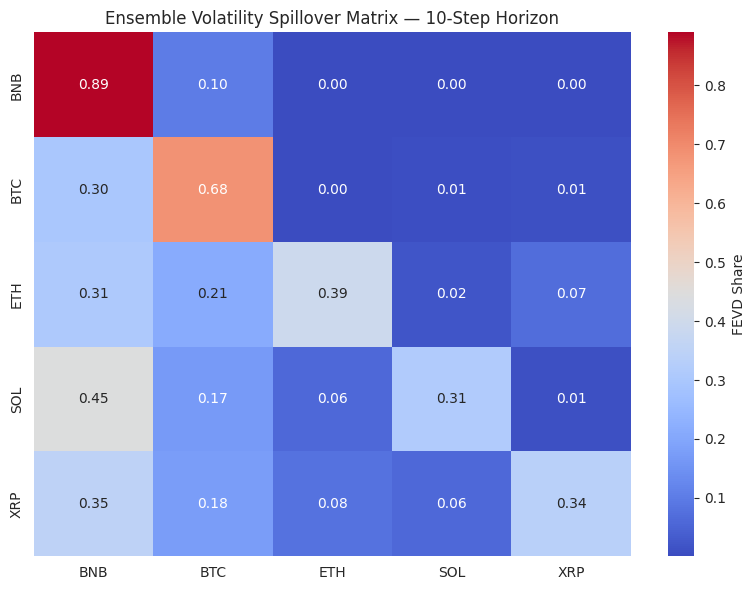


Pairwise Granger Causality (Ensemble Volatility):


From   To  p_value  Significant
0   ETH  BNB 0.000000         True
1   BTC  BNB 0.000000         True
2   BTC  XRP 0.000003         True
3   XRP  ETH 0.000064         True
4   ETH  XRP 0.000280         True
5   BTC  SOL 0.000497         True
6   SOL  BNB 0.001020         True
7   ETH  BTC 0.003650         True
8   SOL  ETH 0.004730         True
9   BNB  SOL 0.005365         True
10  XRP  BNB 0.005506         True
11  ETH  SOL 0.007723         True
12  XRP  BTC 0.013127         True
13  SOL  BTC 0.024709         True
14  BNB  XRP 0.049844         True

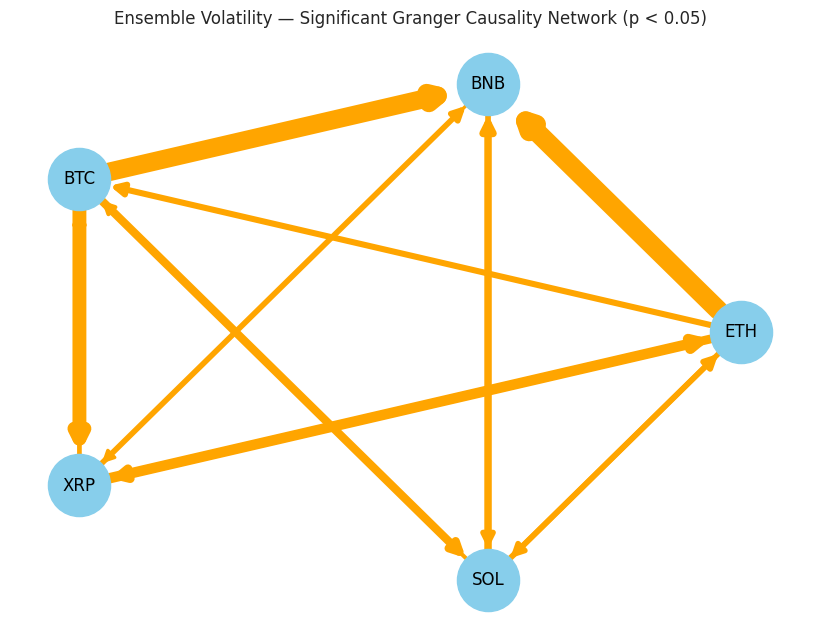


=== Comparison — Realized vs Ensemble Volatility Spillovers ===
Realized DY Spillover (10-step): 31.57%
Ensemble DY Spillover (10-step): 47.68%

Merged Granger Causality Results:


From   To   p_real  sig_real    p_ens  sig_ens  Persistent
0   BTC  SOL 0.003008      True 0.000497     True        True
1   SOL  BNB 0.008358      True 0.001020     True        True
2   BNB  SOL 0.049869      True 0.005365     True        True
3   XRP  BNB 0.005300      True 0.005506     True        True
4   XRP  BTC 0.026999      True 0.013127     True        True
5   SOL  BTC 0.028219      True 0.024709     True        True
6   BNB  XRP 0.045258      True 0.049844     True        True
7   ETH  BNB 0.537521     False 0.000000     True       False
8   BTC  BNB 0.727426     False 0.000000     True       False
9   BTC  XRP 0.185606     False 0.000003     True       False
10  XRP  ETH 0.074204     False 0.000064     True       False
11  ETH  XRP 0.440107     False 0.000280     True       False
12  ETH  BTC 0.310756     False 0.003650     True       False
13  SOL  ETH 0.316000     False 0.004730     True       False
14  ETH  SOL 0.372711     False 0.007723     True       False
15  XRP  SOL 0.085952     False 0.052549    False       False
16  BTC  ETH 0.050684     False 0.138382    False       False
17  BNB  BTC 0.000068      True 0.166461    False       False
18  SOL  XRP 0.092031     False 0.208849    False       False
19  BNB  ETH 0.122523     False 0.496971    False       False

In [ ]:
# ============================================================
# SECTION 14 — Volatility Spillover Analysis (Ensemble Volatility)
#
# This section replicates the spillover analysis of Section 13,
# but replaces realized volatility with ML ensemble-based
# volatility forecasts.
#
# The goal is to assess whether ML-based volatility forecasts
# generate a different (e.g. smoother or less interconnected)
# spillover structure compared to realized volatility.
# ============================================================

sns.set_style("whitegrid")

# List of crypto assets included in the analysis
CRYPTO_SYMBOLS = sorted(df_cleaned["Symbol"].unique().tolist())

def _make_naive_index(idx):
    """
    Convert a datetime-like Index or column to timezone-naive format.

    This ensures consistent alignment across series and avoids
    issues when merging or reindexing time series originating
    from different timezone conventions.
    """
    if getattr(idx, "tz", None) is not None:
        try:
            return pd.to_datetime(idx, utc=True).tz_convert(None)
        except Exception:
            return pd.to_datetime(idx).tz_localize(None)
    return pd.to_datetime(idx)

# BUILD ENSEMBLE VOLATILITY PANEL
# The ensemble volatility forecasts are produced in Section 11.
# This block assembles them into a balanced panel suitable for VAR.
if "ensemble_results" not in globals() or not ensemble_results:
    raise RuntimeError("ensemble_results not found. Run Section 11 first.")

ens_vol_map = {}
date_sets = []

for sym in CRYPTO_SYMBOLS:
    if sym not in ensemble_results:
        raise KeyError(f"{sym} missing in ensemble_results. Run Section 11 again.")

     # Retrieve per-symbol ensemble prediction DataFrame
    dfp = ensemble_results[sym]["Preds"].copy()

    # Ensure Date is timezone-naive and sorted
    dfp["Date"] = _make_naive_index(dfp["Date"])
    dfp = dfp.sort_values("Date").reset_index(drop=True)

    if "Ensemble_vol" not in dfp.columns:
        raise KeyError(f"'Ensemble_vol' not found in Preds for {sym}. "
                       "Re-run Section 11 to populate Ensemble_vol.")

    # Store ensemble volatility as a time-indexed Series
    ens_vol_map[sym] = pd.Series(dfp["Ensemble_vol"].values, index=dfp["Date"])
    date_sets.append(set(dfp["Date"]))

# Align all assets to a common set of dates
# (intersection ensures balanced VAR estimation)
common_index = sorted(set.intersection(*date_sets))

vol_ensemble_df = pd.DataFrame({
    sym: ens_vol_map[sym].reindex(common_index).ffill()
    for sym in CRYPTO_SYMBOLS
}).dropna(how="any")

print("Ensemble Volatility Panel built successfully.")
print("Shape:", vol_ensemble_df.shape)
display(vol_ensemble_df.head())

# VAR ESTIMATION AND FEVD SPILLOVER (ENSEMBLE VOLATILITY)
# Apply the same VAR specification as in Section 13
lag_order = 1
var_ens = VAR(vol_ensemble_df)
var_ens_res = var_ens.fit(lag_order)

print(f"\nVAR({lag_order}) Summary (Ensemble Volatility):")
print(var_ens_res.summary())

# Forecast Error Variance Decomposition
FEVD_HORIZON = 10
fevd_ens = var_ens_res.fevd(FEVD_HORIZON)
symbols = vol_ensemble_df.columns
spill_mat = np.zeros((len(symbols), len(symbols)))

for i, sym in enumerate(symbols):
    # last-horizon FEVD shares for variable i
    spill_mat[i, :] = fevd_ens.decomp[i][-1, :]
# Extract FEVD shares at the final horizon
spill_df_ens = pd.DataFrame(spill_mat, index=symbols, columns=symbols)

# Total Diebold–Yilmaz spillover index
total_spill_ens = (
    (spill_df_ens.values.sum() - np.trace(spill_df_ens.values))
    / spill_df_ens.values.sum()
) * 100

print(f"\nTotal Volatility Spillover Index (Ensemble, {FEVD_HORIZON}-step): "
      f"{total_spill_ens:.2f}%")

# VISUALIZATION:
# Ensemble spillover matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    spill_df_ens, annot=True, fmt=".2f", cmap="coolwarm",
    cbar_kws={"label": "FEVD Share"}
)
plt.title(f"Ensemble Volatility Spillover Matrix — {FEVD_HORIZON}-Step Horizon")
plt.tight_layout()
plt.show()

# GRANGER CAUSALITY ANALYSIS
# Ensemble Volatility
def granger_best_pvals(panel, maxlag=5):
    """
    Compute pairwise Granger causality tests for all asset pairs.

    For each direction, the minimum p-value across lags
    up to maxlag is retained.
    """
    records = []
    for to_sym in panel.columns:
        for from_sym in panel.columns:
            if to_sym == from_sym:
                continue
            try:
                res = grangercausalitytests(
                    panel[[to_sym, from_sym]], maxlag=maxlag, verbose=False
                )
                pvals = [
                    res[L][0]["ssr_chi2test"][1]
                    for L in range(1, maxlag + 1)
                ]
                records.append({
                    "From": from_sym,
                    "To": to_sym,
                    "p_value": np.nanmin(pvals)
                })
            except Exception:
                continue
    df = pd.DataFrame(records)
    df["Significant"] = df["p_value"] < 0.05
    return df.sort_values("p_value").reset_index(drop=True)

gc_ensemble = granger_best_pvals(vol_ensemble_df, maxlag=5)
print("\nPairwise Granger Causality (Ensemble Volatility):")
display(gc_ensemble.head(15))

# Granger network visualization
gc_sig = gc_ensemble[gc_ensemble["Significant"]]
G = nx.DiGraph()
for _, row in gc_sig.iterrows():
    G.add_edge(row["From"], row["To"],
               weight=-np.log10(row["p_value"] + 1e-15))

plt.figure(figsize=(8, 6))
pos = nx.circular_layout(G)
edge_w = [G[u][v]["weight"] * 1.8 for u, v in G.edges()]
nx.draw(
    G, pos,
    with_labels=True,
    node_size=2000,
    node_color="skyblue",
    edge_color="orange",
    width=edge_w,
    arrowsize=18,
    font_size=12
)
plt.title("Ensemble Volatility — Significant Granger Causality Network (p < 0.05)")
plt.tight_layout()
plt.show()

# COMPARISON WITH REALIZED VOLATILITY SPILLOVERS (SECTION 13)
if "granger_df" in globals():
    comp = pd.merge(
        granger_df.rename(columns={"p_value": "p_real", "Significant": "sig_real"}),
        gc_ensemble.rename(columns={"p_value": "p_ens", "Significant": "sig_ens"}),
        on=["From", "To"], how="outer"
    )
    # Identify spillovers persistent across realized and ensemble vol
    comp["Persistent"] = comp["sig_real"].fillna(False) & comp["sig_ens"].fillna(False)
    comp = comp.sort_values(
        ["Persistent", "p_ens"], ascending=[False, True]
    ).reset_index(drop=True)

    realized_spill_label = (
        f"{total_spillover:.2f}%" if "total_spillover" in globals()
        else "(see Section 13)"
    )

    # SUMMARY
    print("\n=== Comparison — Realized vs Ensemble Volatility Spillovers ===")
    print(f"Realized DY Spillover (10-step): {realized_spill_label}")
    print(f"Ensemble DY Spillover (10-step): {total_spill_ens:.2f}%")
    print("\nMerged Granger Causality Results:")
    display(comp[[
        "From", "To", "p_real", "sig_real", "p_ens", "sig_ens", "Persistent"
    ]])
else:
    print("\nSection 13 Granger results (`granger_df`) not found. "
          "Run Section 13 before this to enable side-by-side comparison.")

# SAVE OUTPUTS FOR LATER SECTIONS
spill_df_ens_out = spill_df_ens.copy()
total_spill_ens_out = total_spill_ens
gc_ensemble_out = gc_ensemble.copy()



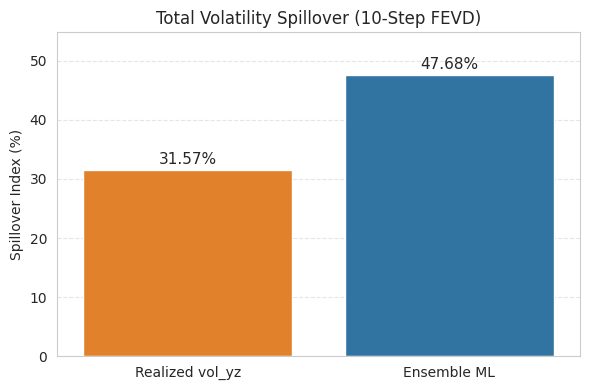


Spillover reduction achieved by ML ensemble: -16.11 p.p. (-51.03% decrease).


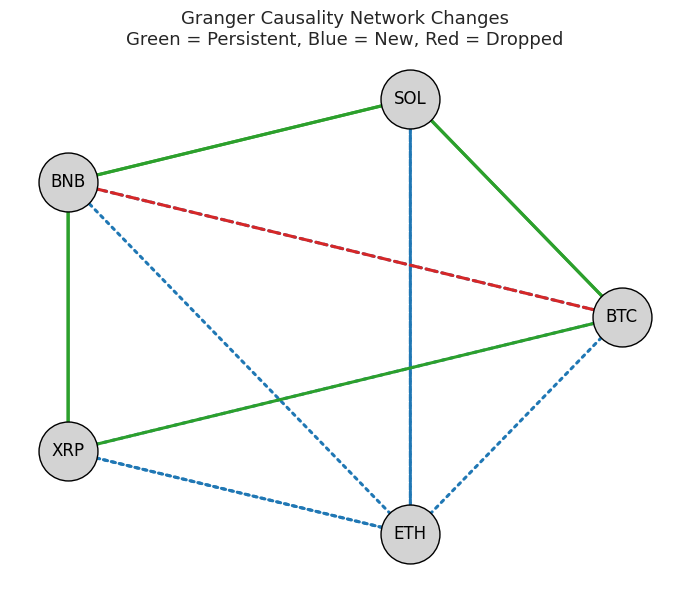

In [ ]:
# ============================================================
# SECTION 15 — Visual Summary: Spillover Reduction/Increase & Network Changes
#
# This section provides a compact visual synthesis of the
# spillover analysis by:
# - Comparing total spillover indices (realized vs ensemble)
# - Visualizing how Granger-causality networks change
#
# The goal is to highlight whether ML-based volatility forecasts
# alter the degree and structure of cross-asset connectedness.
# ============================================================

sns.set_style("whitegrid")

# RETRIEVE TOTAL SPILLOVER INDICES
# Safely extract spillover measures computed earlier
# (Sections 13 and 14)
realized_spill = total_spillover if "total_spillover" in globals() else np.nan
ensemble_spill = total_spill_ens_out if "total_spill_ens_out" in globals() else np.nan

if np.isnan(realized_spill) or np.isnan(ensemble_spill):
    print("Missing spillover indices. Please ensure Sections 13 and 14 were executed.")
else:

    # BAR CHART: TOTAL SPILLOVER COMPARISON
    # Visual comparison of overall connectedness under:
    # - Realized Yang–Zhang volatility
    # - ML ensemble-based volatility forecasts
    plt.figure(figsize=(6, 4))
    sns.barplot(
        x=["Realized vol_yz", "Ensemble ML"],
        y=[realized_spill, ensemble_spill],
        palette=["tab:orange", "tab:blue"]
    )
    plt.title("Total Volatility Spillover (10-Step FEVD)")
    plt.ylabel("Spillover Index (%)")
    plt.xlabel("")
    plt.text(0, realized_spill + 0.5, f"{realized_spill:.2f}%", ha="center", va="bottom", fontsize=11)
    plt.text(1, ensemble_spill + 0.5, f"{ensemble_spill:.2f}%", ha="center", va="bottom", fontsize=11)
    plt.ylim(0, max(realized_spill, ensemble_spill) * 1.15)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Quantify spillover reduction (or increase)
    delta = realized_spill - ensemble_spill
    print(f"\nSpillover reduction achieved by ML ensemble: {delta:.2f} p.p. "
          f"({delta/realized_spill*100:.2f}% decrease).")

# GRANGER CAUSALITY NETWORK CHANGE VISUALIZATION
# This block visualizes how the Granger causality network
# changes when moving from realized volatility to
# ensemble-based volatility.
if "comp" in locals() and not comp.empty:
    G_diff = nx.DiGraph()

    # Encode link status using color and line style:
    # - Green / solid   : persistent links
    # - Red   / dashed  : links present in realized vol only
    # - Blue  / dotted  : new links appearing under ensemble vol
    for _, row in comp.iterrows():
        if row.get("Persistent", False):
            color, style = "tab:green", "solid"       # unchanged
        elif row.get("sig_real", False) and not row.get("sig_ens", False):
            color, style = "tab:red", "dashed"        # dropped
        elif not row.get("sig_real", False) and row.get("sig_ens", False):
            color, style = "tab:blue", "dotted"       # new
        else:
            continue
        G_diff.add_edge(row["From"], row["To"], color=color, style=style)
    # If no changes are detected, report explicitly
    if len(G_diff.edges) == 0:
        print("No significant Granger link changes detected between realized and ensemble networks.")
    else:
        plt.figure(figsize=(7, 6))
        pos = nx.circular_layout(G_diff)
        edges = list(G_diff.edges())

        # Draw edges grouped by style for clarity
        for style_type in set(nx.get_edge_attributes(G_diff, "style").values()):
            edges_sub = [(u, v) for (u, v) in edges if G_diff[u][v]["style"] == style_type]
            nx.draw_networkx_edges(
                G_diff,
                pos,
                edgelist=edges_sub,
                edge_color=[G_diff[u][v]["color"] for u, v in edges_sub],
                style=style_type,
                width=2.2,
                arrowsize=15,
            )

        # Draw edges grouped by style for clarity
        nx.draw_networkx_nodes(G_diff, pos, node_size=1800, node_color="lightgrey", edgecolors="black")
        nx.draw_networkx_labels(G_diff, pos, font_size=12)

        # VISUALIZATION
        plt.title("Granger Causality Network Changes\n"
                  "Green = Persistent, Blue = New, Red = Dropped", fontsize=13)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
else:
    print("Granger comparison table `comp` not found or empty. "
          "Run Section 14 to enable the overlay network plot.")


In [ ]:
# ============================================================
# SECTION 16A — Economic Value of Baseline Vol Models (2025)
#
# This section evaluates whether baseline volatility forecasts
# translate into improved portfolio performance.
#
# Two portfolio constructions are considered:
# - Inverse-Volatility Weighting (IVW)
# - Equal Risk Contribution (ERC)
#
# Performance is evaluated on the test window using
# annualized Sharpe ratios.
# ============================================================

print("\n=== SECTION 16A: Economic Value of Baseline Vol Models (2025) ===")

# Baseline volatility models evaluated
baseline_models = ["HistAvg", "EWMA", "GARCH", "LinReg", "ElasticNet"]

# Crypto universe
CRYPTO_SYMBOLS  = ["BTC", "ETH", "BNB", "SOL", "XRP"]

# Trading and portfolio parameters
TRADING_DAYS   = 365        # Crypto trades year-round
LOOKBACK_ERC   = 10         # Trailing window for ERC covariance
MIN_OBS_ERC    = 10         # Minimum observations for ERC stability

# SAFE DATETIME PARSER
# Ensures consistent timezone-naive datetime handling
# across all portfolio calculations
def to_naive_any_fixed(x):
    x = pd.to_datetime(x, errors="coerce")
    if hasattr(x, "dt"):
        for fn in ("tz_convert", "tz_localize"):
            try:
                return getattr(x.dt, fn)(None)
            except Exception:
                pass
        return x
    if isinstance(x, pd.DatetimeIndex):
        for fn in ("tz_convert", "tz_localize"):
            try:
                return getattr(x, fn)(None)
            except Exception:
                pass
        return x
    return x

# PORTFOLIO CONSTRUCTION HELPERS
# (IVW, ERC)
def ivw_weights_from_vol(vol_row):
    """
    Inverse-volatility weights.

    Assets with higher forecast volatility
    receive lower portfolio weights.
    """
    v = np.asarray(vol_row, dtype=float)
    inv = 1.0 / (v + 1e-12)
    return inv / inv.sum()

def portfolio_vol(w, cov):
    """Compute portfolio volatility given weights and covariance."""
    w = np.asarray(w, float)
    return np.sqrt(w @ cov @ w)

def risk_contributions(w, cov):
    """
    Marginal risk contribution of each asset
    to total portfolio volatility.
    """
    w = np.asarray(w, float)
    pv = portfolio_vol(w, cov) + 1e-12
    m = cov @ w
    return w * m / pv

def solve_erc(cov):
    """
    Solve for Equal Risk Contribution (ERC) weights.

    If numerical optimization fails,
    fall back to inverse-volatility weights.
    """
    cov = np.asarray(cov, float)
    n   = cov.shape[0]
    w0  = np.ones(n) / n

    def objective(w):
        w  = np.maximum(w, 1e-12)
        w  = w / w.sum()
        rc = risk_contributions(w, cov)
        tgt = np.ones(n) * rc.mean()
        return ((rc - tgt) ** 2).sum()

    cons   = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)
    bounds = [(0.0, 1.0)] * n

    res = minimize(objective, w0, bounds=bounds, constraints=cons)
    if not res.success:
        stds = np.sqrt(np.diag(cov))
        return ivw_weights_from_vol(stds)
    w = np.maximum(res.x, 0.0)
    return w / w.sum()

# Unified ERC construction using:
# - rolling return covariance
# - model-implied volatilities
def erc_from_vol(vol_row, date, rets_full, lookback=LOOKBACK_ERC):
    """
    Compute ERC weights using:
    - Historical return correlations
    - Model-based volatility forecasts
    """
    v = np.asarray(vol_row, dtype=float)
    if np.isnan(v).any():
        return np.ones_like(v) / len(v)

    window_rets = rets_full.loc[:date].dropna().iloc[-lookback:]
    if len(window_rets) < MIN_OBS_ERC:
        return np.ones_like(v) / len(v)

    cov_r = window_rets.cov().values
    std_r = np.sqrt(np.diag(cov_r) + 1e-12)
    corr  = cov_r / np.outer(std_r, std_r)
    corr  = np.nan_to_num(corr, nan=0.0)
    np.fill_diagonal(corr, 1.0)

    cov_model = np.diag(v) @ corr @ np.diag(v)
    return solve_erc(cov_model)

def sharpe_from_logr(x):
    """
    Annualized Sharpe ratio computed from
    daily log returns.
    """
    s = pd.Series(x).dropna()
    if len(s) < 3:
        return np.nan
    mu  = s.mean()
    sig = s.std()
    return mu / (sig + 1e-12) * np.sqrt(TRADING_DAYS)

# BUILD TEST INDEX (COMMON ACROSS ALL PORTFOLIOS)
test_dates = panel_df.loc[panel_df["Split"] == "Test", "Date"]
test_index = pd.DatetimeIndex(to_naive_any_fixed(test_dates)).sort_values().unique()

print(f"Test index length: {len(test_index)}")
print(f"Test index range:  {test_index[0]} → {test_index[-1]}")

# # FULL RETURN PANEL (USED ACROSS MULTIPLE SECTIONS) (GLOBAL: used in 16B, 16C, 17)
rets = {}
for sym in CRYPTO_SYMBOLS:
    d = df_cleaned[df_cleaned["Symbol"] == sym].copy()
    d["Date"] = to_naive_any_fixed(d["Date"])
    d = d.sort_values("Date").set_index("Date")
    d["logret"] = np.log(d["Close"]).diff()
    rets[sym]   = d["logret"]

rets_full = pd.DataFrame(rets).sort_index()        # full history
rets_df   = rets_full.reindex(test_index)          # restricted to test window

print("rets_full shape:", rets_full.shape)
print("rets_df   shape (test window):", rets_df.shape)

# # HISTORICAL 30-DAY VOLATILITY BENCHMARK
# Used as an economic-value benchmark
hist30_vol_full = rets_full.rolling(30, min_periods=30).std()
hist30_vol_test = hist30_vol_full.reindex(test_index)

# Benchmark Hist30 IVW Sharpe on TEST window
hist_pnl = []
for dt in test_index:
    v      = hist30_vol_test.loc[dt]
    if v.isna().any():
        hist_pnl.append(np.nan)
        continue
    w_hist = ivw_weights_from_vol(v)
    hist_pnl.append(np.nansum(w_hist * rets_df.loc[dt].values))

hist30_sharpe = sharpe_from_logr(hist_pnl)
print(f"\nHist30 IVW Sharpe (benchmark, test window): {hist30_sharpe:.4f}\n")

# CONVERT BASELINE LOG-VARIANCE FORECASTS TO VOLATILITY
# Convert baseline logvar → volatility, full history
baseline_vols = {m: {} for m in baseline_models}

for sym in CRYPTO_SYMBOLS:
    for m in baseline_models:
        ser_log = BASELINE_PREDS.get(sym, {}).get(m, None)
        if ser_log is None:
            continue
        ser_log.index = to_naive_any_fixed(ser_log.index)
        ser_log = ser_log.sort_index().astype(float)
        baseline_vols[m][sym] = np.sqrt(np.exp(ser_log))

# ECONOMIC VALUE EVALUATION
# Economic value evaluation (IVW + unified ERC) on test window
results = []

for model in baseline_models:
    missing = [s for s in CRYPTO_SYMBOLS if s not in baseline_vols[model]]
    if missing:
        print(f"Skipping {model}: missing {missing}")
        continue

    vol_df_full = pd.DataFrame(baseline_vols[model]).sort_index()
    vol_df_test = vol_df_full.reindex(test_index).ffill()

    pnl_ivw = []
    pnl_erc = []

    for dt in test_index:
        v = vol_df_test.loc[dt]
        if v.isna().any():
            pnl_ivw.append(np.nan)
            pnl_erc.append(np.nan)
            continue

        # IVW Portfolio
        w_ivw = ivw_weights_from_vol(v.values)
        r_t   = rets_df.loc[dt].values
        pnl_ivw.append(np.nansum(w_ivw * r_t))

        # Unified ERC based on rets_full covariance + model vol
        w_erc = erc_from_vol(v.values, dt, rets_full, lookback=LOOKBACK_ERC)
        pnl_erc.append(np.nansum(w_erc * r_t))

    res_ivw = sharpe_from_logr(pnl_ivw)
    res_erc = sharpe_from_logr(pnl_erc)

    results.append({
        "Model": model,
        "IVW_Sharpe": res_ivw,
        "ERC_Sharpe": res_erc,
        "IVW_vs_Hist30": res_ivw - hist30_sharpe
    })

df_baseline_econ = pd.DataFrame(results).set_index("Model").round(4)

# SUMMARY
print("\n=== Baseline Vol Models — Economic Value (IVW & ERC Sharpe, Test Window) ===")
print(f"Hist30 Benchmark IVW Sharpe (test): {hist30_sharpe:.4f}")
display(df_baseline_econ)



=== SECTION 16A: Economic Value of Baseline Vol Models (2025) ===
Test index length: 259
Test index range:  2025-02-13 00:00:00 → 2025-10-29 00:00:00
rets_full shape: (1300, 5)
rets_df   shape (test window): (259, 5)

Hist30 IVW Sharpe (benchmark, test window): 0.4378


=== Baseline Vol Models — Economic Value (IVW & ERC Sharpe, Test Window) ===
Hist30 Benchmark IVW Sharpe (test): 0.4378


IVW_Sharpe  ERC_Sharpe  IVW_vs_Hist30
Model                                            
HistAvg       0.418600    0.455300      -0.019200
EWMA          0.427300    0.455300      -0.010500
GARCH         0.384800    0.466300      -0.053000
LinReg        0.499900    0.455400       0.062000
ElasticNet    0.495900    0.464100       0.058000

In [ ]:
# ============================================================
# SECTION 16B — Portfolio Construction Using Best ML Models
#
# This section evaluates the economic value of the best
# machine-learning volatility forecasts.
#
# For each cryptocurrency:
# - The best-performing ML model (by LogRMSE) is selected
# - Its volatility forecasts are used for portfolio construction
#
# Portfolios considered:
# - Inverse-Volatility Weighting (IVW)
# - Equal Risk Contribution (ERC)
#
# Benchmarks:
# - Historical 30-day volatility (Hist30)
# - Equal-weight portfolio
# ============================================================

print("\n=== SECTION 16B: ML-based Volatility Portfolios (Corrected) ===")

sns.set_style("whitegrid")

# This section reuses several objects defined in Section 16A:
# - TRADING_DAYS, LOOKBACK_ERC, CRYPTO_SYMBOLS
# - to_naive_any_fixed, ivw_weights_from_vol, erc_from_vol
# - rets_full, test_index, hist30_vol_full

if "rets_full" not in globals():
    raise RuntimeError("Run Section 16A first (rets_full missing).")

# SELECT BEST ML MODEL PER SYMBOL (BY LogRMSE)
# This avoids cherry-picking and mirrors standard forecast
# combination practice in the volatility literature.
best_ml_by_symbol = {}
for sym in CRYPTO_SYMBOLS:
    sub = df_ml_summary[df_ml_summary["Symbol"] == sym]
    best_row = sub.loc[sub["LogRMSE"].idxmin()]
    best_ml_by_symbol[sym] = best_row["Model"]

print("\nBest ML model per symbol:")
for k, v in best_ml_by_symbol.items():
    print(f"  {k}: {v}")


# BUILD ML VOLATILITY PANEL
# Extract the selected ML model's forecasts and convert
# log-variance predictions into volatility.
ml_vol = {}

for sym in CRYPTO_SYMBOLS:
    m   = best_ml_by_symbol[sym]
    col = f"{m}_logvar"

    dfp = ML_PREDS[sym].copy()
    dfp["Date"] = to_naive_any_fixed(dfp["Date"])
    dfp = dfp.sort_values("Date").reset_index(drop=True)
    # Convert log-variance forecasts to volatility
    dfp["vol"] = np.sqrt(np.exp(dfp[col].astype(float)))
    ml_vol[sym] = dfp.set_index("Date")["vol"]

# Panel of ML-implied volatilities
vol_ml_df = pd.DataFrame(ml_vol).sort_index()
vol_ml_df.index = pd.DatetimeIndex(to_naive_any_fixed(vol_ml_df.index))

print("ML Vol Panel:", vol_ml_df.shape)

# Master calendar for ML forecasts
ml_index = vol_ml_df.index

# ALIGN HISTORICAL VOLATILITY & RETURNS
# Historical 30-day volatility aligned to ML calendar
hist30_vol_df = hist30_vol_full.reindex(ml_index).ffill()

# Next-day log returns (used for portfolio PnL)
nextret_full = rets_full.shift(-1)
nextret_df   = nextret_full.reindex(ml_index).ffill()

# PORTFOLIO WEIGHTS
# Inverse-Volatility Weights (IVW)
def ivw_row(row):
    w = ivw_weights_from_vol(row.values)
    return pd.Series(w, index=row.index)

weights_ivw_ml   = vol_ml_df.apply(ivw_row, axis=1)
weights_ivw_hist = hist30_vol_df.apply(ivw_row, axis=1)

# Equal Risk Contribution (ERC) weights
# Uses:
# - Rolling return covariance
# - Forecast volatility (ML or Hist30)
weights_erc_ml_list   = []
weights_erc_hist_list = []

for dt in ml_index:
    v_ml  = vol_ml_df.loc[dt].values
    v_h30 = hist30_vol_df.loc[dt].values

    w_erc_ml  = erc_from_vol(v_ml,  dt, rets_full, lookback=LOOKBACK_ERC)
    w_erc_h30 = erc_from_vol(v_h30, dt, rets_full, lookback=LOOKBACK_ERC)

    weights_erc_ml_list.append(w_erc_ml)
    weights_erc_hist_list.append(w_erc_h30)

weights_erc_ml   = pd.DataFrame(weights_erc_ml_list,   index=ml_index, columns=CRYPTO_SYMBOLS)
weights_erc_hist = pd.DataFrame(weights_erc_hist_list, index=ml_index, columns=CRYPTO_SYMBOLS)

# DAILY PORTFOLIO RETURNS
# Portfolio returns are computed using next-day log returns,
# consistent with the forecasting setup.
sr_ivw_ml   = (weights_ivw_ml   * nextret_df).sum(axis=1)
sr_ivw_hist = (weights_ivw_hist * nextret_df).sum(axis=1)
sr_erc_ml   = (weights_erc_ml   * nextret_df).sum(axis=1)
sr_erc_hist = (weights_erc_hist * nextret_df).sum(axis=1)
# Naive equal-weight benchmark
sr_eq       = nextret_df.mean(axis=1)

# PERFORMANCE METRICS
def perf_stats_from_logr(series, idx=None):
    """
    Compute standard portfolio performance metrics:
    - Annualized return
    - Annualized volatility
    - Sharpe ratio
    - Maximum drawdown
    """
    s = pd.Series(series)
    if idx is not None:
        s = s.reindex(idx)
    s = s.dropna()
    if s.empty:
        return dict(AnnRet=np.nan, AnnVol=np.nan, Sharpe=np.nan, MaxDD=np.nan)

    mu  = s.mean()
    sig = s.std()

    ann_ret = np.exp(mu * TRADING_DAYS) - 1.0
    ann_vol = sig * np.sqrt(TRADING_DAYS)
    sharpe  = mu / (sig + 1e-12) * np.sqrt(TRADING_DAYS)

    wealth = np.exp(s.cumsum())
    maxdd  = ((wealth - wealth.cummax()) / wealth.cummax()).min()

    return dict(AnnRet=ann_ret, AnnVol=ann_vol, Sharpe=sharpe, MaxDD=maxdd)

# # Evaluation restricted to test window (to be comparable with 16A)
idx_eval = ml_index.intersection(test_index)

df_perf_ml = pd.DataFrame({
    "IVW_ML":      perf_stats_from_logr(sr_ivw_ml,   idx_eval),
    "IVW_Hist30":  perf_stats_from_logr(sr_ivw_hist, idx_eval),
    "ERC_ML":      perf_stats_from_logr(sr_erc_ml,   idx_eval),
    "ERC_Hist30":  perf_stats_from_logr(sr_erc_hist, idx_eval),
    "EqualWeight": perf_stats_from_logr(sr_eq,       idx_eval),
}).T

print("\n=== ML Portfolio Performance Summary (Test Window) ===")
display(df_perf_ml.round(6))

# VOLATILITY TARGETING (30% ANNUALIZED VOL)
# Sharpe ratios are invariant to leverage, but wealth
# trajectories are scaled for comparability.
TARGET_ANN_VOL = 0.30

def lever_logr(sr, target_vol=TARGET_ANN_VOL, idx=None):
    s = pd.Series(sr)
    if idx is not None:
        s = s.reindex(idx)
    s = s.dropna()
    if s.empty:
        return s * 0, 0.0
    vol = s.std() * np.sqrt(TRADING_DAYS)
    lev = target_vol / (vol + 1e-12)
    return s * lev, float(lev)

ivw_ml_lev,  L1 = lever_logr(sr_ivw_ml,   TARGET_ANN_VOL, idx_eval)
ivw_h_lev,   L2 = lever_logr(sr_ivw_hist, TARGET_ANN_VOL, idx_eval)
erc_ml_lev,  L3 = lever_logr(sr_erc_ml,   TARGET_ANN_VOL, idx_eval)
erc_h_lev,   L4 = lever_logr(sr_erc_hist, TARGET_ANN_VOL, idx_eval)

rows_lev = []
for name, sr, lev in [
    ("IVW_ML_Leverage",     ivw_ml_lev,  L1),
    ("IVW_Hist30_Leverage", ivw_h_lev,   L2),
    ("ERC_ML_Leverage",     erc_ml_lev,  L3),
    ("ERC_Hist30_Leverage", erc_h_lev,   L4),
]:
    row = perf_stats_from_logr(sr, idx_eval)
    row["LeverageScale"] = lev
    rows_lev.append({"Name": name, **row})

df_lev_ml = pd.DataFrame(rows_lev).set_index("Name")

# SUMMARY
print("\n=== ML Leverage-adjusted Performance (30% Target Vol, Test Window) ===")
display(df_lev_ml.round(6))


=== SECTION 16B: ML-based Volatility Portfolios (Corrected) ===

Best ML model per symbol:
  BTC: CAT
  ETH: RF
  BNB: CAT
  SOL: RF
  XRP: RF
ML Vol Panel: (259, 5)

=== ML Portfolio Performance Summary (Test Window) ===


AnnRet   AnnVol   Sharpe     MaxDD
IVW_ML      0.220619 0.539648 0.369422 -0.305640
IVW_Hist30  0.264209 0.517755 0.452814 -0.303448
ERC_ML      0.292376 0.584981 0.438446 -0.333788
ERC_Hist30  0.312562 0.585990 0.464140 -0.326420
EqualWeight 0.268457 0.591045 0.402340 -0.342561


=== ML Leverage-adjusted Performance (30% Target Vol, Test Window) ===


AnnRet   AnnVol   Sharpe     MaxDD  LeverageScale
Name                                                                   
IVW_ML_Leverage     0.117201 0.300000 0.369422 -0.183542       0.555918
IVW_Hist30_Leverage 0.145504 0.300000 0.452814 -0.189033       0.579424
ERC_ML_Leverage     0.140576 0.300000 0.438446 -0.188026       0.512837
ERC_Hist30_Leverage 0.149402 0.300000 0.464140 -0.183149       0.511954


=== SECTION 16C: Ensemble Volatility Portfolios (Unified ERC) ===
Ensemble volatility panel: (259, 5)


BTC      ETH      BNB      SOL      XRP
2025-02-13 0.030069 0.037332 0.027863 0.050613 0.034276
2025-02-14 0.030069 0.037332 0.027863 0.050613 0.034276
2025-02-15 0.030069 0.037332 0.027863 0.050613 0.034276
2025-02-16 0.030069 0.037332 0.027863 0.050613 0.034276
2025-02-17 0.030069 0.037332 0.027863 0.050613 0.034276


=== Ensemble Portfolio Performance Summary ===


AnnRet   AnnVol   Sharpe     MaxDD  LeverageScale
Name                                                                     
IVW_Ensemble          0.209673 0.540795 0.351981 -0.310112       1.000000
IVW_Hist30            0.264209 0.517755 0.452814 -0.303448       1.000000
ERC_Ensemble          0.268457 0.591045 0.402340 -0.342561       1.000000
ERC_Hist30            0.312562 0.585990 0.464140 -0.326420       1.000000
EqualWeight           0.268457 0.591045 0.402340 -0.342561       1.000000
IVW_Ensemble_Leverage 0.111371 0.300000 0.351981 -0.186112       0.554739
IVW_Hist30_Leverage   0.145504 0.300000 0.452814 -0.189033       0.579424
ERC_Ensemble_Leverage 0.128289 0.300000 0.402340 -0.191746       0.507575
ERC_Hist30_Leverage   0.149402 0.300000 0.464140 -0.183149       0.511954

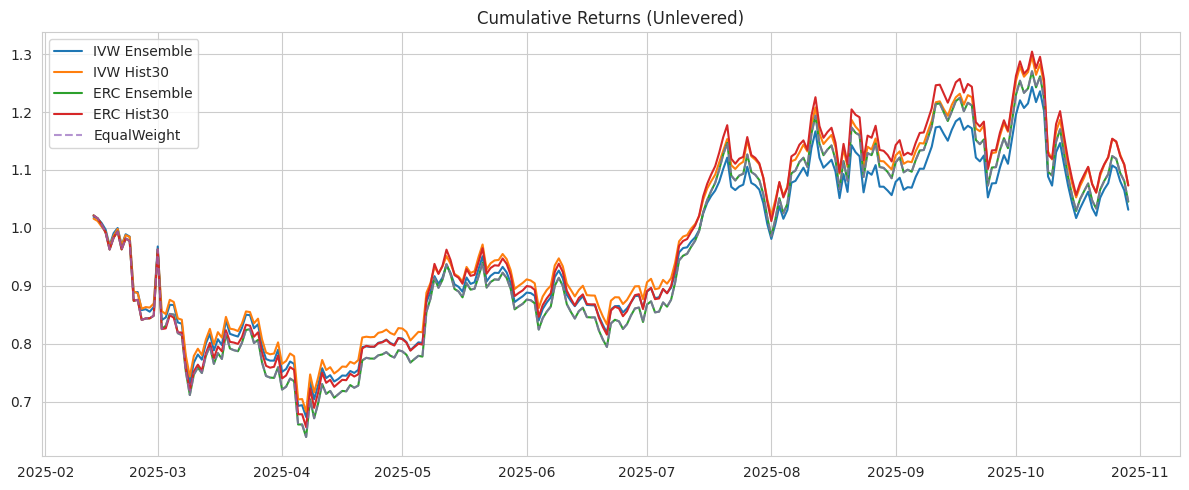

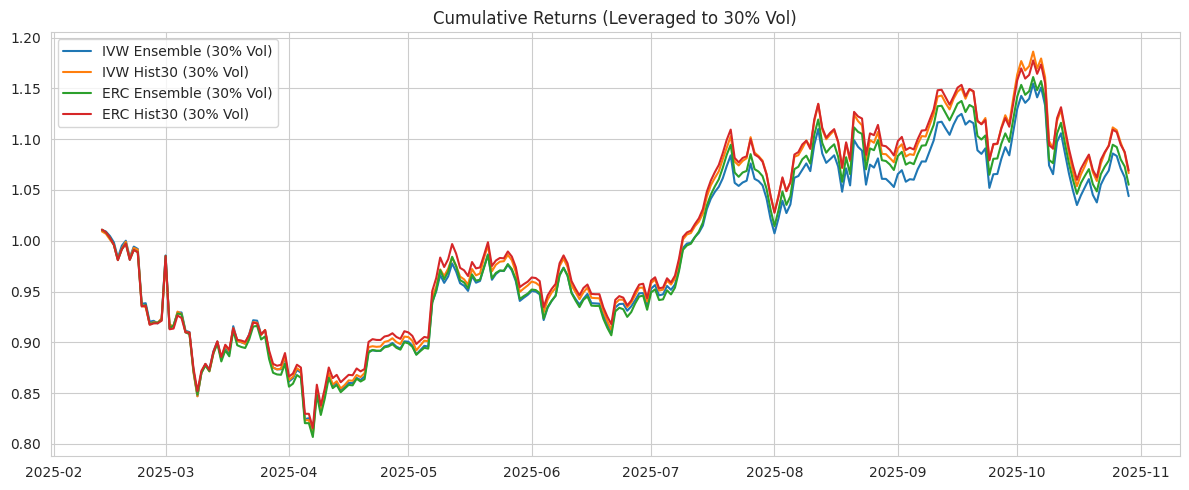

In [ ]:
# ============================================================
# SECTION 16C — Ensemble Volatility Portfolios (Unified ERC)
# Ensemble Vol vs Hist30 vs Equal-Weight
#
# This section evaluates the economic value of the
# rolling ML ensemble volatility forecasts.
#
# The ensemble-based portfolios are compared against:
# - Historical 30-day volatility (Hist30)
# - Equal-weight benchmark
#
# Portfolio constructions:
# - Inverse-Volatility Weighting (IVW)
# - Equal Risk Contribution (ERC)
#
# The ERC implementation is unified and consistent
# with Sections 16A and 16B.
# ============================================================

print("\n=== SECTION 16C: Ensemble Volatility Portfolios (Unified ERC) ===")

sns.set_style("whitegrid")

# Core settings (kept identical to earlier sections)
CRYPTO_SYMBOLS = ["BTC", "ETH", "BNB", "SOL", "XRP"]
LOOKBACK_RETS  = 10     # rolling window for ERC covariance
TRADING_DAYS   = 365    # crypto trades 365 days per year
USE_LEVERAGE   = True
TARGET_ANN_VOL = 0.30  # volatility targeting level


# HELPER
# Ensure datetime is naive
def to_naive(x):
    x = pd.to_datetime(x, errors="coerce")
    if isinstance(x, pd.DatetimeIndex) and x.tz is not None:
        return x.tz_convert(None)
    if hasattr(x, "dt") and getattr(x.dt, "tz", None) is not None:
        return x.dt.tz_convert(None)
    return x

def ensure_naive_index(df):
    df = df.copy()
    df.index = to_naive(df.index)
    return df

# ERC CONSTRUCTION
# From volatility forecast
def erc_from_vol(vol_row, date, rets_full, lookback=60):
    """
    Compute Equal Risk Contribution (ERC) weights using:
    - Rolling return correlations (from rets_full)
    - Volatility forecasts (vol_row)

    Steps:
    1. Estimate correlation from returns
    2. Scale by forecast volatility
    3. Solve ERC optimization problem
    """

    v = np.asarray(vol_row, float)

    # Rolling return window
    window = rets_full.loc[:date].dropna().iloc[-lookback:]
    if len(window) < 10:
        # Fallback to equal weights if insufficient data
        return np.ones_like(v) / len(v)

    cov_r = window.cov().values
    std_r = np.sqrt(np.diag(cov_r) + 1e-12)
    corr  = cov_r / np.outer(std_r, std_r)
    corr  = np.nan_to_num(corr, nan=0.0)
    np.fill_diagonal(corr, 1.0)

    # Reconstruct covariance using forecast volatilities
    cov_model = np.diag(v) @ corr @ np.diag(v)
    return solve_erc(cov_model)


def solve_erc(cov):
    """
    Solve the Equal Risk Contribution (ERC) problem.

    Objective:
    - Minimize squared deviations of individual risk
      contributions from their mean.

    If optimization fails:
    - Fallback to inverse-volatility weights.
    """
    n = cov.shape[0]
    w0 = np.ones(n) / n

    def objective(w):
        w = np.maximum(w, 1e-12)
        w = w / w.sum()
        portfolio_vol = np.sqrt(w @ cov @ w) + 1e-12
        rc = (w * (cov @ w)) / portfolio_vol
        return ((rc - rc.mean()) ** 2).sum()

    cons   = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * n

    res = minimize(objective, w0, bounds=bounds, constraints=cons)

    if not res.success:
        # Fallback: inverse-volatility
        stds = np.sqrt(np.diag(cov))
        inv  = 1/(stds + 1e-12)
        return inv / inv.sum()

    w = np.maximum(res.x, 0)
    return w / w.sum()

# PREREQUISITE CHECKS
# Ensures correct execution order of the pipeline
if "ensemble_results" not in globals():
    raise RuntimeError("Run Section 11 first — ensemble_results missing.")

if "vol_ml_df" not in globals():
    raise RuntimeError("Run Section 16B first — vol_ml_df missing.")

if "rets_df" not in globals():
    raise RuntimeError("rets_df missing — run Section 16A first.")

if "rets_full" not in globals():
    raise RuntimeError("rets_full missing — run Section 16A first.")

# MASTER INDEX FOR ENSEMBLE PORTFOLIO
# Intersection of all ensemble prediction dates, restricted to test window
date_sets = []
for s in CRYPTO_SYMBOLS:
    dfp = ensemble_results[s]["Preds"].copy()
    dfp["Date"] = to_naive(dfp["Date"])
    date_sets.append(set(dfp["Date"]))

master_index = pd.DatetimeIndex(sorted(set.intersection(*date_sets)))

# Ensure comparability with Sections 16A/16B: restrict to test window
if "test_index" in globals():
    master_index = master_index.intersection(test_index)

# BUILD ENSEMBLE VOLATILITY PANEL
ensemble_series = {}

for s in CRYPTO_SYMBOLS:

    dfp = ensemble_results[s]["Preds"].copy()
    dfp["Date"] = to_naive(dfp["Date"])
    dfp = dfp.sort_values("Date")

    ser = pd.Series(dfp["Ensemble_vol"].values, index=dfp["Date"])
    ser = ser.reindex(master_index)

    # Interpolate small gaps only
    ser = ser.interpolate(limit_direction="both")

    ensemble_series[s] = ser

vol_ens_df = pd.DataFrame(ensemble_series, index=master_index)
vol_ens_df = ensure_naive_index(vol_ens_df)

print("Ensemble volatility panel:", vol_ens_df.shape)
display(vol_ens_df.head())

# HISTORICAL VOLATILITY & RETURNS ALIGNMENT
if "hist30_vol_df" not in globals():
    raise RuntimeError("hist30_vol_df missing — run Section 16B first.")

hist30_vol_df2 = hist30_vol_df.reindex(master_index).ffill().bfill()

# Prepare next-day returns for PnL
nextret_df2 = nextret_df.reindex(master_index).ffill().bfill()

# PORTFOLIO WEIGHTS (IVW & ERC)
weights_ivw_ens  = []
weights_ivw_hist = []
weights_erc_ens  = []
weights_erc_hist = []

for dt in master_index:
    v_e = vol_ens_df.loc[dt].values
    v_h = hist30_vol_df2.loc[dt].values

    # Inverse Volatility Weights
    inv_e = 1/(v_e + 1e-12)
    inv_h = 1/(v_h + 1e-12)

    w_ivw_e = inv_e / inv_e.sum()
    w_ivw_h = inv_h / inv_h.sum()

    weights_ivw_ens.append(w_ivw_e)
    weights_ivw_hist.append(w_ivw_h)

    # ERC (unified logic)
    # Use rets_full instead of rets_df to match 16A/16B/17
    w_erc_e  = erc_from_vol(v_e,  dt, rets_full, lookback=LOOKBACK_RETS)
    w_erc_h0 = erc_from_vol(v_h, dt, rets_full, lookback=LOOKBACK_RETS)

    weights_erc_ens.append(w_erc_e)
    weights_erc_hist.append(w_erc_h0)

# Convert into DataFrames
weights_ivw_ens  = pd.DataFrame(weights_ivw_ens,  index=master_index, columns=CRYPTO_SYMBOLS)
weights_ivw_hist = pd.DataFrame(weights_ivw_hist, index=master_index, columns=CRYPTO_SYMBOLS)
weights_erc_ens  = pd.DataFrame(weights_erc_ens,  index=master_index, columns=CRYPTO_SYMBOLS)
weights_erc_hist = pd.DataFrame(weights_erc_hist, index=master_index, columns=CRYPTO_SYMBOLS)

# PORFOLIO RETURNS
sr_ivw_ens  = (weights_ivw_ens  * nextret_df2).sum(axis=1)
sr_ivw_hist = (weights_ivw_hist * nextret_df2).sum(axis=1)
sr_erc_ens  = (weights_erc_ens  * nextret_df2).sum(axis=1)
sr_erc_hist = (weights_erc_hist * nextret_df2).sum(axis=1)
sr_equal    = nextret_df2.mean(axis=1)

# PERFORMANCE STATISTICS
# Sharpe & stats
def perf_stats_from_logret(sr):
    """
    Compute performance metrics from daily log returns:
    - Annualized return
    - Annualized volatility
    - Sharpe ratio
    - Maximum drawdown
    """
    s = sr.dropna()
    if len(s) < 3:
        return dict(AnnRet=np.nan, AnnVol=np.nan, Sharpe=np.nan, MaxDD=np.nan)

    # Daily mean and std of log returns
    mu  = s.mean()
    sig = s.std()

    # Annualized arithmetic return implied by log returns
    ann_ret = np.exp(mu * TRADING_DAYS) - 1.0
    ann_vol = sig * np.sqrt(TRADING_DAYS)
    sharpe  = mu / (sig + 1e-12) * np.sqrt(TRADING_DAYS)

    # Wealth path from log returns
    wealth = np.exp(s.cumsum())
    maxdd  = (wealth / wealth.cummax() - 1).min()

    return dict(AnnRet=ann_ret, AnnVol=ann_vol, Sharpe=sharpe, MaxDD=maxdd)

# SUMMARY
# Result table
rows = []
for name, s in [
    ("IVW_Ensemble", sr_ivw_ens),
    ("IVW_Hist30",   sr_ivw_hist),
    ("ERC_Ensemble", sr_erc_ens),
    ("ERC_Hist30",   sr_erc_hist),
    ("EqualWeight",  sr_equal)
]:
    rows.append({"Name": name, **perf_stats_from_logret(s), "LeverageScale": 1.0})

# Optional leverage to target volatility
if USE_LEVERAGE:
    for base, s in [
        ("IVW_Ensemble", sr_ivw_ens),
        ("IVW_Hist30",   sr_ivw_hist),
        ("ERC_Ensemble", sr_erc_ens),
        ("ERC_Hist30",   sr_erc_hist)
    ]:
        s2 = s.dropna()
        cur = s2.std()*np.sqrt(TRADING_DAYS)
        lev = TARGET_ANN_VOL/(cur+1e-12)
        rows.append({"Name": f"{base}_Leverage",
                     **perf_stats_from_logret(s*lev),
                     "LeverageScale": lev})

df_portfolio_summary = pd.DataFrame(rows).set_index("Name")

print("\n=== Ensemble Portfolio Performance Summary ===")
display(df_portfolio_summary.round(6))

#VISUALIZATION
# Plot cumulative returns
plt.figure(figsize=(12,5))
plt.plot((1+sr_ivw_ens).cumprod(),  label="IVW Ensemble")
plt.plot((1+sr_ivw_hist).cumprod(), label="IVW Hist30")
plt.plot((1+sr_erc_ens).cumprod(),  label="ERC Ensemble")
plt.plot((1+sr_erc_hist).cumprod(), label="ERC Hist30")
plt.plot((1+sr_equal).cumprod(),    "--", label="EqualWeight", alpha=0.7)
plt.title("Cumulative Returns (Unlevered)")
plt.legend()
plt.tight_layout()
plt.show()

# Leverage-adjusted cumulative returns
if USE_LEVERAGE:
    plt.figure(figsize=(12,5))
    for s, nm in [
        (sr_ivw_ens,  "IVW Ensemble"),
        (sr_ivw_hist, "IVW Hist30"),
        (sr_erc_ens,  "ERC Ensemble"),
        (sr_erc_hist, "ERC Hist30")
    ]:
        s2 = s.dropna()
        cur = s2.std()*np.sqrt(TRADING_DAYS)
        lev = TARGET_ANN_VOL/(cur+1e-12)
        plt.plot((1+s*lev).cumprod(), label=f"{nm} (30% Vol)")
    plt.title("Cumulative Returns (Leveraged to 30% Vol)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# ============================================================
# SECTION 16D — Full Economic Value Summary
# Separated Leaderboards: IVW / ERC / Leverage Sharpe
#
# This section aggregates all portfolio results from:
# - Baseline volatility models (Section 16A)
# - ML-based volatility models (Section 16B)
# - Ensemble volatility models (Section 16C)
#
# The goal is to provide a clean, comparable economic-value
# summary using Sharpe ratios, split by:
#   1) Inverse-Volatility Weighting (IVW)
#   2) Equal Risk Contribution (ERC)
#   3) Leverage-adjusted portfolios (30% target volatility)
#
# Leaderboards are reported separately to avoid mixing
# fundamentally different portfolio constructions.
# ============================================================

print("\n=== SECTION 16D: Full Economic Value Summary (Separated Leaderboards) ===\n")

# Containers for different portfolio categories
ivw_rows = []   # inverse-volatility portfolios
erc_rows = []   # equal-risk-contribution portfolios
lev_rows = []   # leverage-adjusted portfolios

# BASELINE MODELS (FROM 16A)
# Includes:
# - HistAvg
# - EWMA
# - GARCH
# - Linear Regression
# - ElasticNet
if "df_baseline_econ" in globals():
    dfA = df_baseline_econ.copy()
    for model, row in dfA.iterrows():
        ivw_rows.append({
            "Model": model,
            "Category": "Baseline",
            "Sharpe": row["IVW_Sharpe"]
        })
        erc_rows.append({
            "Model": model,
            "Category": "Baseline",
            "Sharpe": row["ERC_Sharpe"]
        })
else:
    print("Warning: Baseline results df_baseline_econ missing.")

# ML MODELS & HISTORICAL BENCHMARKS (from Section 16B)
# Includes:
# - IVW_ML, ERC_ML portfolios
# - Hist30 benchmark portfolios
#
# These are classified as:
# - ML
# - Benchmark (Hist30)
if "df_perf_ml" in globals():
    dfB = df_perf_ml.copy()
    for model, row in dfB.iterrows():
        sharpe = row["Sharpe"]
        # Identify portfolio category by name
        if model in ["IVW_Hist30", "ERC_Hist30"]:
            category = "Benchmark"
        elif "IVW" in model:
            category = "ML"
        elif "ERC" in model:
            category = "ML"
        else:
            category = None
        # Skip anything that does not match IVW/ERC logic
        if category is None:
            continue
        # Store Sharpe ratios separately for IVW and ERC
        if "IVW" in model:
            ivw_rows.append({"Model": model, "Category": category, "Sharpe": sharpe})
        if "ERC" in model:
            erc_rows.append({"Model": model, "Category": category, "Sharpe": sharpe})
else:
    print("Warning: ML performance df_perf_ml missing.")

# LEVERAGE-ADJUSTED ML PORTFOLIOS (from Section 16B)
# These portfolios are volatility-targeted to 30% annual vol.
# They are separated to avoid mixing with unlevered strategies.
if "df_lev_ml" in globals():
    dfL = df_lev_ml.copy()
    for model, row in dfL.iterrows():
        sharpe = row["Sharpe"]
         # Distinguish benchmark vs ML leverage
        if model in ["IVW_Hist30_Leverage", "ERC_Hist30_Leverage"]:
            category = "Benchmark_Leverage"
        else:
            category = "ML_Leverage"
        lev_rows.append({
            "Model": model,
            "Category": category,
            "Sharpe": sharpe
        })
else:
    print("Warning: ML leverage df_lev_ml missing.")

# ENSEMBLE PORTFOLIOS (from Section 16C)
# # Includes:
# - IVW Ensemble
# - ERC Ensemble
# - Leverage-adjusted Ensemble portfolios
#
# IMPORTANT:
# - Hist30 portfolios are excluded here to avoid duplication
#   (already counted under Benchmark categories).
if "df_portfolio_summary" in globals():
    dfC = df_portfolio_summary.copy()
    for model, row in dfC.iterrows():
        sharpe = row["Sharpe"]

        # Handle leverage models
        if "Leverage" in model:
            if "Hist30" in model:
                # Explicitly ignore 16C Hist30 leverage in leaderboard
                continue
            else:
                category = "Ensemble_Leverage"
                lev_rows.append({
                    "Model": model,
                    "Category": category,
                    "Sharpe": sharpe
                })
            continue

        # Non-leveraged: ignore any Hist30 entries from 16C
        if "Hist30" in model:
            continue
        # Classify by portfolio construction
        if "IVW" in model:
            ivw_rows.append({
                "Model": model,
                "Category": "Ensemble",
                "Sharpe": sharpe
            })
        elif "ERC" in model:
            erc_rows.append({
                "Model": model,
                "Category": "Ensemble",
                "Sharpe": sharpe
            })
else:
    print("Warning: Ensemble results df_portfolio_summary missing.")

# BUILD FINAL LEADERBOARDS
df_ivw = pd.DataFrame(ivw_rows).set_index("Model").sort_values("Sharpe", ascending=False)
df_erc = pd.DataFrame(erc_rows).set_index("Model").sort_values("Sharpe", ascending=False)
df_lev = pd.DataFrame(lev_rows).set_index("Model").sort_values("Sharpe", ascending=False)

print("\n=== IVW Sharpe Leaderboard ===")
display(df_ivw.round(4))

print("\n=== ERC Sharpe Leaderboard ===")
display(df_erc.round(4))

print("\n=== Leverage Sharpe Leaderboard (30% Target Vol, Test Window) ===")
display(df_lev.round(4))

# SCOREBOARD — BEST MODELS BY CATEGORY
best_ivw = df_ivw["Sharpe"].idxmax() if len(df_ivw) > 0 else None
best_erc = df_erc["Sharpe"].idxmax() if len(df_erc) > 0 else None
best_lev = df_lev["Sharpe"].idxmax() if len(df_lev) > 0 else None

def safe_scalar(df, idx):
    """
    Safely extract a scalar Sharpe ratio,
    handling potential duplicate index cases.
    """
    if idx is None:
        return None
    s = df.loc[idx, "Sharpe"]
    if isinstance(s, pd.Series):
        return float(s.iloc[0])
    return float(s)

best_ivw_sharpe = safe_scalar(df_ivw, best_ivw)
best_erc_sharpe = safe_scalar(df_erc, best_erc)
best_lev_sharpe = safe_scalar(df_lev, best_lev)

print("\n=== BEST MODELS BY CATEGORY ===")
print(f"Best IVW Model:       {best_ivw} | Sharpe={best_ivw_sharpe:.4f}")
print(f"Best ERC Model:       {best_erc} | Sharpe={best_erc_sharpe:.4f}")
print(f"Best Leverage Model:  {best_lev} | Sharpe={best_lev_sharpe:.4f}")



=== SECTION 16D: Full Economic Value Summary (Separated Leaderboards) ===


=== IVW Sharpe Leaderboard ===


Category   Sharpe
Model                           
LinReg         Baseline 0.499900
ElasticNet     Baseline 0.495900
IVW_Hist30    Benchmark 0.452800
EWMA           Baseline 0.427300
HistAvg        Baseline 0.418600
GARCH          Baseline 0.384800
IVW_ML               ML 0.369400
IVW_Ensemble   Ensemble 0.352000


=== ERC Sharpe Leaderboard ===


Category   Sharpe
Model                           
GARCH          Baseline 0.466300
ERC_Hist30    Benchmark 0.464100
ElasticNet     Baseline 0.464100
LinReg         Baseline 0.455400
HistAvg        Baseline 0.455300
EWMA           Baseline 0.455300
ERC_ML               ML 0.438400
ERC_Ensemble   Ensemble 0.402300


=== Leverage Sharpe Leaderboard (30% Target Vol, Test Window) ===


Category   Sharpe
Model                                             
ERC_Hist30_Leverage    Benchmark_Leverage 0.464100
IVW_Hist30_Leverage    Benchmark_Leverage 0.452800
ERC_ML_Leverage               ML_Leverage 0.438400
ERC_Ensemble_Leverage   Ensemble_Leverage 0.402300
IVW_ML_Leverage               ML_Leverage 0.369400
IVW_Ensemble_Leverage   Ensemble_Leverage 0.352000


=== BEST MODELS BY CATEGORY ===
Best IVW Model:       LinReg | Sharpe=0.4999
Best ERC Model:       GARCH | Sharpe=0.4663
Best Leverage Model:  ERC_Hist30_Leverage | Sharpe=0.4641


END CODE


=== SECTION 17: Turnover & Rolling Sharpe Diagnostics (All Models, Test Window) ===
Turnover window length: 259
Turnover window range:  2025-02-13 00:00:00 → 2025-10-29 00:00:00

=== Turnover Summary (Average Daily Turnover) ===


Turnover
IVW_ML               0.146104
ERC_ML               0.002678
IVW_HistAvg          0.015179
IVW_EWMA             0.013081
IVW_GARCH            0.047151
IVW_LinReg           0.088768
IVW_ElasticNet       0.089733
ERC_HistAvg          0.000000
ERC_EWMA             0.000000
ERC_GARCH            0.015068
ERC_LinReg           0.005395
ERC_ElasticNet       0.005545
IVW_Ensemble         0.116589
ERC_Ensemble         0.000000
EqualWeight (drift)  0.001124

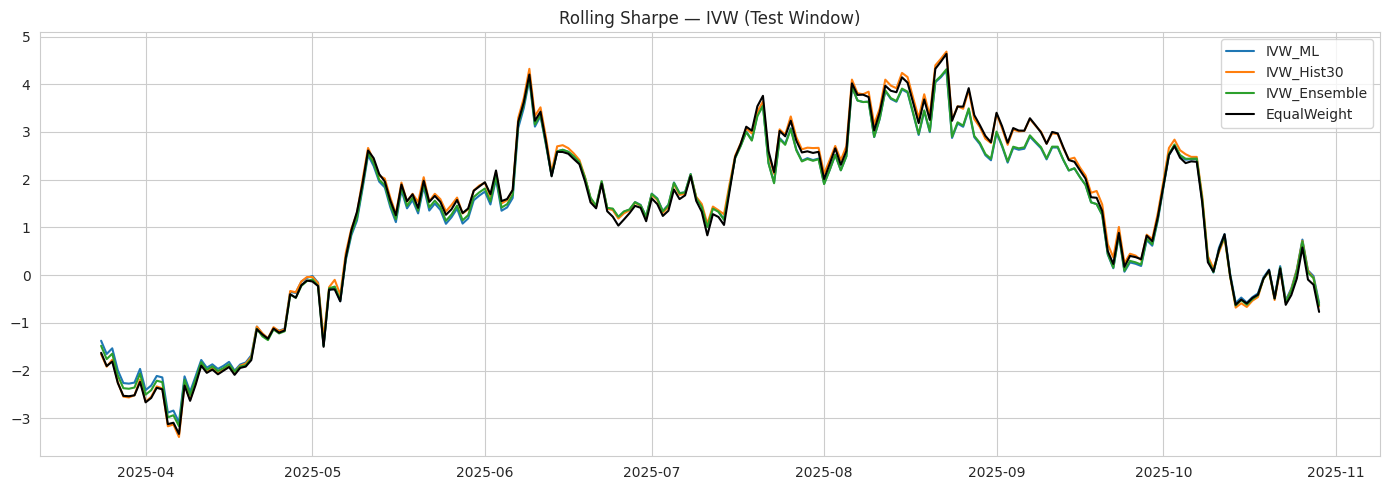

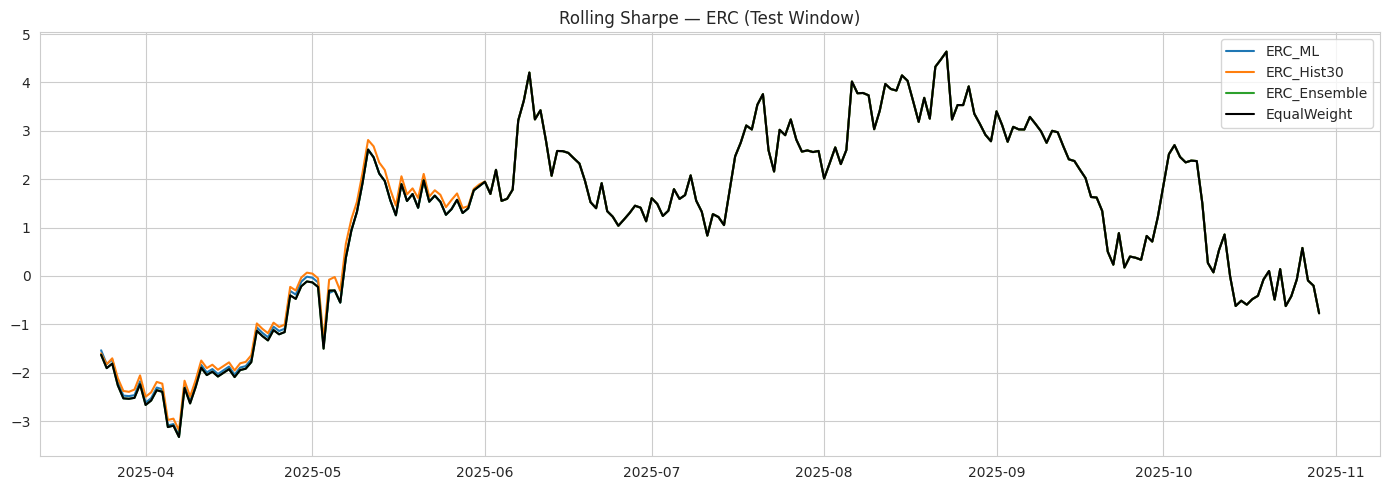

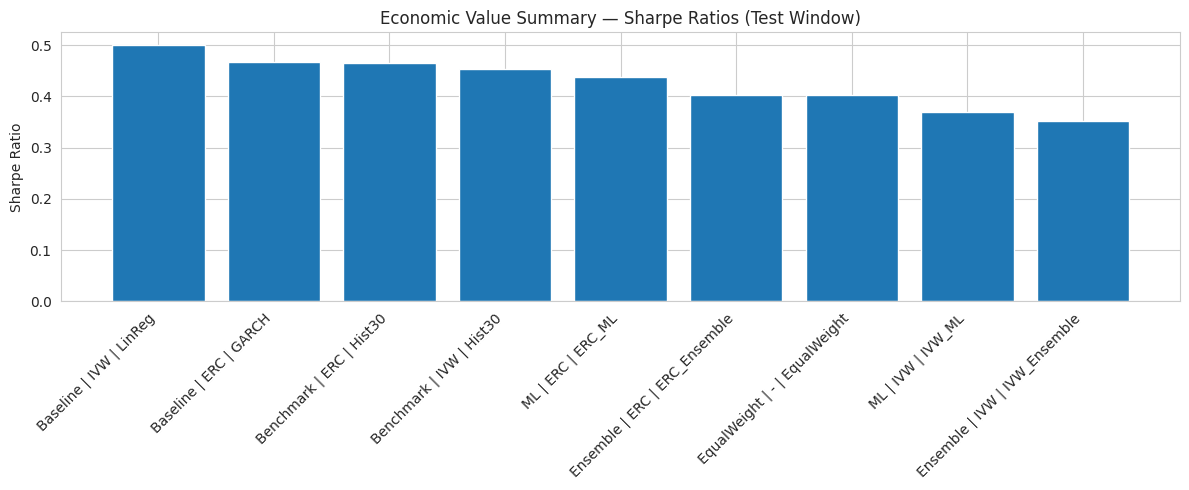

In [ ]:
# OPTIONAL

# ============================================================
# SECTION 17 — Turnover & Rolling Performance (Unified ERC, Test Window Only)
#
# This section evaluates the IMPLEMENTABILITY and STABILITY
# of the different volatility-based portfolio strategies.
#
# Two diagnostics are computed:
# 1) Portfolio turnover — proxy for transaction costs
# 2) Rolling Sharpe ratios — time-varying performance stability
#
# All analysis is restricted STRICTLY to the TEST window
# to avoid any look-ahead bias.
#
# Improvements included:
# - Robust alignment to test_index
# - Weight gap-handling (ffill/bfill) to prevent rolling Sharpe lines from breaking
# - Recompute portfolio returns on the same calendar for consistent plots
# - Rolling Sharpe uses min_periods to avoid early-window dropouts
# - Adds a single “economic value summary” Sharpe bar chart (Baseline vs ML vs Ensemble vs Benchmarks vs EqualWeight)
# ============================================================

print("\n=== SECTION 17: Turnover & Rolling Sharpe Diagnostics (All Models, Test Window) ===")

sns.set_style("whitegrid")

# Rolling window length for Sharpe ratio (~3 months)
ROLL = 63
# Annualization factor (crypto trades 365 days/year)
TD   = 365

# Required globals
required = [
    "test_index", "rets_full", "hist30_vol_full",
    "weights_ivw_ml", "weights_erc_ml", "weights_ivw_hist", "weights_erc_hist",
    "baseline_vols", "LOOKBACK_ERC", "CRYPTO_SYMBOLS",
    "sr_ivw_ens", "sr_erc_ens", "sr_eq",
    "df_baseline_econ", "df_perf_ml", "df_portfolio_summary"
]
for name in required:
    if name not in globals():
        raise RuntimeError(f"{name} missing — run previous sections ({name}).")

# Restrict to test window EXACTLY
turn_dates = pd.DatetimeIndex(test_index).sort_values().unique()

print(f"Turnover window length: {len(turn_dates)}")
print(f"Turnover window range:  {turn_dates[0]} → {turn_dates[-1]}")

# Helpers
def ivw_from_vol(v):
    inv = 1.0 / (np.asarray(v, float) + 1e-12)
    return inv / inv.sum()

def compute_turnover(wdf, index):
    d = wdf.reindex(index).ffill().bfill()
    return float(d.diff().abs().sum(axis=1).mean())

def rolling_sharpe(series, index, window=ROLL, min_periods=40):
    """
    Rolling Sharpe on log returns.
    min_periods < window makes the line start earlier and prevents gaps from killing the series.
    """
    s = pd.Series(series).reindex(index)
    mu  = s.rolling(window, min_periods=min_periods).mean()
    sig = s.rolling(window, min_periods=min_periods).std()
    return (mu / (sig + 1e-12)) * np.sqrt(TD)

def align_series(x, idx):
    return pd.Series(x).reindex(idx).ffill().bfill()

# ERC helper (unified logic; uses solve_erc defined earlier)
def erc_from_vol_local(vol_row, date, rets_full, lookback):
    v = np.asarray(vol_row, float)

    window = rets_full.loc[:date].dropna().iloc[-lookback:]
    if len(window) < 10:
        return np.ones(len(v)) / len(v)

    cov_r = window.cov().values
    std_r = np.sqrt(np.diag(cov_r) + 1e-12)
    corr  = cov_r / np.outer(std_r, std_r)
    corr  = np.nan_to_num(corr, nan=0.0)
    np.fill_diagonal(corr, 1.0)

    cov_model = np.diag(v) @ corr @ np.diag(v)
    return solve_erc(cov_model)

# COMPARE MODELS
# Prepare next-day returns on test window
nextret_full = rets_full.shift(-1)
nextret_df   = nextret_full.reindex(turn_dates).ffill().bfill()

# Equal-weight with drift (based on Hist30) — weights only (for turnover)
hist30_vol_df = hist30_vol_full.reindex(turn_dates).ffill().bfill()
vol_z = (hist30_vol_df - hist30_vol_df.mean()) / (hist30_vol_df.std() + 1e-12)
eq_drift = (1/len(CRYPTO_SYMBOLS)) * (1 + 0.02 * vol_z)
eq_drift = eq_drift.div(eq_drift.sum(axis=1), axis=0)
weights_equal_drift = eq_drift.copy()

# Baseline models: rebuild IVW + Unified ERC weights on test window
# (This keeps Section 17 self-consistent, independent of prior weight storage)
baseline_weight_ivw = {}
baseline_weight_erc = {}

for m in baseline_vols:
    vol_df = pd.DataFrame(baseline_vols[m]).reindex(turn_dates).ffill().bfill()

    # IVW
    w_ivw = vol_df.apply(lambda r: pd.Series(ivw_from_vol(r.values), index=r.index), axis=1)
    baseline_weight_ivw[m] = w_ivw

    # ERC
    erc_list = []
    for dt in turn_dates:
        v = vol_df.loc[dt].values
        erc_list.append(erc_from_vol_local(v, dt, rets_full, lookback=LOOKBACK_ERC))

    baseline_weight_erc[m] = pd.DataFrame(erc_list, index=turn_dates, columns=CRYPTO_SYMBOLS)

# SUMMARY
# Turnover summary
turnover_dict = {
    "IVW_ML":    compute_turnover(weights_ivw_ml, turn_dates),
    "ERC_ML":    compute_turnover(weights_erc_ml, turn_dates),

    "IVW_HistAvg":    compute_turnover(baseline_weight_ivw["HistAvg"], turn_dates),
    "IVW_EWMA":       compute_turnover(baseline_weight_ivw["EWMA"],    turn_dates),
    "IVW_GARCH":      compute_turnover(baseline_weight_ivw["GARCH"],   turn_dates),
    "IVW_LinReg":     compute_turnover(baseline_weight_ivw["LinReg"],  turn_dates),
    "IVW_ElasticNet": compute_turnover(baseline_weight_ivw["ElasticNet"], turn_dates),

    "ERC_HistAvg":    compute_turnover(baseline_weight_erc["HistAvg"], turn_dates),
    "ERC_EWMA":       compute_turnover(baseline_weight_erc["EWMA"],    turn_dates),
    "ERC_GARCH":      compute_turnover(baseline_weight_erc["GARCH"],   turn_dates),
    "ERC_LinReg":     compute_turnover(baseline_weight_erc["LinReg"],  turn_dates),
    "ERC_ElasticNet": compute_turnover(baseline_weight_erc["ElasticNet"], turn_dates),

    "IVW_Ensemble":   compute_turnover(weights_ivw_ens, turn_dates),
    "ERC_Ensemble":   compute_turnover(weights_erc_ens, turn_dates),

    "EqualWeight (drift)": compute_turnover(weights_equal_drift, turn_dates),
}

df_turnover = pd.DataFrame.from_dict(turnover_dict, orient="index", columns=["Turnover"])
print("\n=== Turnover Summary (Average Daily Turnover) ===")
display(df_turnover.round(6))

# Ensure weights are continuous, then recompute returns
weights_ivw_hist_fix = weights_ivw_hist.reindex(turn_dates).ffill().bfill()
weights_ivw_ml_fix   = weights_ivw_ml.reindex(turn_dates).ffill().bfill()

weights_erc_hist_fix = weights_erc_hist.reindex(turn_dates).ffill().bfill()
weights_erc_ml_fix   = weights_erc_ml.reindex(turn_dates).ffill().bfill()

# Recompute portfolio returns on the SAME calendar
sr_ivw_hist_fix = (weights_ivw_hist_fix * nextret_df).sum(axis=1)
sr_ivw_ml_fix   = (weights_ivw_ml_fix   * nextret_df).sum(axis=1)

sr_erc_hist_fix = (weights_erc_hist_fix * nextret_df).sum(axis=1)
sr_erc_ml_fix   = (weights_erc_ml_fix   * nextret_df).sum(axis=1)

# Ensemble and equal-weight series (already returns) aligned to test calendar
sr_ivw_ens_fix = align_series(sr_ivw_ens, turn_dates)
sr_erc_ens_fix = align_series(sr_erc_ens, turn_dates)
sr_eq_fix      = align_series(sr_eq,      turn_dates)

# VISUALIZATION
# Rolling Sharpe plots (test window)
plt.figure(figsize=(14,5))
plt.plot(rolling_sharpe(sr_ivw_ml_fix,   turn_dates), label="IVW_ML")
plt.plot(rolling_sharpe(sr_ivw_hist_fix, turn_dates), label="IVW_Hist30")
plt.plot(rolling_sharpe(sr_ivw_ens_fix,  turn_dates), label="IVW_Ensemble")
plt.plot(rolling_sharpe(sr_eq_fix,       turn_dates), label="EqualWeight", color="black")
plt.title("Rolling Sharpe — IVW (Test Window)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
plt.plot(rolling_sharpe(sr_erc_ml_fix,   turn_dates), label="ERC_ML")
plt.plot(rolling_sharpe(sr_erc_hist_fix, turn_dates), label="ERC_Hist30")
plt.plot(rolling_sharpe(sr_erc_ens_fix,  turn_dates), label="ERC_Ensemble")
plt.plot(rolling_sharpe(sr_eq_fix,       turn_dates), label="EqualWeight", color="black")
plt.title("Rolling Sharpe — ERC (Test Window)")
plt.legend(); plt.tight_layout(); plt.show()

# One “economic implications” summary chart:
# Sharpe bars comparing Baseline vs ML vs Ensemble vs Benchmark vs EqualWeight
rows = []

# Baselines (16A)
for m, r in df_baseline_econ.iterrows():
    rows.append({"Group": "Baseline", "Strategy": "IVW", "Model": m, "Sharpe": float(r["IVW_Sharpe"])})
    rows.append({"Group": "Baseline", "Strategy": "ERC", "Model": m, "Sharpe": float(r["ERC_Sharpe"])})

# ML + Benchmarks (16B)
for m, r in df_perf_ml.iterrows():
    if m == "EqualWeight":
        rows.append({"Group": "EqualWeight", "Strategy": "-", "Model": "EqualWeight", "Sharpe": float(r["Sharpe"])})
    elif "Hist30" in m:
        strat = "IVW" if "IVW" in m else "ERC"
        rows.append({"Group": "Benchmark", "Strategy": strat, "Model": "Hist30", "Sharpe": float(r["Sharpe"])})
    else:
        strat = "IVW" if "IVW" in m else "ERC"
        rows.append({"Group": "ML", "Strategy": strat, "Model": m, "Sharpe": float(r["Sharpe"])})

# Ensemble (16C)
dfC = df_portfolio_summary.copy()
if "IVW_Ensemble" in dfC.index:
    rows.append({"Group": "Ensemble", "Strategy": "IVW", "Model": "IVW_Ensemble", "Sharpe": float(dfC.loc["IVW_Ensemble", "Sharpe"])})
if "ERC_Ensemble" in dfC.index:
    rows.append({"Group": "Ensemble", "Strategy": "ERC", "Model": "ERC_Ensemble", "Sharpe": float(dfC.loc["ERC_Ensemble", "Sharpe"])})

df_summary = pd.DataFrame(rows)

# Reduce clutter: keep best baseline per strategy, plus ML / Ensemble / Benchmarks / EqualWeight
out = []
for strat in ["IVW", "ERC"]:
    sub = df_summary[(df_summary["Group"] == "Baseline") & (df_summary["Strategy"] == strat)]
    if len(sub):
        out.append(sub.sort_values("Sharpe", ascending=False).iloc[0])

out += [r for _, r in df_summary[df_summary["Group"].isin(["ML", "Ensemble", "Benchmark", "EqualWeight"])].iterrows()]

df_plot = pd.DataFrame(out).copy()
df_plot["Label"] = df_plot.apply(lambda r: f'{r["Group"]} | {r["Strategy"]} | {r["Model"]}', axis=1)
df_plot = df_plot.sort_values("Sharpe", ascending=False)

plt.figure(figsize=(12,5))
plt.bar(df_plot["Label"], df_plot["Sharpe"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Sharpe Ratio")
plt.title("Economic Value Summary — Sharpe Ratios (Test Window)")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# EXPORT NOTEBOOK TO HTML
# ============================================================

import os
from google.colab import drive, files

drive.mount("/content/drive")

src = "/content/drive/MyDrive/0. TFM/Crypto Volatility Model (Version 3).ipynb"
if not os.path.exists(src):
    raise FileNotFoundError(f"Notebook not found at:\n{src}")

dst = "/content/Crypto_Volatility_Model_V3_WIP.ipynb"
!cp "{src}" "{dst}"

!pip -q install nbconvert

out_name = "Crypto_Volatility_Model_V3_WIP.html"
out_path = f"/content/{out_name}"

!jupyter nbconvert --to html "{dst}" \
  --template classic \
  --ClearMetadataPreprocessor.enabled=True \
  --ClearMetadataPreprocessor.clear_cell_metadata=True \
  --ClearMetadataPreprocessor.clear_notebook_metadata=True \
  --output "{out_name}"

if not os.path.exists(out_path):
    raise RuntimeError(f"HTML was not created. Expected:\n{out_path}")

print("HTML created:", out_path)
files.download(out_path)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook /content/Crypto_Volatility_Model_V3_WIP.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 28 image(s).
[NbConvertApp] Writing 5677490 bytes to /content/Crypto_Volatility_Model_V3_WIP.html
HTML created: /content/Crypto_Volatility_Model_V3_WIP.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>